Part III - Building a Flare Detector
---
Posts in r/india can be corresponding to multiple topics. Each post is tagged for filtering
purposes. These tags are called a flares in the reddit world. r/india has flairs like Politics,
AskIndia, Science/Technology etc. 

**In this section, we will try to build a classifier which can predict the flare of a reddit post. Using the data collected in Part I as training and validation data.**

Before building a classifier, we need to pre-process our dataset and generate new features from existing ones. To do that we need to first find answers to questions like:
* which features to use for classification
* how to careful preprocess each feature
* which machine learning model to choose or deep learning algorithm to apply,
* and how to create a proper validation set

So, this notebook has been first divided into exploration of machine learning algorithms and then training a flair classifier

### As text classification:

First, let's introduce what Logistic Regression is. 

[Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression) is a classification model that is very easy to implement and performs very well on linearly separable classes. It is one of the most widely used
algorithms for classification in industry too, which makes it attractive to play with.

_Very_ simplistically explained, Logistic Regression works as follows:

![Logistic Regression](https://github.com/guillermo-carrasco/logistic-sentiment/blob/master/images/logistic_regression.png?raw=true)

First we will define the input for our algorithm. The imput will be each sample in whatever dataset we are working with. Each sample will consist of several features. For example, if we're working with housing price prediction, the features for each sample could be the size of the house, number of rooms, etc. We'll call the input vector **X**.

For the algorythm to learn, we need to define variables that we can adjust accordingly to what we want to predict. We will create a vector of _weights_ (**W**) that the model will adjust in order to predict more accurately. The process of adjusting those weights is what we call **learning**.

For every input sample, we will perform a dot product of the features by the weights **XW**. This product is sometimes referred as _net input_. This will give us a real number. Since in this particular problem we want to _classify_ (positive/negative), we need squash this number in the range [0, 1]. This will give us the _probability_ of a positive event. A function that does precisely that is called **sigmoid**. The sigmoid function looks like this:

![sigmoid](https://raw.githubusercontent.com/guillermo-carrasco/logistic-sentiment/master/images/sigmoid.svg)

What sigmoid is doing is basically transforming big inputs into a value close to 1, and small inputs into a value close to 0. This is exactly what we want. 

We will do this for every sample in our training set and compute the errors. To calculate the error we only need to compare our prediction with the true label for each sample. We will sum the square errors of all the samples to get a global prediction error. This will be our **cost function**.

A cost function is then something we want to minimize. **Gradient descent** is a method for finding the minimum of a function of multiple variables, such like the one we're dealing with here.

### The training process

In order for logistic regression to learn, we need to repeat the process descrived before several times. Each one of these times is called an **epoch**. The number of epochs to run depends on the problem and the training data. It is... yes, another tunnable parameter of the algorithm.

The set of all tunnable parameters is called **hyperparameters** of the model.

Like with the leatning rate, we need to be careful when choosing the number of epochs: If we train too many epochs, we risk **overfitting**. This means that our model will "memorize" the training data and will generalize badly when presented new data. 

If we train too little, it will fail to find any pattern and the prediction accuracy will be very low. This is known as **underfitting**.

There are techniques that help prevent overfitting. These **regularization** techniques are out of the scope of this tutorial, but... guess! It's also something to tune and experiment with :)

This is why when training a model you need to set aside a _test dataset_ in order to know the accuracy of your algorithm in unknown data. The test dataset will **never** be used during training

## Text Classification

Let's first of all have a look at the data

In [0]:
import pandas as pd

#Load the data into a DataFrame
data = pd.read_csv('data_1year.csv')

data.head()

,TITLE,BODY,FLAIR
0,Palette of Pollution,NaN,Non-Political
1,Allow banks to hold passports of loan-takers ...,[removed],Business/Finance
2,Allow banks to hold passports of loan-takers ...,NaN,Business/Finance
3,Tamil Nadu to usher in New Year on green note ...,NaN,Policy/Economy
4,Heera Gold Timeline #1 - Background - Pre 2007,Background – Pre 2007\n\nBefore anything Nowh...,Business/Finance


As we can see, we have 3 features each corresponding to specific field on reddit post: the **FLAIR** to be predicted, the **TITLE** of the post and the **BODY** of the post.  The structure of text features varies a lot between each  observation. They have different lengths, letters, numbers, extrange characters, etc. 

This makes it hard to build a classifier. If they were all correct dictionary words, we could use a **lexicon** to punctuate words. However because of the nature of social media language, we cannot do that. 

So we need a way of scoring the words such that words that appear in a reddit post can have equal score in each individual post.

But first... how do we represent the text features as vectors we can input to our algorithm?

### Bag of words

One thing we could do to represent the text featues as equal-sized vectors of numbers is the following:

* Create a list (vocabulary) with all the unique words in the whole corpus of twits. 
* We construct a feature vector from each post that contains the counts of how often each word occurs in the particular post.

_Note that since the unique words in each post represent only a small subset of all the words in the bag-of-words vocabulary, the feature vectors will mostly consist of zeros_

Let's construct the bag of words. We will work with a smaller example for illustrative purposes, and at the end we will work with our real data.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer

twits = [
    'Google maps caught a plane landing at Madurai airport- Tamil Nadu',
    'Palette at Pollution',
    'Chaliye  2019 ko Vannakam. ( Welcome to 2019)',
    'I am not sure about how this is going to end...'
]

count = CountVectorizer()
bag = count.fit_transform(twits)

count.vocabulary_

{'2019': 0,
 'about': 1,
 'airport': 2,
 'am': 3,
 'at': 4,
 'caught': 5,
 'chaliye': 6,
 'end': 7,
 'going': 8,
 'google': 9,
 'how': 10,
 'is': 11,
 'ko': 12,
 'landing': 13,
 'madurai': 14,
 'maps': 15,
 'nadu': 16,
 'not': 17,
 'palette': 18,
 'plane': 19,
 'pollution': 20,
 'sure': 21,
 'tamil': 22,
 'this': 23,
 'to': 24,
 'vannakam': 25,
 'welcome': 26}

As we can see from executing the preceding command, the vocabulary is stored in a Python dictionary that maps the unique words to integer indices. Next, let's print the feature vectors that we just created:

In [0]:
bag.toarray()

array([[0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
        0, 0, 0, 0, 0],
       [2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1],
       [0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 0, 0]])

Each index position in the feature vectors corresponds to the integer values that are stored as dictionary items in the CountVectorizer vocabulary. For example, the first feature at index position 0 resembles the count of the word '2019' , which only occurs in the third document, and the word 'to' , at index position 24, occurs in only last document. These values in the feature vectors are also called the **raw term frequencies**: `tf(t,d )` —the number of times a term `t` occurs in a document `d`.

### How relevant are words? Term frequency-inverse document frequency

We could use these raw term frequencies to score the words in our algorithm. There is a problem though: If a word is very frequent in _all_ documents, then it probably doesn't carry a lot of information. In order to tacke this problem we can use **term frequency-inverse document frequency**, which will reduce the score the more frequent the word is accross all twits. It is calculated like this:

\begin{equation*}
tf-idf(t,d) = tf(t,d) ~ idf(t,d)
\end{equation*}

_tf(t,d)_ is the raw term frequency descrived above. _idf(t,d)_ is the inverse document frequency, than can be calculated as follows:

\begin{equation*}
\log \frac{n_d}{1+df\left(d,t\right)}
\end{equation*}

where `n` is the total number of documents and _df(t,d)_ is the number of documents where the term `t` appears. 

The `1` addition in the denominator is just to avoid zero term for terms that appear in all documents. Ans the `log` ensures that low frequency term don't get too much weight.

Fortunately for us `scikit-learn` does all those calculations for us:

In [0]:
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf=True,
                         norm='l2',
                         smooth_idf=True)

np.set_printoptions(precision=2)

# Feed the tf-idf transformer with our previously created Bag of Words
tfidf.fit_transform(bag).toarray()

array([[0.  , 0.  , 0.32, 0.  , 0.25, 0.32, 0.  , 0.  , 0.  , 0.32, 0.  ,
        0.  , 0.  , 0.32, 0.32, 0.32, 0.32, 0.  , 0.  , 0.32, 0.  , 0.  ,
        0.32, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.49, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.62, 0.  , 0.62, 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.68, 0.  , 0.  , 0.  , 0.  , 0.  , 0.34, 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.34, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.27, 0.34, 0.34],
       [0.  , 0.32, 0.  , 0.32, 0.  , 0.  , 0.  , 0.32, 0.32, 0.  , 0.32,
        0.32, 0.  , 0.  , 0.  , 0.  , 0.  , 0.32, 0.  , 0.  , 0.  , 0.32,
        0.  , 0.32, 0.25, 0.  , 0.  ]])

As you can see, words that appear in all documents like _at_ (with 0.25 ), get a lower score than others that don't appear in all documents, like _pollution_ (with 0.62).

Note also that `norm='l2'` parameter: This is an important one, and what is doing is normalize the tf-idfs so that they're all in the same scale and thus work better with Logistic Regression.

## Data clean up

Basic data cleanup includes:

* lowercase
* stopwords removal

since, most library does lowercase of character by default we can focus on stopwords removal


### Removing stop words

Now that we know how to format and score our input, we can start doing the analysis! Can we?... Well, we _can_, but let's look at our **real** vocabulary. Specifically, the most common words:

In [0]:
from collections import Counter

vocab = Counter()
for twit in data.TITLE:
    for word in twit.split(' '):
        vocab[word] += 1

vocab.most_common(20)

[('', 25350),
 ('in', 21545),
 ('to', 19438),
 ('the', 17303),
 ('of', 16591),
 ('a', 10984),
 ('and', 10549),
 ('for', 10118),
 ('India', 9274),
 ('on', 8221),
 ('is', 8151),
 ('|', 6493),
 ('-', 5175),
 ('I', 4804),
 ('Indian', 4442),
 ('with', 4181),
 ('The', 4121),
 ('from', 4087),
 ('you', 4078),
 ('this', 3509)]

As you can see, the most common words are meaningless in terms of sentiment: _I, to, the, and_... they don't give any information on which flair is associated with each post. They're basically **noise** that can most probably be eliminated.

In [0]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

vocab_reduced = Counter()
for w, c in vocab.items():
    if not w in stop:
        vocab_reduced[w]=c

vocab_reduced.most_common(20)

[('', 25350),
 ('India', 9274),
 ('|', 6493),
 ('-', 5175),
 ('I', 4804),
 ('Indian', 4442),
 ('The', 4121),
 ('Modi', 3192),
 ('How', 2750),
 ('What', 2745),
 ('In', 2271),
 ('A', 2132),
 ('2019', 2000),
 ('BJP', 1969),
 ('Is', 1800),
 ('Why', 1715),
 ('To', 1690),
 ('&amp;', 1621),
 ('PM', 1596),
 ('Delhi', 1527)]

This looks better, only in the 20 most common words we already see words that make sense: _India, Modi, really_...

### Removing special characters and "trash"

We still see a very uneaven distribution. If you look closer, you'll see that we're also taking into consideration punctuation signs ('-', '|', etc) and other html tags like `&amp`. We can definitely remove them for the Text classification task, but we will try to keep the emoticons, since those _do_ have a sentiment load:

In [0]:
import re

def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text

print(preprocessor('This!! India’s satya isn’t sundar :) is <b>nice</b>'))

this india s satya isn t sundar is nice :)


We are almost ready! There is another trick we can use to reduce our vocabulary and consolidate words. If you think about it, words like: love, loving, etc. _Could_ express the same positivity. If that was the case, we would be  having two words in our vocabulary when we could have only one: lov. This process of reducing a word to its root is called **steaming**.

We also need a _tokenizer_ to break down our twits in individual words. We will implement two tokenizers, a regular one and one that does steaming:

In [0]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

print(tokenizer('Hi there, I am loving this, like with a lot of love'))
print(tokenizer_porter('Hi there, I am loving this, like with a lot of love'))

['Hi', 'there,', 'I', 'am', 'loving', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']
['Hi', 'there,', 'I', 'am', 'love', 'this,', 'like', 'with', 'a', 'lot', 'of', 'love']


## Training Logistic Regression

We are finally ready to train our algorythm. We need to choose the best hyperparameters like the _learning rate_ or _regularization strength_. We also would like to know if our algorithm performs better steaming words or not, or removing html or not, etc...

To take these decisions methodically, we can use a Grid Search. Grid search is a method of training an algorythm with different variations of parameters to latter select the best combination

In [0]:
from sklearn.model_selection import train_test_split

# split the dataset in train and test
X = data['TITLE']
y = data['FLAIR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

In the code line above, `stratify` will create a train set with the same class balance than the original set

## Hyperparameter Optimization:

It is based on the asssumption that: **Every thing is a hyperparameter from scaling to number of layers in a neural network, from which preprocessor to use to whether to remove stopwords or not**

So, we have used Grid Search to create a set of axis consisting of:
* whether to include stpowords removal in our pipeline or not
* which tokenizer to use
* which to regularizer to use
* and search through a set of values of C

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__preprocessor': [None, preprocessor],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__preprocessor': [None, preprocessor],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [0]:
# Note: This may take a long while to execute, like... 1 or 2 hours
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 34.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [0]:
print('Best parameter set: ' + str(gs_lr_tfidf.best_params_))
print('Best accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__preprocessor': <function preprocessor at 0x7f6db8df5730>, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x7f6db8df5f28>}
Best accuracy: 0.615


Interestingly, the set of parameters that best results give us are:

* A regularization strength of `1.0` using `l2` regularization
* Using our `preprocessor` (removing html, keeping emoticons, etc) _does_ improve the performance
* Surprisingly, removing stop words does not improve accuracy
* word steming also improve the performance

As youcan see, sometimes intuition may lead to wrong decisions, and it's important to _test_ all our assumptions. 

Let's see what's our best accuracy then:

In [0]:
clf = gs_lr_tfidf.best_estimator_
print('Accuracy in test: %.3f' % clf.score(X_test, y_test))

Accuracy in test: 0.623


Finally, let's run some tests :-)

In [0]:
posts_title = [
    "Palette of Pollution",
    "India Superpower 2020🇮🇳🇮🇳🇮🇳",
    "Happy New Year 2020",
    "India’s satya isn’t sundar"
]

preds = clf.predict(posts_title)

for i in range(len(posts_title)):
    print(f'{posts_title[i]} --> {preds[i]}')

Palette of Pollution --> Non-Political
India Superpower 2020🇮🇳🇮🇳🇮🇳 --> Non-Political
Happy New Year 2020 --> Non-Political
India’s satya isn’t sundar --> Non-Political


## Creating a proper validation set

It looks like classifier gave us 62.3% accuracy on test but can we use it in real world and deploy it in a web application. In this section, we will try to answer that question.

Our web applications will have an endpoint called /automated_testing. This endpoint will
be used for testing performance of your classifier. As this will be the process of web application deployment. Therefore, we will collect urls of differeent flairs, extract title of post from that flairs and use them to evaluate the accuracy of the model.

*This will act as public leaderboard for us to evaluate our classifier*

**Note: We will use the predefined flairs for evaluating our classifier**

In [0]:
!pip install praw

     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 204kB 55.4MB/s 


In [0]:
import praw  #Reddit API for fetching data
import pandas as pd
import os
import numpy as np
from tqdm import tqdm  #for progress bars

In [0]:
# Selecting the Subreddit as "india"
subreddit = reddit.subreddit('india')

# Flairs that we are going to search posts related to
flairs = ['AskIndia', 'Non-Political', 'Photography', 'Science/Technology', 'Politics', 'Business/Finance', 'Policy/Economy', 'Sports', 'Food']

          
print("Number of flairs we are searching for= ", len(flairs))

Number of flairs we are searching for=  9


In [0]:
# Looping over all the flair and fetching url for posts regarding each flair
actual_flairs = []
urls = []

for flair in tqdm(flairs):
  get_subreddits = subreddit.search(f"flair_name:{flair}", limit = 10)
  
  for submission in get_subreddits:
    url = submission.shortlink
    flair = submission.link_flair_text
    actual_flairs.append(flair)
    urls.append(url)

100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


In [0]:
# to collect title of post from reddit url:
def prediction(url):
  
  submission = reddit.submission(url = url)
  title = str(submission.title)
  
  return clf.predict([title])

In [0]:
%%time
pred = {} # python dictionary to store url as key and prediction as values
for url in urls:
  predict = prediction(url)
  pred[url] = predict

CPU times: user 1.6 s, sys: 29.7 ms, total: 1.63 s
Wall time: 1min 40s


In [0]:
# separate list for predicted flair and actual flair to evaluate accuracy
y_pred = []
y_test = []
for i, url in enumerate(urls):
  #preds = res[0]
  predict = pred[url]
  actual = actual_flairs[i]
  y_pred.append(predict)
  y_test.append(actual)

In [0]:
# evaluate accuracy 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=flairs))

accuracy 0.4024390243902439
                    precision    recall  f1-score   support

          AskIndia       0.67      0.80      0.73        10
     Non-Political       0.20      0.10      0.13        10
       Photography       0.23      0.82      0.35        11
Science/Technology       1.00      0.50      0.67        10
          Politics       1.00      0.20      0.33        10
  Business/Finance       0.29      0.40      0.33        10
    Policy/Economy       1.00      0.10      0.18        10
            Sports       1.00      0.30      0.46        10
              Food       0.00      0.00      0.00         1

          accuracy                           0.40        82
         macro avg       0.60      0.36      0.35        82
      weighted avg       0.66      0.40      0.39        82



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**It look like our classifer is highly overfitted to specific tags like Politics, AskIndia and underfitted to Sports, Science/Technology**

Hence, It tell us two things:
1. Even after having an yearly data **title** feature is not enough to build a highly accurate classifier
2. We need to **pre-pre-process** data much more so, that classifier can find patterns easily through it.

Data Preprocessing:
---
After doing data cleaning and hyperparamter optimization accuracy still pretty low, it looks like data needs much more preprocessing:

**doing preprocessing on small text subset and then on whole 1 year data**

In [0]:
df = pd.read_csv('data_subset.csv')

In [0]:
# fill nan values with empty space
df.fillna(" ", inplace=True)
df.isnull().sum()

author             0
created_utc        0
link_flair_text    0
num_comments       0
score              0
over_18            0
selftext           0
title              0
url                0
comments           0
comments_author    0
dtype: int64

In [0]:
# making sure text and body feature are string
df["selftext"] = df["selftext"].astype(str)
df["title"] = df["title"].astype(str)

In [0]:
# lowercase features
df["title"] = df["title"].apply(lambda x: x.lower())
df["selftext"] = df["selftext"].apply(lambda x: x.lower())

In [0]:
# combine them together
df["preprocessed"] = df["title"] + " " + df["selftext"]
df.head()

,author,created_utc,link_flair_text,num_comments,score,over_18,selftext,title,url,comments,comments_author,preprocessed
0,sanand_satwik,1.586713e+09,AskIndia,132,1041,False,hi....it's really tough time for everyone. i r...,"lost my job, sick mother and paralysed dad, in...",https://www.reddit.com/r/india/comments/g014wc...,I'm a freelancer. Don't listen to the idiots ...,hashedram diabapp xataari Aashayrao sarcrasti...,"lost my job, sick mother and paralysed dad, in..."
1,TWO-WHEELER-MAFIA,1.586419e+09,AskIndia,205,646,False,"we have floods, terrorist attacks, famines due...",why does the government come with a begging bo...,https://www.reddit.com/r/india/comments/fxofyu...,I don't understand why they don't use money f...,Kinky-Monk ak32009 fools_eye None DwncstSheep...,why does the government come with a begging bo...
2,indianoogler,1.586178e+09,AskIndia,214,260,False,the corona virus has given me some time to thi...,men who are 30+ and have decided not to get ma...,https://www.reddit.com/r/india/comments/fvy95j...,Plan your finances. Work and enjoy in your ow...,RedDevil-84 congratsindia khushraho kingof-po...,men who are 30+ and have decided not to get ma...
3,cataglottis,1.586783e+09,AskIndia,139,130,False,seems like everybody here is very critical of ...,"r/india: if money is no bar, would you prefer ...",https://www.reddit.com/r/india/comments/g0igt7...,"if money is not a thing, i would choose india...",_azadak 1209naveen reti_opening Neglectedsinc...,"r/india: if money is no bar, would you prefer ..."
4,flaregunistaken,1.586332e+09,AskIndia,182,122,False,sorry for poor formatting i am on phone.\n\n\n...,she is leaving me because of me being poor wha...,https://www.reddit.com/r/india/comments/fx29yh...,She was your Half Girlfriend. Picture is over...,satyasys dummy_roxx pandox992bu Bombaysux Bes...,she is leaving me because of me being poor wha...


In [0]:
import re

# Removing emojis

def rem_emoji(text):
    '''
    Takes a string as an input and returns the 
    same string after removing all the emojis
    '''
    
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    
    return(emoji_pattern.sub(r'', text)) # no emoji

df["preprocessed"] = df["preprocessed"].apply(rem_emoji)

In [0]:
# Importing the list of all stopwords
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words("english"))

#Stop word removal
df['preprocessed'] = df['preprocessed'].apply(lambda x: ' '.join([x for x in x.lower().split() if x not in english_stopwords]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Punctuation Removal
df['preprocessed'] = df['preprocessed'].str.replace('[^\w\s]',' ')

In [0]:
stop_words = pd.Series(' '.join(df['preprocessed']).split()).value_counts()[:20]
# remove most occuring words ... just noise
df['preprocessed']=df['preprocessed'].apply(lambda x: ' '.join([x for x in x.split() if x not in stop_words]))
df.head()

,author,created_utc,link_flair_text,num_comments,score,over_18,selftext,title,url,comments,comments_author,preprocessed
0,sanand_satwik,1.586713e+09,AskIndia,132,1041,False,hi....it's really tough time for everyone. i r...,"lost my job, sick mother and paralysed dad, in...",https://www.reddit.com/r/india/comments/g014wc...,I'm a freelancer. Don't listen to the idiots ...,hashedram diabapp xataari Aashayrao sarcrasti...,lost job sick mother paralysed dad earn online...
1,TWO-WHEELER-MAFIA,1.586419e+09,AskIndia,205,646,False,"we have floods, terrorist attacks, famines due...",why does the government come with a begging bo...,https://www.reddit.com/r/india/comments/fxofyu...,I don't understand why they don't use money f...,Kinky-Monk ak32009 fools_eye None DwncstSheep...,come begging bowl every crisis floods terroris...
2,indianoogler,1.586178e+09,AskIndia,214,260,False,the corona virus has given me some time to thi...,men who are 30+ and have decided not to get ma...,https://www.reddit.com/r/india/comments/fvy95j...,Plan your finances. Work and enjoy in your ow...,RedDevil-84 congratsindia khushraho kingof-po...,men 30 decided married plan old age corona vir...
3,cataglottis,1.586783e+09,AskIndia,139,130,False,seems like everybody here is very critical of ...,"r/india: if money is no bar, would you prefer ...",https://www.reddit.com/r/india/comments/g0igt7...,"if money is not a thing, i would choose india...",_azadak 1209naveen reti_opening Neglectedsinc...,r money bar would prefer stay outside seems ev...
4,flaregunistaken,1.586332e+09,AskIndia,182,122,False,sorry for poor formatting i am on phone.\n\n\n...,she is leaving me because of me being poor wha...,https://www.reddit.com/r/india/comments/fx29yh...,She was your Half Girlfriend. Picture is over...,satyasys dummy_roxx pandox992bu Bombaysux Bes...,leaving poor do sorry poor formatting phone we...


*Now, again using machine learning model to see if accuracy improve*

In [0]:
# same steps as above
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer

from nltk.corpus import stopwords

import re

from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer


# split the dataset in train and test
X = df['preprocessed']
y = df['link_flair_text']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

porter = PorterStemmer()

def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]


def preprocessor(text):
    """ Return a cleaned version of text
    """
    # Remove HTML markup
    text = re.sub('<[^>]*>', '', text)
    # Save emoticons for later appending
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    # Remove any non-word character and append the emoticons,
    # removing the nose character for standarization. Convert to lower case
    text = (re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-', ''))
    
    return text


stop = stopwords.words('english')

tfidf = TfidfTransformer(use_idf=True,
                         norm='l2',
                         smooth_idf=True)

np.set_printoptions(precision=2)


tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__preprocessor': [None, preprocessor],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              {'vect__ngram_range': [(1, 1)],
               'vect__stop_words': [stop, None],
               'vect__tokenizer': [tokenizer, tokenizer_porter],
               'vect__preprocessor': [None, preprocessor],
               'vect__use_idf':[False],
               'vect__norm':[None],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
              ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=0))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1,
                           n_jobs=-1)

In [0]:
# Note: This may take a long while to execute, like... 1 or 2 hours
gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [0]:
print('Best parameter set: ' + str(gs_lr_tfidf.best_params_))
print('Best accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__preprocessor': None, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x7f6db6e6d9d8>}
Best accuracy: 0.546


In [0]:
clf = gs_lr_tfidf.best_estimator_
print('Accuracy in test: %.3f' % clf.score(X_test, y_test))

Accuracy in test: 0.493


**Again collecting random urls and testing accuracy**

In [0]:
# to collect title of post from reddit url:
def prediction(url):
  
  submission = reddit.submission(url = url)
  title = str(submission.title)
  
  return clf.predict([title])

In [0]:
%%time
pred = {} # python dictionary to store url as key and prediction as values
for url in urls:
  predict = prediction(url)
  pred[url] = predict

CPU times: user 1.52 s, sys: 29 ms, total: 1.55 s
Wall time: 1min 35s


In [0]:
# separate list for predicted flair and actual flair to evaluate accuracy
y_pred = []
y_test = []
for i, url in enumerate(urls):
  #preds = res[0]
  predict = pred[url]
  actual = actual_flairs[i]
  y_pred.append(predict)
  y_test.append(actual)

In [0]:
# evaluate accuracy 
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.6219512195121951


**Well, accuracy is now 62.1% Still it is not enough for real world cases, since State-of-the-Art accuracy on Text classificaiton is above 90%**

Using Deep Learning:
---
Using Google's BERT, deep bidirectional training using the transformer, gave state of the art results for many NLP tasks. Therefore, In this part, we will be using [pytorch pretrained BERT](https://github.com/huggingface/pytorch-pretrained-BERT)

### What's different about BERT:

BERT is pre-trained on two different tasks:
1. in a sentence with two words removed, bert is trained to predict what those two words are,
2. given two sentences, bert is trained to determine whether one of these sentences comes after the other in a piece of text, or whether they are just two unrelated sentence

### How to use BERT for text classification:
1. Clone the [bert github](https://github.com/google-research/bert.git) repo onto your own machine.

2. Download the bert model files. These are the weights and other necessary files to represent the information bert learned in pre-training.

3. Get your data into the format bert expects. Make a folder in the directory you cloned bert into. You’ll be putting three separate files in here called train.tsv dev.tsvand test.tsv. 

4. Run training.

In [0]:
# divide dataset into training and testing
df1 = pd.read_csv('data_1year.csv', na_values=['[deleted]', '[removed]']) # training 
df = pd.read_csv('data_subset.csv') # testing

In [0]:
train_texts = list(df1['preprocessed'])
test_texts = list(df['preprocessed'])

print (len(train_texts))
print (len(test_texts))

82517
900


In [0]:
label_to_id = {'AskIndia': 0,
 'Business/Finance': 1,
 'Food': 2,
 'Non-Political': 3,
 'Photography': 4,
 'Policy/Economy': 5,
 'Politics': 6,
 'Science/Technology': 7,
 'Sports': 8}

id_to_label = {v: k for k, v in label_to_id.items()}
id_to_label

{0: 'AskIndia',
 1: 'Business/Finance',
 2: 'Food',
 3: 'Non-Political',
 4: 'Photography',
 5: 'Policy/Economy',
 6: 'Politics',
 7: 'Science/Technology',
 8: 'Sports'}

In [0]:
train_labels = list()
test_labels = list()

lables=[]

labels = list(df1['FLAIR'])
for label in labels:
  train_labels.append((label_to_id[label]))
  
labels =[]
labels = list(df['link_flair_text'])
for label in labels:
  test_labels.append((label_to_id[label]))
  
print (len(train_labels))
print (len(test_labels))

82517
900


In [0]:
import unicodedata
import re

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s
  
train_texts = [normalizeString(i) for i in train_texts]
test_texts = [normalizeString(i) for i in test_texts]

In [0]:
!pip install pytorch-pretrained-bert
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip uncased_L-12_H-768_A-12.zip

!pytorch_pretrained_bert convert_tf_checkpoint_to_pytorch \
  uncased_L-12_H-768_A-12/bert_model.ckpt \
  uncased_L-12_H-768_A-12/bert_config.json \
  uncased_L-12_H-768_A-12/pytorch_model.bin

     |████████████████████████████████| 133kB 2.7MB/s 
--2020-04-26 17:18:58--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 2404:6800:4008:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M   188MB/s    in 2.1s    

2020-04-26 17:19:00 (188 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: unc

In [0]:
import csv
import os
import logging
import argparse
import six
import random
from tqdm import tqdm, trange

import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.modeling import BertForSequenceClassification
from pytorch_pretrained_bert.optimization import BertAdam
from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

In [0]:
from collections import Counter

text_lens = Counter([len(x) for x in train_texts])
print("Zero-length reviews: {}".format(text_lens[1]))
print("Maximum review length: {}".format(max(text_lens)))

print('Number of reviews before removing outliers: ', len(train_texts))

non_zero_idx = [ii for ii, text in enumerate(train_texts) if len(text) != 1]

train_texts = [train_texts[ii] for ii in non_zero_idx]
train_labels = np.array([train_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(train_texts))

Zero-length reviews: 368
Maximum review length: 17522
Number of reviews before removing outliers:  82517
Number of reviews after removing outliers:  82149


In [0]:
from collections import Counter

text_lens = Counter([len(x) for x in test_texts])
print("Zero-length reviews: {}".format(text_lens[1]))
print("Maximum review length: {}".format(max(text_lens)))
print('Number of reviews before removing outliers: ', len(test_texts))

non_zero_idx = [ii for ii, text in enumerate(test_texts) if len(text) != 1]

test_texts = [test_texts[ii] for ii in non_zero_idx]
test_labels = np.array([test_labels[ii] for ii in non_zero_idx])

print('Number of reviews after removing outliers: ', len(test_texts))

Zero-length reviews: 0
Maximum review length: 10059
Number of reviews before removing outliers:  900
Number of reviews after removing outliers:  900


In [0]:
!rm -rf dataset
!mkdir dataset/

In [0]:
with open("dataset/train.tsv", "w") as f:
    f.write("sentence    label\n")
    for text, label in zip(train_texts, train_labels):
        f.write(str(text) + "\t" + str(label)+"\n")

In [0]:
with open("dataset/dev.tsv", "w") as f:
    f.write("sentence    label\n")
    for text, label in zip(test_texts, test_labels):
        f.write(str(text) + "\t" + str(label)+"\n")

## Fine tuning the BERT model for out classification task



**Implementing Some Helper Functions**

In [0]:
def convert_to_unicode(text):
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text.decode("utf-8", "ignore")
    elif isinstance(text, unicode):
      return text
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
    raise ValueError("Not running on Python2 or Python 3?")

In [0]:
def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]
                
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        input_mask = [1] * len(input_ids)

        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label_map[example.label]
        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

In [0]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [0]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

def warmup_linear(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 1.0 - x

In [0]:
class InputExample(object):

    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label


class InputFeatures(object):

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

In [0]:
class DataProcessor(object):

    def get_train_examples(self, data_dir):
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        raise NotImplementedError()

    def get_labels(self):
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        with open(input_file, "r", encoding='utf-8') as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                lines.append(line)
            return lines

In [0]:
class RedditDataProcessor(DataProcessor):

  def get_train_examples(self, data_dir):
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

  def get_dev_examples(self, data_dir):
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

  def get_labels(self):
    return ["0", "1", "2", "3", "4", "5", "6", "7", "8"]

  def _create_examples(self, lines, set_type):
    examples = []
    for (i, line) in enumerate(lines):
      if i == 0:
        continue
      guid = "%s-%s" % (set_type, i)
      if set_type == "test":
        text_a = convert_to_unicode(line[1])
        label = "0"
      else:
        text_a = convert_to_unicode(line[0])
        label = convert_to_unicode(line[1])
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

### Setting up hyperparameters

In [0]:
!rm -rf output/
!mkdir output
output_dir = 'output'
bert_model = 'uncased_L-12_H-768_A-12'
data_dir = 'dataset'

seed = 42
train_batch_size = 16
gradient_accumulation_steps = 1
max_seq_length = 256
learning_rate = 2e-5
num_train_epochs = 3.0
local_rank = -1
warmup_proportion = 0.1
eval_batch_size = train_batch_size
test_batch_size = train_batch_size

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
train_batch_size = int(train_batch_size / gradient_accumulation_steps)

logger.info("device: {} n_gpu: {}".format(device, n_gpu))
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

04/26/2020 17:20:42 - INFO - __main__ -   device: cuda n_gpu: 1


In [0]:
processor = RedditDataProcessor()
num_labels = 9 #['0', '1']
label_list = processor.get_labels()
tokenizer = BertTokenizer.from_pretrained(bert_model, do_lower_case=True)

04/26/2020 17:20:42 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file uncased_L-12_H-768_A-12/vocab.txt


In [0]:
train_examples = None
num_train_steps = None
train_examples = processor.get_train_examples(data_dir)
num_train_steps = int(len(train_examples) / train_batch_size / gradient_accumulation_steps * num_train_epochs)

In [0]:
# Prepare model
model = BertForSequenceClassification.from_pretrained(bert_model,
          cache_dir=PYTORCH_PRETRAINED_BERT_CACHE / 'distributed_{}'.format(local_rank),
          num_labels = num_labels)

model.to(device)
model = torch.nn.DataParallel(model)

04/26/2020 17:20:53 - INFO - pytorch_pretrained_bert.modeling -   loading archive file uncased_L-12_H-768_A-12
04/26/2020 17:20:53 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

04/26/2020 17:20:55 - INFO - pytorch_pretrained_bert.modeling -   Weights of BertForSequenceClassification not initialized from pretrained model: ['classifier.weight', 'classifier.bias']
04/26/2020 17:20:55 - INFO - pytorch_pretrained_bert.modeling -   Weights from pretrained model not used in BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.

In [0]:
# Prepare optimizer
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
t_total = num_train_steps

optimizer = BertAdam(optimizer_grouped_parameters,
                     lr=learning_rate,
                     warmup=warmup_proportion,
                     t_total=t_total)

global_step = 0
nb_tr_steps = 0
tr_loss = 0

## Start Training Loop

In [112]:
train_features = convert_examples_to_features(train_examples, label_list, max_seq_length, tokenizer)

logger.info("***** Running training *****")
logger.info("  Num examples = %d", len(train_examples))
logger.info("  Batch size = %d", train_batch_size)
logger.info("  Num steps = %d", num_train_steps)

all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

model.train()

for _ in trange(int(num_train_epochs), desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        loss = model(input_ids, segment_ids, input_mask, label_ids)
        loss.backward()

        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        if (nb_tr_steps % 100 == 0):
          print ('\nCurrent Loss', loss.item(), ' Mean Loss: ', tr_loss/ nb_tr_steps)
        if (step + 1) % gradient_accumulation_steps == 0:
            # modify learning rate with special warm up BERT uses
            lr_this_step = learning_rate * warmup_linear(global_step/t_total, warmup_proportion)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_this_step
            optimizer.step()
            optimizer.zero_grad()
            global_step += 1

04/26/2020 17:22:47 - INFO - __main__ -   *** Example ***
04/26/2020 17:22:47 - INFO - __main__ -   guid: train-1
04/26/2020 17:22:47 - INFO - __main__ -   tokens: [CLS] palette pollution [SEP]
04/26/2020 17:22:47 - INFO - __main__ -   input_ids: 101 27396 10796 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
04/26/2020 17:22:47 - INFO - __main__ -   input_mask: 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


Current Loss 2.404888868331909  Mean Loss:  2.3509709644317627





Iteration:   2%|▏         | 101/5135 [00:50<42:11,  1.99it/s]


Iteration:   2%|▏         | 102/5135 [00:51<42:15,  1.99it/s]


Iteration:   2%|▏         | 103/5135 [00:51<42:12,  1.99it/s]


Iteration:   2%|▏         | 104/5135 [00:52<42:15,  1.98it/s]


Iteration:   2%|▏         | 105/5135 [00:52<42:14,  1.98it/s]


Iteration:   2%|▏         | 106/5135 [00:53<42:17,  1.98it/s]


Iteration:   2%|▏         | 107/5135 [00:53<42:16,  1.98it/s]


Iteration:   2%|▏         | 108/5135 [00:54<42:16,  1.98it/s]


Iteration:   2%|▏         | 109/5135 [00:54<42:15,  1.98it/s]


Iteration:   2%|▏         | 110/5135 [00:55<42:15,  1.98it/s]


Iteration:   2%|▏         | 111/5135 [00:55<42:11,  1.98it/s]


Iteration:   2%|▏         | 112/5135 [00:56<42:12,  1.98it/s]


Iteration:   2%|▏         | 113/5135 [00:56<42:09,  1.99it/s]


Iteration:   2%|▏         | 114/5135 [00:57<42:08,  1.99it/s]


Iteration:   2%|▏         | 115/5135 [00:57<42:07,  1.99it/s]


Iteration:   2%|▏         | 116/5135 


Current Loss 1.9161630868911743  Mean Loss:  2.267485389113426





Iteration:   4%|▍         | 201/5135 [01:41<41:30,  1.98it/s]


Iteration:   4%|▍         | 202/5135 [01:41<41:34,  1.98it/s]


Iteration:   4%|▍         | 203/5135 [01:42<41:29,  1.98it/s]


Iteration:   4%|▍         | 204/5135 [01:42<41:33,  1.98it/s]


Iteration:   4%|▍         | 205/5135 [01:43<41:28,  1.98it/s]


Iteration:   4%|▍         | 206/5135 [01:43<41:29,  1.98it/s]


Iteration:   4%|▍         | 207/5135 [01:44<41:27,  1.98it/s]


Iteration:   4%|▍         | 208/5135 [01:44<41:30,  1.98it/s]


Iteration:   4%|▍         | 209/5135 [01:45<41:29,  1.98it/s]


Iteration:   4%|▍         | 210/5135 [01:45<41:38,  1.97it/s]


Iteration:   4%|▍         | 211/5135 [01:46<41:36,  1.97it/s]


Iteration:   4%|▍         | 212/5135 [01:46<41:34,  1.97it/s]


Iteration:   4%|▍         | 213/5135 [01:47<41:31,  1.98it/s]


Iteration:   4%|▍         | 214/5135 [01:47<41:30,  1.98it/s]


Iteration:   4%|▍         | 215/5135 [01:48<41:26,  1.98it/s]


Iteration:   4%|▍         | 216/5135 


Current Loss 1.5674289464950562  Mean Loss:  2.137011027733485





Iteration:   6%|▌         | 301/5135 [02:31<40:42,  1.98it/s]


Iteration:   6%|▌         | 302/5135 [02:32<40:39,  1.98it/s]


Iteration:   6%|▌         | 303/5135 [02:32<40:39,  1.98it/s]


Iteration:   6%|▌         | 304/5135 [02:33<40:39,  1.98it/s]


Iteration:   6%|▌         | 305/5135 [02:33<40:38,  1.98it/s]


Iteration:   6%|▌         | 306/5135 [02:34<40:35,  1.98it/s]


Iteration:   6%|▌         | 307/5135 [02:34<40:37,  1.98it/s]


Iteration:   6%|▌         | 308/5135 [02:35<40:44,  1.97it/s]


Iteration:   6%|▌         | 309/5135 [02:35<40:42,  1.98it/s]


Iteration:   6%|▌         | 310/5135 [02:36<40:38,  1.98it/s]


Iteration:   6%|▌         | 311/5135 [02:36<40:37,  1.98it/s]


Iteration:   6%|▌         | 312/5135 [02:37<40:47,  1.97it/s]


Iteration:   6%|▌         | 313/5135 [02:37<40:39,  1.98it/s]


Iteration:   6%|▌         | 314/5135 [02:38<40:36,  1.98it/s]


Iteration:   6%|▌         | 315/5135 [02:38<40:36,  1.98it/s]


Iteration:   6%|▌         | 316/5135 


Current Loss 1.6298006772994995  Mean Loss:  2.021714124083519





Iteration:   8%|▊         | 401/5135 [03:22<39:55,  1.98it/s]


Iteration:   8%|▊         | 402/5135 [03:22<39:53,  1.98it/s]


Iteration:   8%|▊         | 403/5135 [03:23<39:50,  1.98it/s]


Iteration:   8%|▊         | 404/5135 [03:23<39:52,  1.98it/s]


Iteration:   8%|▊         | 405/5135 [03:24<39:50,  1.98it/s]


Iteration:   8%|▊         | 406/5135 [03:24<39:51,  1.98it/s]


Iteration:   8%|▊         | 407/5135 [03:25<39:50,  1.98it/s]


Iteration:   8%|▊         | 408/5135 [03:25<39:50,  1.98it/s]


Iteration:   8%|▊         | 409/5135 [03:26<39:48,  1.98it/s]


Iteration:   8%|▊         | 410/5135 [03:26<39:51,  1.98it/s]


Iteration:   8%|▊         | 411/5135 [03:27<39:49,  1.98it/s]


Iteration:   8%|▊         | 412/5135 [03:27<39:50,  1.98it/s]


Iteration:   8%|▊         | 413/5135 [03:28<39:45,  1.98it/s]


Iteration:   8%|▊         | 414/5135 [03:28<39:51,  1.97it/s]


Iteration:   8%|▊         | 415/5135 [03:29<39:47,  1.98it/s]


Iteration:   8%|▊         | 416/5135 


Current Loss 1.3214677572250366  Mean Loss:  1.9362488651275636





Iteration:  10%|▉         | 501/5135 [04:12<39:05,  1.98it/s]


Iteration:  10%|▉         | 502/5135 [04:13<39:03,  1.98it/s]


Iteration:  10%|▉         | 503/5135 [04:13<38:58,  1.98it/s]


Iteration:  10%|▉         | 504/5135 [04:14<38:56,  1.98it/s]


Iteration:  10%|▉         | 505/5135 [04:14<38:53,  1.98it/s]


Iteration:  10%|▉         | 506/5135 [04:15<38:55,  1.98it/s]


Iteration:  10%|▉         | 507/5135 [04:15<38:53,  1.98it/s]


Iteration:  10%|▉         | 508/5135 [04:16<38:54,  1.98it/s]


Iteration:  10%|▉         | 509/5135 [04:16<38:54,  1.98it/s]


Iteration:  10%|▉         | 510/5135 [04:17<38:54,  1.98it/s]


Iteration:  10%|▉         | 511/5135 [04:17<39:06,  1.97it/s]


Iteration:  10%|▉         | 512/5135 [04:18<39:04,  1.97it/s]


Iteration:  10%|▉         | 513/5135 [04:18<38:58,  1.98it/s]


Iteration:  10%|█         | 514/5135 [04:19<39:00,  1.97it/s]


Iteration:  10%|█         | 515/5135 [04:19<38:54,  1.98it/s]


Iteration:  10%|█         | 516/5135 


Current Loss 1.1265485286712646  Mean Loss:  1.863316724896431





Iteration:  12%|█▏        | 601/5135 [05:03<38:07,  1.98it/s]


Iteration:  12%|█▏        | 602/5135 [05:03<38:11,  1.98it/s]


Iteration:  12%|█▏        | 603/5135 [05:04<38:07,  1.98it/s]


Iteration:  12%|█▏        | 604/5135 [05:04<38:10,  1.98it/s]


Iteration:  12%|█▏        | 605/5135 [05:05<38:07,  1.98it/s]


Iteration:  12%|█▏        | 606/5135 [05:05<38:07,  1.98it/s]


Iteration:  12%|█▏        | 607/5135 [05:06<38:06,  1.98it/s]


Iteration:  12%|█▏        | 608/5135 [05:06<38:04,  1.98it/s]


Iteration:  12%|█▏        | 609/5135 [05:07<38:02,  1.98it/s]


Iteration:  12%|█▏        | 610/5135 [05:07<38:02,  1.98it/s]


Iteration:  12%|█▏        | 611/5135 [05:08<38:00,  1.98it/s]


Iteration:  12%|█▏        | 612/5135 [05:08<38:05,  1.98it/s]


Iteration:  12%|█▏        | 613/5135 [05:09<38:03,  1.98it/s]


Iteration:  12%|█▏        | 614/5135 [05:09<38:06,  1.98it/s]


Iteration:  12%|█▏        | 615/5135 [05:10<38:02,  1.98it/s]


Iteration:  12%|█▏        | 616/5135 


Current Loss 1.4574379920959473  Mean Loss:  1.8018025423799242





Iteration:  14%|█▎        | 701/5135 [05:53<37:16,  1.98it/s]


Iteration:  14%|█▎        | 702/5135 [05:54<37:20,  1.98it/s]


Iteration:  14%|█▎        | 703/5135 [05:54<37:19,  1.98it/s]


Iteration:  14%|█▎        | 704/5135 [05:55<37:18,  1.98it/s]


Iteration:  14%|█▎        | 705/5135 [05:55<37:15,  1.98it/s]


Iteration:  14%|█▎        | 706/5135 [05:56<37:15,  1.98it/s]


Iteration:  14%|█▍        | 707/5135 [05:56<37:13,  1.98it/s]


Iteration:  14%|█▍        | 708/5135 [05:57<37:19,  1.98it/s]


Iteration:  14%|█▍        | 709/5135 [05:57<37:18,  1.98it/s]


Iteration:  14%|█▍        | 710/5135 [05:58<37:19,  1.98it/s]


Iteration:  14%|█▍        | 711/5135 [05:58<37:17,  1.98it/s]


Iteration:  14%|█▍        | 712/5135 [05:59<37:15,  1.98it/s]


Iteration:  14%|█▍        | 713/5135 [06:00<37:11,  1.98it/s]


Iteration:  14%|█▍        | 714/5135 [06:00<37:13,  1.98it/s]


Iteration:  14%|█▍        | 715/5135 [06:01<37:13,  1.98it/s]


Iteration:  14%|█▍        | 716/5135 


Current Loss 1.862673044204712  Mean Loss:  1.753340433984995





Iteration:  16%|█▌        | 801/5135 [06:44<36:27,  1.98it/s]


Iteration:  16%|█▌        | 802/5135 [06:44<36:29,  1.98it/s]


Iteration:  16%|█▌        | 803/5135 [06:45<36:27,  1.98it/s]


Iteration:  16%|█▌        | 804/5135 [06:45<36:26,  1.98it/s]


Iteration:  16%|█▌        | 805/5135 [06:46<36:30,  1.98it/s]


Iteration:  16%|█▌        | 806/5135 [06:46<36:32,  1.97it/s]


Iteration:  16%|█▌        | 807/5135 [06:47<36:32,  1.97it/s]


Iteration:  16%|█▌        | 808/5135 [06:47<36:29,  1.98it/s]


Iteration:  16%|█▌        | 809/5135 [06:48<36:31,  1.97it/s]


Iteration:  16%|█▌        | 810/5135 [06:48<36:27,  1.98it/s]


Iteration:  16%|█▌        | 811/5135 [06:49<36:25,  1.98it/s]


Iteration:  16%|█▌        | 812/5135 [06:49<36:26,  1.98it/s]


Iteration:  16%|█▌        | 813/5135 [06:50<36:25,  1.98it/s]


Iteration:  16%|█▌        | 814/5135 [06:50<36:27,  1.98it/s]


Iteration:  16%|█▌        | 815/5135 [06:51<36:28,  1.97it/s]


Iteration:  16%|█▌        | 816/5135 


Current Loss 1.058614730834961  Mean Loss:  1.7084673871596654





Iteration:  18%|█▊        | 901/5135 [07:34<35:31,  1.99it/s]


Iteration:  18%|█▊        | 902/5135 [07:35<35:29,  1.99it/s]


Iteration:  18%|█▊        | 903/5135 [07:35<35:28,  1.99it/s]


Iteration:  18%|█▊        | 904/5135 [07:36<35:27,  1.99it/s]


Iteration:  18%|█▊        | 905/5135 [07:36<35:26,  1.99it/s]


Iteration:  18%|█▊        | 906/5135 [07:37<35:28,  1.99it/s]


Iteration:  18%|█▊        | 907/5135 [07:37<35:29,  1.99it/s]


Iteration:  18%|█▊        | 908/5135 [07:38<35:30,  1.98it/s]


Iteration:  18%|█▊        | 909/5135 [07:38<35:33,  1.98it/s]


Iteration:  18%|█▊        | 910/5135 [07:39<35:31,  1.98it/s]


Iteration:  18%|█▊        | 911/5135 [07:39<35:29,  1.98it/s]


Iteration:  18%|█▊        | 912/5135 [07:40<35:29,  1.98it/s]


Iteration:  18%|█▊        | 913/5135 [07:40<35:27,  1.98it/s]


Iteration:  18%|█▊        | 914/5135 [07:41<35:30,  1.98it/s]


Iteration:  18%|█▊        | 915/5135 [07:41<35:27,  1.98it/s]


Iteration:  18%|█▊        | 916/5135 


Current Loss 1.4813768863677979  Mean Loss:  1.668285562813282





Iteration:  19%|█▉        | 1001/5135 [08:25<34:43,  1.98it/s]


Iteration:  20%|█▉        | 1002/5135 [08:25<34:44,  1.98it/s]


Iteration:  20%|█▉        | 1003/5135 [08:26<34:43,  1.98it/s]


Iteration:  20%|█▉        | 1004/5135 [08:26<34:42,  1.98it/s]


Iteration:  20%|█▉        | 1005/5135 [08:27<34:40,  1.98it/s]


Iteration:  20%|█▉        | 1006/5135 [08:27<34:42,  1.98it/s]


Iteration:  20%|█▉        | 1007/5135 [08:28<34:42,  1.98it/s]


Iteration:  20%|█▉        | 1008/5135 [08:28<34:41,  1.98it/s]


Iteration:  20%|█▉        | 1009/5135 [08:29<34:39,  1.98it/s]


Iteration:  20%|█▉        | 1010/5135 [08:29<34:37,  1.99it/s]


Iteration:  20%|█▉        | 1011/5135 [08:30<34:36,  1.99it/s]


Iteration:  20%|█▉        | 1012/5135 [08:30<34:35,  1.99it/s]


Iteration:  20%|█▉        | 1013/5135 [08:31<34:38,  1.98it/s]


Iteration:  20%|█▉        | 1014/5135 [08:31<34:36,  1.98it/s]


Iteration:  20%|█▉        | 1015/5135 [08:32<34:37,  1.98it/s]


Iteration:  20%|█▉    


Current Loss 0.9477364420890808  Mean Loss:  1.6344543639638207





Iteration:  21%|██▏       | 1101/5135 [09:15<33:52,  1.98it/s]


Iteration:  21%|██▏       | 1102/5135 [09:16<33:50,  1.99it/s]


Iteration:  21%|██▏       | 1103/5135 [09:16<33:49,  1.99it/s]


Iteration:  21%|██▏       | 1104/5135 [09:17<33:48,  1.99it/s]


Iteration:  22%|██▏       | 1105/5135 [09:17<33:47,  1.99it/s]


Iteration:  22%|██▏       | 1106/5135 [09:18<33:46,  1.99it/s]


Iteration:  22%|██▏       | 1107/5135 [09:18<33:46,  1.99it/s]


Iteration:  22%|██▏       | 1108/5135 [09:19<33:45,  1.99it/s]


Iteration:  22%|██▏       | 1109/5135 [09:19<33:44,  1.99it/s]


Iteration:  22%|██▏       | 1110/5135 [09:20<33:44,  1.99it/s]


Iteration:  22%|██▏       | 1111/5135 [09:20<33:42,  1.99it/s]


Iteration:  22%|██▏       | 1112/5135 [09:21<33:42,  1.99it/s]


Iteration:  22%|██▏       | 1113/5135 [09:21<33:48,  1.98it/s]


Iteration:  22%|██▏       | 1114/5135 [09:22<33:47,  1.98it/s]


Iteration:  22%|██▏       | 1115/5135 [09:22<33:48,  1.98it/s]


Iteration:  22%|██▏   


Current Loss 0.8191324472427368  Mean Loss:  1.6004779655237993





Iteration:  23%|██▎       | 1201/5135 [10:06<33:02,  1.98it/s]


Iteration:  23%|██▎       | 1202/5135 [10:06<33:01,  1.99it/s]


Iteration:  23%|██▎       | 1203/5135 [10:07<33:01,  1.98it/s]


Iteration:  23%|██▎       | 1204/5135 [10:07<32:59,  1.99it/s]


Iteration:  23%|██▎       | 1205/5135 [10:08<33:02,  1.98it/s]


Iteration:  23%|██▎       | 1206/5135 [10:08<33:01,  1.98it/s]


Iteration:  24%|██▎       | 1207/5135 [10:09<32:58,  1.99it/s]


Iteration:  24%|██▎       | 1208/5135 [10:09<32:58,  1.99it/s]


Iteration:  24%|██▎       | 1209/5135 [10:10<32:57,  1.99it/s]


Iteration:  24%|██▎       | 1210/5135 [10:10<32:57,  1.98it/s]


Iteration:  24%|██▎       | 1211/5135 [10:11<32:57,  1.98it/s]


Iteration:  24%|██▎       | 1212/5135 [10:11<32:56,  1.98it/s]


Iteration:  24%|██▎       | 1213/5135 [10:12<32:56,  1.98it/s]


Iteration:  24%|██▎       | 1214/5135 [10:12<32:54,  1.99it/s]


Iteration:  24%|██▎       | 1215/5135 [10:13<32:53,  1.99it/s]


Iteration:  24%|██▎   


Current Loss 1.0276910066604614  Mean Loss:  1.570997188274677





Iteration:  25%|██▌       | 1301/5135 [10:56<32:11,  1.99it/s]


Iteration:  25%|██▌       | 1302/5135 [10:56<32:11,  1.98it/s]


Iteration:  25%|██▌       | 1303/5135 [10:57<32:08,  1.99it/s]


Iteration:  25%|██▌       | 1304/5135 [10:57<32:08,  1.99it/s]


Iteration:  25%|██▌       | 1305/5135 [10:58<32:06,  1.99it/s]


Iteration:  25%|██▌       | 1306/5135 [10:58<32:05,  1.99it/s]


Iteration:  25%|██▌       | 1307/5135 [10:59<32:05,  1.99it/s]


Iteration:  25%|██▌       | 1308/5135 [10:59<32:06,  1.99it/s]


Iteration:  25%|██▌       | 1309/5135 [11:00<32:06,  1.99it/s]


Iteration:  26%|██▌       | 1310/5135 [11:00<32:06,  1.99it/s]


Iteration:  26%|██▌       | 1311/5135 [11:01<32:06,  1.99it/s]


Iteration:  26%|██▌       | 1312/5135 [11:01<32:05,  1.99it/s]


Iteration:  26%|██▌       | 1313/5135 [11:02<32:05,  1.99it/s]


Iteration:  26%|██▌       | 1314/5135 [11:02<32:05,  1.98it/s]


Iteration:  26%|██▌       | 1315/5135 [11:03<32:06,  1.98it/s]


Iteration:  26%|██▌   


Current Loss 1.2116589546203613  Mean Loss:  1.5452278814145497





Iteration:  27%|██▋       | 1401/5135 [11:46<31:27,  1.98it/s]


Iteration:  27%|██▋       | 1402/5135 [11:47<31:24,  1.98it/s]


Iteration:  27%|██▋       | 1403/5135 [11:47<31:24,  1.98it/s]


Iteration:  27%|██▋       | 1404/5135 [11:48<31:22,  1.98it/s]


Iteration:  27%|██▋       | 1405/5135 [11:48<31:22,  1.98it/s]


Iteration:  27%|██▋       | 1406/5135 [11:49<31:20,  1.98it/s]


Iteration:  27%|██▋       | 1407/5135 [11:49<31:20,  1.98it/s]


Iteration:  27%|██▋       | 1408/5135 [11:50<31:17,  1.98it/s]


Iteration:  27%|██▋       | 1409/5135 [11:50<31:16,  1.99it/s]


Iteration:  27%|██▋       | 1410/5135 [11:51<31:17,  1.98it/s]


Iteration:  27%|██▋       | 1411/5135 [11:51<31:17,  1.98it/s]


Iteration:  27%|██▋       | 1412/5135 [11:52<31:15,  1.99it/s]


Iteration:  28%|██▊       | 1413/5135 [11:52<31:14,  1.99it/s]


Iteration:  28%|██▊       | 1414/5135 [11:53<31:11,  1.99it/s]


Iteration:  28%|██▊       | 1415/5135 [11:53<31:14,  1.98it/s]


Iteration:  28%|██▊   


Current Loss 1.130096673965454  Mean Loss:  1.5224629284938176





Iteration:  29%|██▉       | 1501/5135 [12:37<30:34,  1.98it/s]


Iteration:  29%|██▉       | 1502/5135 [12:37<30:32,  1.98it/s]


Iteration:  29%|██▉       | 1503/5135 [12:38<30:33,  1.98it/s]


Iteration:  29%|██▉       | 1504/5135 [12:38<30:38,  1.98it/s]


Iteration:  29%|██▉       | 1505/5135 [12:39<30:34,  1.98it/s]


Iteration:  29%|██▉       | 1506/5135 [12:39<30:32,  1.98it/s]


Iteration:  29%|██▉       | 1507/5135 [12:40<30:33,  1.98it/s]


Iteration:  29%|██▉       | 1508/5135 [12:40<30:32,  1.98it/s]


Iteration:  29%|██▉       | 1509/5135 [12:41<30:32,  1.98it/s]


Iteration:  29%|██▉       | 1510/5135 [12:41<30:29,  1.98it/s]


Iteration:  29%|██▉       | 1511/5135 [12:42<30:28,  1.98it/s]


Iteration:  29%|██▉       | 1512/5135 [12:42<30:27,  1.98it/s]


Iteration:  29%|██▉       | 1513/5135 [12:43<30:29,  1.98it/s]


Iteration:  29%|██▉       | 1514/5135 [12:43<30:28,  1.98it/s]


Iteration:  30%|██▉       | 1515/5135 [12:44<30:30,  1.98it/s]


Iteration:  30%|██▉   


Current Loss 1.1024070978164673  Mean Loss:  1.5007501394487917





Iteration:  31%|███       | 1601/5135 [13:27<29:49,  1.97it/s]


Iteration:  31%|███       | 1602/5135 [13:28<29:48,  1.98it/s]


Iteration:  31%|███       | 1603/5135 [13:28<29:49,  1.97it/s]


Iteration:  31%|███       | 1604/5135 [13:29<29:47,  1.98it/s]


Iteration:  31%|███▏      | 1605/5135 [13:29<29:49,  1.97it/s]


Iteration:  31%|███▏      | 1606/5135 [13:30<29:45,  1.98it/s]


Iteration:  31%|███▏      | 1607/5135 [13:30<29:44,  1.98it/s]


Iteration:  31%|███▏      | 1608/5135 [13:31<29:42,  1.98it/s]


Iteration:  31%|███▏      | 1609/5135 [13:31<29:44,  1.98it/s]


Iteration:  31%|███▏      | 1610/5135 [13:32<29:42,  1.98it/s]


Iteration:  31%|███▏      | 1611/5135 [13:32<29:43,  1.98it/s]


Iteration:  31%|███▏      | 1612/5135 [13:33<29:42,  1.98it/s]


Iteration:  31%|███▏      | 1613/5135 [13:33<29:42,  1.98it/s]


Iteration:  31%|███▏      | 1614/5135 [13:34<29:42,  1.97it/s]


Iteration:  31%|███▏      | 1615/5135 [13:34<29:42,  1.97it/s]


Iteration:  31%|███▏  


Current Loss 1.0780928134918213  Mean Loss:  1.4777272315411007





Iteration:  33%|███▎      | 1701/5135 [14:18<28:55,  1.98it/s]


Iteration:  33%|███▎      | 1702/5135 [14:18<28:52,  1.98it/s]


Iteration:  33%|███▎      | 1703/5135 [14:19<28:57,  1.98it/s]


Iteration:  33%|███▎      | 1704/5135 [14:19<28:56,  1.98it/s]


Iteration:  33%|███▎      | 1705/5135 [14:20<28:54,  1.98it/s]


Iteration:  33%|███▎      | 1706/5135 [14:20<28:52,  1.98it/s]


Iteration:  33%|███▎      | 1707/5135 [14:21<28:55,  1.97it/s]


Iteration:  33%|███▎      | 1708/5135 [14:21<28:53,  1.98it/s]


Iteration:  33%|███▎      | 1709/5135 [14:22<28:58,  1.97it/s]


Iteration:  33%|███▎      | 1710/5135 [14:22<28:55,  1.97it/s]


Iteration:  33%|███▎      | 1711/5135 [14:23<28:54,  1.97it/s]


Iteration:  33%|███▎      | 1712/5135 [14:23<28:52,  1.98it/s]


Iteration:  33%|███▎      | 1713/5135 [14:24<28:50,  1.98it/s]


Iteration:  33%|███▎      | 1714/5135 [14:24<28:47,  1.98it/s]


Iteration:  33%|███▎      | 1715/5135 [14:25<28:51,  1.98it/s]


Iteration:  33%|███▎  


Current Loss 1.0623812675476074  Mean Loss:  1.4596488478283087





Iteration:  35%|███▌      | 1801/5135 [15:08<27:58,  1.99it/s]


Iteration:  35%|███▌      | 1802/5135 [15:09<28:01,  1.98it/s]


Iteration:  35%|███▌      | 1803/5135 [15:09<28:00,  1.98it/s]


Iteration:  35%|███▌      | 1804/5135 [15:10<28:00,  1.98it/s]


Iteration:  35%|███▌      | 1805/5135 [15:10<27:58,  1.98it/s]


Iteration:  35%|███▌      | 1806/5135 [15:11<27:55,  1.99it/s]


Iteration:  35%|███▌      | 1807/5135 [15:11<27:56,  1.99it/s]


Iteration:  35%|███▌      | 1808/5135 [15:12<27:54,  1.99it/s]


Iteration:  35%|███▌      | 1809/5135 [15:12<27:53,  1.99it/s]


Iteration:  35%|███▌      | 1810/5135 [15:13<27:52,  1.99it/s]


Iteration:  35%|███▌      | 1811/5135 [15:13<27:53,  1.99it/s]


Iteration:  35%|███▌      | 1812/5135 [15:14<27:54,  1.99it/s]


Iteration:  35%|███▌      | 1813/5135 [15:14<27:57,  1.98it/s]


Iteration:  35%|███▌      | 1814/5135 [15:15<27:57,  1.98it/s]


Iteration:  35%|███▌      | 1815/5135 [15:15<27:55,  1.98it/s]


Iteration:  35%|███▌  


Current Loss 1.0184259414672852  Mean Loss:  1.4411329835496451





Iteration:  37%|███▋      | 1901/5135 [15:59<27:16,  1.98it/s]


Iteration:  37%|███▋      | 1902/5135 [15:59<27:14,  1.98it/s]


Iteration:  37%|███▋      | 1903/5135 [16:00<27:11,  1.98it/s]


Iteration:  37%|███▋      | 1904/5135 [16:00<27:11,  1.98it/s]


Iteration:  37%|███▋      | 1905/5135 [16:01<27:12,  1.98it/s]


Iteration:  37%|███▋      | 1906/5135 [16:01<27:11,  1.98it/s]


Iteration:  37%|███▋      | 1907/5135 [16:02<27:12,  1.98it/s]


Iteration:  37%|███▋      | 1908/5135 [16:02<27:13,  1.98it/s]


Iteration:  37%|███▋      | 1909/5135 [16:03<27:12,  1.98it/s]


Iteration:  37%|███▋      | 1910/5135 [16:03<27:14,  1.97it/s]


Iteration:  37%|███▋      | 1911/5135 [16:04<27:12,  1.98it/s]


Iteration:  37%|███▋      | 1912/5135 [16:04<27:12,  1.97it/s]


Iteration:  37%|███▋      | 1913/5135 [16:05<27:09,  1.98it/s]


Iteration:  37%|███▋      | 1914/5135 [16:05<27:07,  1.98it/s]


Iteration:  37%|███▋      | 1915/5135 [16:06<27:08,  1.98it/s]


Iteration:  37%|███▋  


Current Loss 1.0364458560943604  Mean Loss:  1.4246348143070937





Iteration:  39%|███▉      | 2001/5135 [16:49<26:21,  1.98it/s]


Iteration:  39%|███▉      | 2002/5135 [16:50<26:21,  1.98it/s]


Iteration:  39%|███▉      | 2003/5135 [16:50<26:21,  1.98it/s]


Iteration:  39%|███▉      | 2004/5135 [16:51<26:18,  1.98it/s]


Iteration:  39%|███▉      | 2005/5135 [16:51<26:18,  1.98it/s]


Iteration:  39%|███▉      | 2006/5135 [16:52<26:15,  1.99it/s]


Iteration:  39%|███▉      | 2007/5135 [16:52<26:15,  1.98it/s]


Iteration:  39%|███▉      | 2008/5135 [16:53<26:14,  1.99it/s]


Iteration:  39%|███▉      | 2009/5135 [16:53<26:14,  1.99it/s]


Iteration:  39%|███▉      | 2010/5135 [16:54<26:13,  1.99it/s]


Iteration:  39%|███▉      | 2011/5135 [16:54<26:14,  1.98it/s]


Iteration:  39%|███▉      | 2012/5135 [16:55<26:13,  1.98it/s]


Iteration:  39%|███▉      | 2013/5135 [16:55<26:14,  1.98it/s]


Iteration:  39%|███▉      | 2014/5135 [16:56<26:13,  1.98it/s]


Iteration:  39%|███▉      | 2015/5135 [16:56<26:12,  1.98it/s]


Iteration:  39%|███▉  


Current Loss 1.3045024871826172  Mean Loss:  1.4073246700281188





Iteration:  41%|████      | 2101/5135 [17:40<25:31,  1.98it/s]


Iteration:  41%|████      | 2102/5135 [17:40<25:29,  1.98it/s]


Iteration:  41%|████      | 2103/5135 [17:41<25:31,  1.98it/s]


Iteration:  41%|████      | 2104/5135 [17:41<25:30,  1.98it/s]


Iteration:  41%|████      | 2105/5135 [17:42<25:32,  1.98it/s]


Iteration:  41%|████      | 2106/5135 [17:42<25:29,  1.98it/s]


Iteration:  41%|████      | 2107/5135 [17:43<25:29,  1.98it/s]


Iteration:  41%|████      | 2108/5135 [17:43<25:29,  1.98it/s]


Iteration:  41%|████      | 2109/5135 [17:44<25:29,  1.98it/s]


Iteration:  41%|████      | 2110/5135 [17:44<25:28,  1.98it/s]


Iteration:  41%|████      | 2111/5135 [17:45<25:28,  1.98it/s]


Iteration:  41%|████      | 2112/5135 [17:45<25:25,  1.98it/s]


Iteration:  41%|████      | 2113/5135 [17:46<25:26,  1.98it/s]


Iteration:  41%|████      | 2114/5135 [17:46<25:25,  1.98it/s]


Iteration:  41%|████      | 2115/5135 [17:47<25:24,  1.98it/s]


Iteration:  41%|████  


Current Loss 1.0966110229492188  Mean Loss:  1.3934530055116523





Iteration:  43%|████▎     | 2201/5135 [18:30<24:42,  1.98it/s]


Iteration:  43%|████▎     | 2202/5135 [18:31<24:41,  1.98it/s]


Iteration:  43%|████▎     | 2203/5135 [18:31<24:41,  1.98it/s]


Iteration:  43%|████▎     | 2204/5135 [18:32<24:40,  1.98it/s]


Iteration:  43%|████▎     | 2205/5135 [18:32<24:41,  1.98it/s]


Iteration:  43%|████▎     | 2206/5135 [18:33<24:42,  1.98it/s]


Iteration:  43%|████▎     | 2207/5135 [18:33<24:41,  1.98it/s]


Iteration:  43%|████▎     | 2208/5135 [18:34<24:39,  1.98it/s]


Iteration:  43%|████▎     | 2209/5135 [18:34<24:38,  1.98it/s]


Iteration:  43%|████▎     | 2210/5135 [18:35<24:38,  1.98it/s]


Iteration:  43%|████▎     | 2211/5135 [18:35<24:38,  1.98it/s]


Iteration:  43%|████▎     | 2212/5135 [18:36<24:35,  1.98it/s]


Iteration:  43%|████▎     | 2213/5135 [18:36<24:36,  1.98it/s]


Iteration:  43%|████▎     | 2214/5135 [18:37<24:34,  1.98it/s]


Iteration:  43%|████▎     | 2215/5135 [18:37<24:33,  1.98it/s]


Iteration:  43%|████▎ 


Current Loss 0.508724570274353  Mean Loss:  1.381702529852805





Iteration:  45%|████▍     | 2301/5135 [19:21<23:46,  1.99it/s]


Iteration:  45%|████▍     | 2302/5135 [19:21<23:45,  1.99it/s]


Iteration:  45%|████▍     | 2303/5135 [19:22<23:47,  1.98it/s]


Iteration:  45%|████▍     | 2304/5135 [19:22<23:46,  1.98it/s]


Iteration:  45%|████▍     | 2305/5135 [19:23<23:45,  1.98it/s]


Iteration:  45%|████▍     | 2306/5135 [19:23<23:46,  1.98it/s]


Iteration:  45%|████▍     | 2307/5135 [19:24<23:45,  1.98it/s]


Iteration:  45%|████▍     | 2308/5135 [19:24<23:43,  1.99it/s]


Iteration:  45%|████▍     | 2309/5135 [19:25<23:42,  1.99it/s]


Iteration:  45%|████▍     | 2310/5135 [19:25<23:42,  1.99it/s]


Iteration:  45%|████▌     | 2311/5135 [19:26<23:41,  1.99it/s]


Iteration:  45%|████▌     | 2312/5135 [19:26<23:40,  1.99it/s]


Iteration:  45%|████▌     | 2313/5135 [19:27<23:40,  1.99it/s]


Iteration:  45%|████▌     | 2314/5135 [19:27<23:40,  1.99it/s]


Iteration:  45%|████▌     | 2315/5135 [19:28<23:40,  1.99it/s]


Iteration:  45%|████▌ 


Current Loss 1.4529145956039429  Mean Loss:  1.3704877762372296





Iteration:  47%|████▋     | 2401/5135 [20:11<22:57,  1.99it/s]


Iteration:  47%|████▋     | 2402/5135 [20:12<22:55,  1.99it/s]


Iteration:  47%|████▋     | 2403/5135 [20:12<22:56,  1.98it/s]


Iteration:  47%|████▋     | 2404/5135 [20:13<22:54,  1.99it/s]


Iteration:  47%|████▋     | 2405/5135 [20:13<22:53,  1.99it/s]


Iteration:  47%|████▋     | 2406/5135 [20:14<22:53,  1.99it/s]


Iteration:  47%|████▋     | 2407/5135 [20:14<22:53,  1.99it/s]


Iteration:  47%|████▋     | 2408/5135 [20:15<22:54,  1.98it/s]


Iteration:  47%|████▋     | 2409/5135 [20:15<22:55,  1.98it/s]


Iteration:  47%|████▋     | 2410/5135 [20:16<22:54,  1.98it/s]


Iteration:  47%|████▋     | 2411/5135 [20:16<22:52,  1.98it/s]


Iteration:  47%|████▋     | 2412/5135 [20:17<22:53,  1.98it/s]


Iteration:  47%|████▋     | 2413/5135 [20:17<22:51,  1.99it/s]


Iteration:  47%|████▋     | 2414/5135 [20:18<22:50,  1.99it/s]


Iteration:  47%|████▋     | 2415/5135 [20:18<22:49,  1.99it/s]


Iteration:  47%|████▋ 


Current Loss 0.644497275352478  Mean Loss:  1.3598063619494438





Iteration:  49%|████▊     | 2501/5135 [21:02<22:03,  1.99it/s]


Iteration:  49%|████▊     | 2502/5135 [21:02<22:03,  1.99it/s]


Iteration:  49%|████▊     | 2503/5135 [21:03<22:03,  1.99it/s]


Iteration:  49%|████▉     | 2504/5135 [21:03<22:02,  1.99it/s]


Iteration:  49%|████▉     | 2505/5135 [21:04<22:02,  1.99it/s]


Iteration:  49%|████▉     | 2506/5135 [21:04<22:01,  1.99it/s]


Iteration:  49%|████▉     | 2507/5135 [21:05<22:01,  1.99it/s]


Iteration:  49%|████▉     | 2508/5135 [21:05<22:01,  1.99it/s]


Iteration:  49%|████▉     | 2509/5135 [21:06<22:01,  1.99it/s]


Iteration:  49%|████▉     | 2510/5135 [21:06<22:01,  1.99it/s]


Iteration:  49%|████▉     | 2511/5135 [21:07<22:00,  1.99it/s]


Iteration:  49%|████▉     | 2512/5135 [21:07<21:59,  1.99it/s]


Iteration:  49%|████▉     | 2513/5135 [21:08<22:00,  1.99it/s]


Iteration:  49%|████▉     | 2514/5135 [21:08<22:00,  1.98it/s]


Iteration:  49%|████▉     | 2515/5135 [21:09<22:00,  1.98it/s]


Iteration:  49%|████▉ 


Current Loss 1.046972632408142  Mean Loss:  1.3479812140418932





Iteration:  51%|█████     | 2601/5135 [21:52<21:16,  1.99it/s]


Iteration:  51%|█████     | 2602/5135 [21:52<21:15,  1.99it/s]


Iteration:  51%|█████     | 2603/5135 [21:53<21:14,  1.99it/s]


Iteration:  51%|█████     | 2604/5135 [21:53<21:13,  1.99it/s]


Iteration:  51%|█████     | 2605/5135 [21:54<21:12,  1.99it/s]


Iteration:  51%|█████     | 2606/5135 [21:54<21:10,  1.99it/s]


Iteration:  51%|█████     | 2607/5135 [21:55<21:10,  1.99it/s]


Iteration:  51%|█████     | 2608/5135 [21:55<21:10,  1.99it/s]


Iteration:  51%|█████     | 2609/5135 [21:56<21:09,  1.99it/s]


Iteration:  51%|█████     | 2610/5135 [21:56<21:09,  1.99it/s]


Iteration:  51%|█████     | 2611/5135 [21:57<21:09,  1.99it/s]


Iteration:  51%|█████     | 2612/5135 [21:57<21:09,  1.99it/s]


Iteration:  51%|█████     | 2613/5135 [21:58<21:08,  1.99it/s]


Iteration:  51%|█████     | 2614/5135 [21:58<21:08,  1.99it/s]


Iteration:  51%|█████     | 2615/5135 [21:59<21:08,  1.99it/s]


Iteration:  51%|█████ 


Current Loss 1.2112412452697754  Mean Loss:  1.3371101187114363





Iteration:  53%|█████▎    | 2701/5135 [22:42<20:25,  1.99it/s]


Iteration:  53%|█████▎    | 2702/5135 [22:43<20:25,  1.98it/s]


Iteration:  53%|█████▎    | 2703/5135 [22:43<20:25,  1.99it/s]


Iteration:  53%|█████▎    | 2704/5135 [22:44<20:24,  1.99it/s]


Iteration:  53%|█████▎    | 2705/5135 [22:44<20:24,  1.99it/s]


Iteration:  53%|█████▎    | 2706/5135 [22:45<20:22,  1.99it/s]


Iteration:  53%|█████▎    | 2707/5135 [22:45<20:22,  1.99it/s]


Iteration:  53%|█████▎    | 2708/5135 [22:46<20:22,  1.99it/s]


Iteration:  53%|█████▎    | 2709/5135 [22:46<20:21,  1.99it/s]


Iteration:  53%|█████▎    | 2710/5135 [22:47<20:21,  1.99it/s]


Iteration:  53%|█████▎    | 2711/5135 [22:47<20:22,  1.98it/s]


Iteration:  53%|█████▎    | 2712/5135 [22:48<20:21,  1.98it/s]


Iteration:  53%|█████▎    | 2713/5135 [22:48<20:20,  1.98it/s]


Iteration:  53%|█████▎    | 2714/5135 [22:49<20:21,  1.98it/s]


Iteration:  53%|█████▎    | 2715/5135 [22:49<20:21,  1.98it/s]


Iteration:  53%|█████▎


Current Loss 1.3720591068267822  Mean Loss:  1.327813488394022





Iteration:  55%|█████▍    | 2801/5135 [23:33<19:38,  1.98it/s]


Iteration:  55%|█████▍    | 2802/5135 [23:33<19:38,  1.98it/s]


Iteration:  55%|█████▍    | 2803/5135 [23:34<19:36,  1.98it/s]


Iteration:  55%|█████▍    | 2804/5135 [23:34<19:36,  1.98it/s]


Iteration:  55%|█████▍    | 2805/5135 [23:35<19:34,  1.98it/s]


Iteration:  55%|█████▍    | 2806/5135 [23:35<19:33,  1.98it/s]


Iteration:  55%|█████▍    | 2807/5135 [23:36<19:33,  1.98it/s]


Iteration:  55%|█████▍    | 2808/5135 [23:36<19:33,  1.98it/s]


Iteration:  55%|█████▍    | 2809/5135 [23:37<19:33,  1.98it/s]


Iteration:  55%|█████▍    | 2810/5135 [23:37<19:33,  1.98it/s]


Iteration:  55%|█████▍    | 2811/5135 [23:38<19:32,  1.98it/s]


Iteration:  55%|█████▍    | 2812/5135 [23:38<19:32,  1.98it/s]


Iteration:  55%|█████▍    | 2813/5135 [23:39<19:30,  1.98it/s]


Iteration:  55%|█████▍    | 2814/5135 [23:39<19:30,  1.98it/s]


Iteration:  55%|█████▍    | 2815/5135 [23:40<19:29,  1.98it/s]


Iteration:  55%|█████▍


Current Loss 0.9527103900909424  Mean Loss:  1.3197560109557778





Iteration:  56%|█████▋    | 2901/5135 [24:23<18:47,  1.98it/s]


Iteration:  57%|█████▋    | 2902/5135 [24:24<18:47,  1.98it/s]


Iteration:  57%|█████▋    | 2903/5135 [24:24<18:47,  1.98it/s]


Iteration:  57%|█████▋    | 2904/5135 [24:25<18:47,  1.98it/s]


Iteration:  57%|█████▋    | 2905/5135 [24:25<18:47,  1.98it/s]


Iteration:  57%|█████▋    | 2906/5135 [24:26<18:46,  1.98it/s]


Iteration:  57%|█████▋    | 2907/5135 [24:26<18:45,  1.98it/s]


Iteration:  57%|█████▋    | 2908/5135 [24:27<18:44,  1.98it/s]


Iteration:  57%|█████▋    | 2909/5135 [24:27<18:44,  1.98it/s]


Iteration:  57%|█████▋    | 2910/5135 [24:28<18:43,  1.98it/s]


Iteration:  57%|█████▋    | 2911/5135 [24:28<18:44,  1.98it/s]


Iteration:  57%|█████▋    | 2912/5135 [24:29<18:44,  1.98it/s]


Iteration:  57%|█████▋    | 2913/5135 [24:29<18:43,  1.98it/s]


Iteration:  57%|█████▋    | 2914/5135 [24:30<18:42,  1.98it/s]


Iteration:  57%|█████▋    | 2915/5135 [24:30<18:43,  1.98it/s]


Iteration:  57%|█████▋


Current Loss 1.1739025115966797  Mean Loss:  1.3116966510812442





Iteration:  58%|█████▊    | 3001/5135 [25:14<17:59,  1.98it/s]


Iteration:  58%|█████▊    | 3002/5135 [25:14<17:59,  1.98it/s]


Iteration:  58%|█████▊    | 3003/5135 [25:15<17:58,  1.98it/s]


Iteration:  59%|█████▊    | 3004/5135 [25:15<17:58,  1.98it/s]


Iteration:  59%|█████▊    | 3005/5135 [25:16<17:56,  1.98it/s]


Iteration:  59%|█████▊    | 3006/5135 [25:16<17:56,  1.98it/s]


Iteration:  59%|█████▊    | 3007/5135 [25:17<17:55,  1.98it/s]


Iteration:  59%|█████▊    | 3008/5135 [25:17<17:55,  1.98it/s]


Iteration:  59%|█████▊    | 3009/5135 [25:18<17:53,  1.98it/s]


Iteration:  59%|█████▊    | 3010/5135 [25:18<17:53,  1.98it/s]


Iteration:  59%|█████▊    | 3011/5135 [25:19<17:51,  1.98it/s]


Iteration:  59%|█████▊    | 3012/5135 [25:19<17:51,  1.98it/s]


Iteration:  59%|█████▊    | 3013/5135 [25:20<17:50,  1.98it/s]


Iteration:  59%|█████▊    | 3014/5135 [25:20<17:49,  1.98it/s]


Iteration:  59%|█████▊    | 3015/5135 [25:21<17:48,  1.98it/s]


Iteration:  59%|█████▊


Current Loss 1.1211912631988525  Mean Loss:  1.3040639260507398





Iteration:  60%|██████    | 3101/5135 [26:04<17:03,  1.99it/s]


Iteration:  60%|██████    | 3102/5135 [26:05<17:01,  1.99it/s]


Iteration:  60%|██████    | 3103/5135 [26:05<17:01,  1.99it/s]


Iteration:  60%|██████    | 3104/5135 [26:06<17:00,  1.99it/s]


Iteration:  60%|██████    | 3105/5135 [26:06<16:59,  1.99it/s]


Iteration:  60%|██████    | 3106/5135 [26:07<17:01,  1.99it/s]


Iteration:  61%|██████    | 3107/5135 [26:07<17:00,  1.99it/s]


Iteration:  61%|██████    | 3108/5135 [26:08<17:00,  1.99it/s]


Iteration:  61%|██████    | 3109/5135 [26:08<17:00,  1.99it/s]


Iteration:  61%|██████    | 3110/5135 [26:09<16:59,  1.99it/s]


Iteration:  61%|██████    | 3111/5135 [26:09<16:58,  1.99it/s]


Iteration:  61%|██████    | 3112/5135 [26:10<16:57,  1.99it/s]


Iteration:  61%|██████    | 3113/5135 [26:10<16:57,  1.99it/s]


Iteration:  61%|██████    | 3114/5135 [26:11<16:57,  1.99it/s]


Iteration:  61%|██████    | 3115/5135 [26:11<16:57,  1.99it/s]


Iteration:  61%|██████


Current Loss 1.2139408588409424  Mean Loss:  1.2951180433481932





Iteration:  62%|██████▏   | 3201/5135 [26:55<16:16,  1.98it/s]


Iteration:  62%|██████▏   | 3202/5135 [26:55<16:14,  1.98it/s]


Iteration:  62%|██████▏   | 3203/5135 [26:56<16:13,  1.98it/s]


Iteration:  62%|██████▏   | 3204/5135 [26:56<16:11,  1.99it/s]


Iteration:  62%|██████▏   | 3205/5135 [26:57<16:12,  1.99it/s]


Iteration:  62%|██████▏   | 3206/5135 [26:57<16:11,  1.99it/s]


Iteration:  62%|██████▏   | 3207/5135 [26:58<16:10,  1.99it/s]


Iteration:  62%|██████▏   | 3208/5135 [26:58<16:09,  1.99it/s]


Iteration:  62%|██████▏   | 3209/5135 [26:59<16:08,  1.99it/s]


Iteration:  63%|██████▎   | 3210/5135 [26:59<16:07,  1.99it/s]


Iteration:  63%|██████▎   | 3211/5135 [27:00<16:07,  1.99it/s]


Iteration:  63%|██████▎   | 3212/5135 [27:00<16:07,  1.99it/s]


Iteration:  63%|██████▎   | 3213/5135 [27:01<16:08,  1.99it/s]


Iteration:  63%|██████▎   | 3214/5135 [27:01<16:07,  1.99it/s]


Iteration:  63%|██████▎   | 3215/5135 [27:02<16:05,  1.99it/s]


Iteration:  63%|██████


Current Loss 1.5583864450454712  Mean Loss:  1.2887221472191088





Iteration:  64%|██████▍   | 3301/5135 [27:45<15:24,  1.98it/s]


Iteration:  64%|██████▍   | 3302/5135 [27:45<15:24,  1.98it/s]


Iteration:  64%|██████▍   | 3303/5135 [27:46<15:22,  1.98it/s]


Iteration:  64%|██████▍   | 3304/5135 [27:46<15:23,  1.98it/s]


Iteration:  64%|██████▍   | 3305/5135 [27:47<15:23,  1.98it/s]


Iteration:  64%|██████▍   | 3306/5135 [27:47<15:22,  1.98it/s]


Iteration:  64%|██████▍   | 3307/5135 [27:48<15:25,  1.98it/s]


Iteration:  64%|██████▍   | 3308/5135 [27:48<15:23,  1.98it/s]


Iteration:  64%|██████▍   | 3309/5135 [27:49<15:21,  1.98it/s]


Iteration:  64%|██████▍   | 3310/5135 [27:50<15:20,  1.98it/s]


Iteration:  64%|██████▍   | 3311/5135 [27:50<15:20,  1.98it/s]


Iteration:  64%|██████▍   | 3312/5135 [27:51<15:20,  1.98it/s]


Iteration:  65%|██████▍   | 3313/5135 [27:51<15:19,  1.98it/s]


Iteration:  65%|██████▍   | 3314/5135 [27:52<15:19,  1.98it/s]


Iteration:  65%|██████▍   | 3315/5135 [27:52<15:19,  1.98it/s]


Iteration:  65%|██████


Current Loss 1.1161959171295166  Mean Loss:  1.281740547050448





Iteration:  66%|██████▌   | 3401/5135 [28:35<14:35,  1.98it/s]


Iteration:  66%|██████▋   | 3402/5135 [28:36<14:35,  1.98it/s]


Iteration:  66%|██████▋   | 3403/5135 [28:36<14:36,  1.98it/s]


Iteration:  66%|██████▋   | 3404/5135 [28:37<14:35,  1.98it/s]


Iteration:  66%|██████▋   | 3405/5135 [28:37<14:34,  1.98it/s]


Iteration:  66%|██████▋   | 3406/5135 [28:38<14:34,  1.98it/s]


Iteration:  66%|██████▋   | 3407/5135 [28:38<14:32,  1.98it/s]


Iteration:  66%|██████▋   | 3408/5135 [28:39<14:31,  1.98it/s]


Iteration:  66%|██████▋   | 3409/5135 [28:39<14:30,  1.98it/s]


Iteration:  66%|██████▋   | 3410/5135 [28:40<14:30,  1.98it/s]


Iteration:  66%|██████▋   | 3411/5135 [28:40<14:29,  1.98it/s]


Iteration:  66%|██████▋   | 3412/5135 [28:41<14:28,  1.98it/s]


Iteration:  66%|██████▋   | 3413/5135 [28:41<14:27,  1.99it/s]


Iteration:  66%|██████▋   | 3414/5135 [28:42<14:27,  1.98it/s]


Iteration:  67%|██████▋   | 3415/5135 [28:42<14:26,  1.99it/s]


Iteration:  67%|██████


Current Loss 0.8261722326278687  Mean Loss:  1.2745846115180424





Iteration:  68%|██████▊   | 3501/5135 [29:26<13:41,  1.99it/s]


Iteration:  68%|██████▊   | 3502/5135 [29:26<13:42,  1.98it/s]


Iteration:  68%|██████▊   | 3503/5135 [29:27<13:42,  1.98it/s]


Iteration:  68%|██████▊   | 3504/5135 [29:27<13:42,  1.98it/s]


Iteration:  68%|██████▊   | 3505/5135 [29:28<13:45,  1.98it/s]


Iteration:  68%|██████▊   | 3506/5135 [29:28<13:45,  1.97it/s]


Iteration:  68%|██████▊   | 3507/5135 [29:29<13:43,  1.98it/s]


Iteration:  68%|██████▊   | 3508/5135 [29:29<13:42,  1.98it/s]


Iteration:  68%|██████▊   | 3509/5135 [29:30<13:42,  1.98it/s]


Iteration:  68%|██████▊   | 3510/5135 [29:30<13:41,  1.98it/s]


Iteration:  68%|██████▊   | 3511/5135 [29:31<13:41,  1.98it/s]


Iteration:  68%|██████▊   | 3512/5135 [29:31<13:40,  1.98it/s]


Iteration:  68%|██████▊   | 3513/5135 [29:32<13:39,  1.98it/s]


Iteration:  68%|██████▊   | 3514/5135 [29:32<13:38,  1.98it/s]


Iteration:  68%|██████▊   | 3515/5135 [29:33<13:36,  1.98it/s]


Iteration:  68%|██████


Current Loss 1.0865665674209595  Mean Loss:  1.2678469515840212





Iteration:  70%|███████   | 3601/5135 [30:16<12:56,  1.98it/s]


Iteration:  70%|███████   | 3602/5135 [30:17<12:54,  1.98it/s]


Iteration:  70%|███████   | 3603/5135 [30:17<12:54,  1.98it/s]


Iteration:  70%|███████   | 3604/5135 [30:18<12:54,  1.98it/s]


Iteration:  70%|███████   | 3605/5135 [30:18<12:54,  1.98it/s]


Iteration:  70%|███████   | 3606/5135 [30:19<12:52,  1.98it/s]


Iteration:  70%|███████   | 3607/5135 [30:19<12:53,  1.98it/s]


Iteration:  70%|███████   | 3608/5135 [30:20<12:52,  1.98it/s]


Iteration:  70%|███████   | 3609/5135 [30:20<12:54,  1.97it/s]


Iteration:  70%|███████   | 3610/5135 [30:21<12:52,  1.97it/s]


Iteration:  70%|███████   | 3611/5135 [30:21<12:52,  1.97it/s]


Iteration:  70%|███████   | 3612/5135 [30:22<12:51,  1.97it/s]


Iteration:  70%|███████   | 3613/5135 [30:22<12:51,  1.97it/s]


Iteration:  70%|███████   | 3614/5135 [30:23<12:50,  1.97it/s]


Iteration:  70%|███████   | 3615/5135 [30:23<12:49,  1.97it/s]


Iteration:  70%|██████


Current Loss 1.1299219131469727  Mean Loss:  1.2603365644087663





Iteration:  72%|███████▏  | 3701/5135 [31:07<12:04,  1.98it/s]


Iteration:  72%|███████▏  | 3702/5135 [31:07<12:03,  1.98it/s]


Iteration:  72%|███████▏  | 3703/5135 [31:08<12:02,  1.98it/s]


Iteration:  72%|███████▏  | 3704/5135 [31:08<12:03,  1.98it/s]


Iteration:  72%|███████▏  | 3705/5135 [31:09<12:02,  1.98it/s]


Iteration:  72%|███████▏  | 3706/5135 [31:09<12:01,  1.98it/s]


Iteration:  72%|███████▏  | 3707/5135 [31:10<12:00,  1.98it/s]


Iteration:  72%|███████▏  | 3708/5135 [31:10<11:59,  1.98it/s]


Iteration:  72%|███████▏  | 3709/5135 [31:11<11:59,  1.98it/s]


Iteration:  72%|███████▏  | 3710/5135 [31:11<11:58,  1.98it/s]


Iteration:  72%|███████▏  | 3711/5135 [31:12<11:58,  1.98it/s]


Iteration:  72%|███████▏  | 3712/5135 [31:12<11:57,  1.98it/s]


Iteration:  72%|███████▏  | 3713/5135 [31:13<11:56,  1.99it/s]


Iteration:  72%|███████▏  | 3714/5135 [31:13<11:55,  1.99it/s]


Iteration:  72%|███████▏  | 3715/5135 [31:14<11:55,  1.99it/s]


Iteration:  72%|██████


Current Loss 1.0007681846618652  Mean Loss:  1.2539278041453739





Iteration:  74%|███████▍  | 3801/5135 [31:57<11:14,  1.98it/s]


Iteration:  74%|███████▍  | 3802/5135 [31:58<11:12,  1.98it/s]


Iteration:  74%|███████▍  | 3803/5135 [31:58<11:12,  1.98it/s]


Iteration:  74%|███████▍  | 3804/5135 [31:59<11:11,  1.98it/s]


Iteration:  74%|███████▍  | 3805/5135 [31:59<11:11,  1.98it/s]


Iteration:  74%|███████▍  | 3806/5135 [32:00<11:11,  1.98it/s]


Iteration:  74%|███████▍  | 3807/5135 [32:00<11:11,  1.98it/s]


Iteration:  74%|███████▍  | 3808/5135 [32:01<11:09,  1.98it/s]


Iteration:  74%|███████▍  | 3809/5135 [32:01<11:09,  1.98it/s]


Iteration:  74%|███████▍  | 3810/5135 [32:02<11:08,  1.98it/s]


Iteration:  74%|███████▍  | 3811/5135 [32:02<11:08,  1.98it/s]


Iteration:  74%|███████▍  | 3812/5135 [32:03<11:07,  1.98it/s]


Iteration:  74%|███████▍  | 3813/5135 [32:03<11:07,  1.98it/s]


Iteration:  74%|███████▍  | 3814/5135 [32:04<11:06,  1.98it/s]


Iteration:  74%|███████▍  | 3815/5135 [32:04<11:07,  1.98it/s]


Iteration:  74%|██████


Current Loss 0.7810046672821045  Mean Loss:  1.2472830952818577





Iteration:  76%|███████▌  | 3901/5135 [32:48<10:23,  1.98it/s]


Iteration:  76%|███████▌  | 3902/5135 [32:48<10:22,  1.98it/s]


Iteration:  76%|███████▌  | 3903/5135 [32:49<10:23,  1.98it/s]


Iteration:  76%|███████▌  | 3904/5135 [32:49<10:22,  1.98it/s]


Iteration:  76%|███████▌  | 3905/5135 [32:50<10:21,  1.98it/s]


Iteration:  76%|███████▌  | 3906/5135 [32:50<10:20,  1.98it/s]


Iteration:  76%|███████▌  | 3907/5135 [32:51<10:21,  1.98it/s]


Iteration:  76%|███████▌  | 3908/5135 [32:51<10:20,  1.98it/s]


Iteration:  76%|███████▌  | 3909/5135 [32:52<10:19,  1.98it/s]


Iteration:  76%|███████▌  | 3910/5135 [32:52<10:18,  1.98it/s]


Iteration:  76%|███████▌  | 3911/5135 [32:53<10:18,  1.98it/s]


Iteration:  76%|███████▌  | 3912/5135 [32:53<10:17,  1.98it/s]


Iteration:  76%|███████▌  | 3913/5135 [32:54<10:18,  1.98it/s]


Iteration:  76%|███████▌  | 3914/5135 [32:54<10:17,  1.98it/s]


Iteration:  76%|███████▌  | 3915/5135 [32:55<10:17,  1.98it/s]


Iteration:  76%|██████


Current Loss 1.318908929824829  Mean Loss:  1.2422872127965092





Iteration:  78%|███████▊  | 4001/5135 [33:38<09:34,  1.97it/s]


Iteration:  78%|███████▊  | 4002/5135 [33:39<09:35,  1.97it/s]


Iteration:  78%|███████▊  | 4003/5135 [33:39<09:34,  1.97it/s]


Iteration:  78%|███████▊  | 4004/5135 [33:40<09:34,  1.97it/s]


Iteration:  78%|███████▊  | 4005/5135 [33:40<09:33,  1.97it/s]


Iteration:  78%|███████▊  | 4006/5135 [33:41<09:31,  1.97it/s]


Iteration:  78%|███████▊  | 4007/5135 [33:41<09:31,  1.97it/s]


Iteration:  78%|███████▊  | 4008/5135 [33:42<09:29,  1.98it/s]


Iteration:  78%|███████▊  | 4009/5135 [33:42<09:29,  1.98it/s]


Iteration:  78%|███████▊  | 4010/5135 [33:43<09:28,  1.98it/s]


Iteration:  78%|███████▊  | 4011/5135 [33:43<09:27,  1.98it/s]


Iteration:  78%|███████▊  | 4012/5135 [33:44<09:26,  1.98it/s]


Iteration:  78%|███████▊  | 4013/5135 [33:44<09:25,  1.98it/s]


Iteration:  78%|███████▊  | 4014/5135 [33:45<09:25,  1.98it/s]


Iteration:  78%|███████▊  | 4015/5135 [33:45<09:24,  1.98it/s]


Iteration:  78%|██████


Current Loss 1.0003489255905151  Mean Loss:  1.236335129846887





Iteration:  80%|███████▉  | 4101/5135 [34:29<08:42,  1.98it/s]


Iteration:  80%|███████▉  | 4102/5135 [34:29<08:40,  1.98it/s]


Iteration:  80%|███████▉  | 4103/5135 [34:30<08:40,  1.98it/s]


Iteration:  80%|███████▉  | 4104/5135 [34:30<08:39,  1.98it/s]


Iteration:  80%|███████▉  | 4105/5135 [34:31<08:40,  1.98it/s]


Iteration:  80%|███████▉  | 4106/5135 [34:31<08:40,  1.98it/s]


Iteration:  80%|███████▉  | 4107/5135 [34:32<08:39,  1.98it/s]


Iteration:  80%|████████  | 4108/5135 [34:32<08:38,  1.98it/s]


Iteration:  80%|████████  | 4109/5135 [34:33<08:38,  1.98it/s]


Iteration:  80%|████████  | 4110/5135 [34:33<08:37,  1.98it/s]


Iteration:  80%|████████  | 4111/5135 [34:34<08:37,  1.98it/s]


Iteration:  80%|████████  | 4112/5135 [34:34<08:36,  1.98it/s]


Iteration:  80%|████████  | 4113/5135 [34:35<08:35,  1.98it/s]


Iteration:  80%|████████  | 4114/5135 [34:35<08:34,  1.98it/s]


Iteration:  80%|████████  | 4115/5135 [34:36<08:34,  1.98it/s]


Iteration:  80%|██████


Current Loss 1.3638758659362793  Mean Loss:  1.2326878713213263





Iteration:  82%|████████▏ | 4201/5135 [35:19<07:51,  1.98it/s]


Iteration:  82%|████████▏ | 4202/5135 [35:20<07:50,  1.98it/s]


Iteration:  82%|████████▏ | 4203/5135 [35:20<07:50,  1.98it/s]


Iteration:  82%|████████▏ | 4204/5135 [35:21<07:50,  1.98it/s]


Iteration:  82%|████████▏ | 4205/5135 [35:21<07:49,  1.98it/s]


Iteration:  82%|████████▏ | 4206/5135 [35:22<07:48,  1.98it/s]


Iteration:  82%|████████▏ | 4207/5135 [35:22<07:48,  1.98it/s]


Iteration:  82%|████████▏ | 4208/5135 [35:23<07:47,  1.98it/s]


Iteration:  82%|████████▏ | 4209/5135 [35:23<07:47,  1.98it/s]


Iteration:  82%|████████▏ | 4210/5135 [35:24<07:46,  1.98it/s]


Iteration:  82%|████████▏ | 4211/5135 [35:24<07:46,  1.98it/s]


Iteration:  82%|████████▏ | 4212/5135 [35:25<07:45,  1.98it/s]


Iteration:  82%|████████▏ | 4213/5135 [35:25<07:45,  1.98it/s]


Iteration:  82%|████████▏ | 4214/5135 [35:26<07:44,  1.98it/s]


Iteration:  82%|████████▏ | 4215/5135 [35:26<07:44,  1.98it/s]


Iteration:  82%|██████


Current Loss 1.0246715545654297  Mean Loss:  1.2285136509842651





Iteration:  84%|████████▍ | 4301/5135 [36:10<07:00,  1.99it/s]


Iteration:  84%|████████▍ | 4302/5135 [36:10<06:59,  1.99it/s]


Iteration:  84%|████████▍ | 4303/5135 [36:11<06:59,  1.98it/s]


Iteration:  84%|████████▍ | 4304/5135 [36:11<06:59,  1.98it/s]


Iteration:  84%|████████▍ | 4305/5135 [36:12<06:58,  1.98it/s]


Iteration:  84%|████████▍ | 4306/5135 [36:12<06:58,  1.98it/s]


Iteration:  84%|████████▍ | 4307/5135 [36:13<06:57,  1.98it/s]


Iteration:  84%|████████▍ | 4308/5135 [36:13<06:57,  1.98it/s]


Iteration:  84%|████████▍ | 4309/5135 [36:14<06:56,  1.98it/s]


Iteration:  84%|████████▍ | 4310/5135 [36:14<06:56,  1.98it/s]


Iteration:  84%|████████▍ | 4311/5135 [36:15<06:55,  1.98it/s]


Iteration:  84%|████████▍ | 4312/5135 [36:15<06:55,  1.98it/s]


Iteration:  84%|████████▍ | 4313/5135 [36:16<06:54,  1.98it/s]


Iteration:  84%|████████▍ | 4314/5135 [36:16<06:54,  1.98it/s]


Iteration:  84%|████████▍ | 4315/5135 [36:17<06:53,  1.98it/s]


Iteration:  84%|██████


Current Loss 0.6712676286697388  Mean Loss:  1.2228247070854361





Iteration:  86%|████████▌ | 4401/5135 [37:00<06:10,  1.98it/s]


Iteration:  86%|████████▌ | 4402/5135 [37:01<06:09,  1.98it/s]


Iteration:  86%|████████▌ | 4403/5135 [37:01<06:09,  1.98it/s]


Iteration:  86%|████████▌ | 4404/5135 [37:02<06:08,  1.98it/s]


Iteration:  86%|████████▌ | 4405/5135 [37:02<06:07,  1.98it/s]


Iteration:  86%|████████▌ | 4406/5135 [37:03<06:07,  1.98it/s]


Iteration:  86%|████████▌ | 4407/5135 [37:03<06:06,  1.98it/s]


Iteration:  86%|████████▌ | 4408/5135 [37:04<06:06,  1.99it/s]


Iteration:  86%|████████▌ | 4409/5135 [37:04<06:05,  1.99it/s]


Iteration:  86%|████████▌ | 4410/5135 [37:05<06:04,  1.99it/s]


Iteration:  86%|████████▌ | 4411/5135 [37:05<06:04,  1.99it/s]


Iteration:  86%|████████▌ | 4412/5135 [37:06<06:03,  1.99it/s]


Iteration:  86%|████████▌ | 4413/5135 [37:06<06:03,  1.99it/s]


Iteration:  86%|████████▌ | 4414/5135 [37:07<06:02,  1.99it/s]


Iteration:  86%|████████▌ | 4415/5135 [37:07<06:02,  1.99it/s]


Iteration:  86%|██████


Current Loss 1.1218957901000977  Mean Loss:  1.2185148317085372





Iteration:  88%|████████▊ | 4501/5135 [37:51<05:19,  1.99it/s]


Iteration:  88%|████████▊ | 4502/5135 [37:51<05:18,  1.99it/s]


Iteration:  88%|████████▊ | 4503/5135 [37:52<05:18,  1.99it/s]


Iteration:  88%|████████▊ | 4504/5135 [37:52<05:17,  1.99it/s]


Iteration:  88%|████████▊ | 4505/5135 [37:53<05:16,  1.99it/s]


Iteration:  88%|████████▊ | 4506/5135 [37:53<05:16,  1.99it/s]


Iteration:  88%|████████▊ | 4507/5135 [37:54<05:15,  1.99it/s]


Iteration:  88%|████████▊ | 4508/5135 [37:54<05:15,  1.99it/s]


Iteration:  88%|████████▊ | 4509/5135 [37:55<05:15,  1.99it/s]


Iteration:  88%|████████▊ | 4510/5135 [37:55<05:14,  1.99it/s]


Iteration:  88%|████████▊ | 4511/5135 [37:56<05:14,  1.99it/s]


Iteration:  88%|████████▊ | 4512/5135 [37:56<05:13,  1.99it/s]


Iteration:  88%|████████▊ | 4513/5135 [37:57<05:13,  1.99it/s]


Iteration:  88%|████████▊ | 4514/5135 [37:57<05:12,  1.99it/s]


Iteration:  88%|████████▊ | 4515/5135 [37:58<05:12,  1.99it/s]


Iteration:  88%|██████


Current Loss 1.0516932010650635  Mean Loss:  1.2146328980054544





Iteration:  90%|████████▉ | 4601/5135 [38:41<04:29,  1.98it/s]


Iteration:  90%|████████▉ | 4602/5135 [38:41<04:29,  1.98it/s]


Iteration:  90%|████████▉ | 4603/5135 [38:42<04:28,  1.98it/s]


Iteration:  90%|████████▉ | 4604/5135 [38:42<04:27,  1.99it/s]


Iteration:  90%|████████▉ | 4605/5135 [38:43<04:27,  1.98it/s]


Iteration:  90%|████████▉ | 4606/5135 [38:43<04:26,  1.99it/s]


Iteration:  90%|████████▉ | 4607/5135 [38:44<04:25,  1.99it/s]


Iteration:  90%|████████▉ | 4608/5135 [38:44<04:25,  1.98it/s]


Iteration:  90%|████████▉ | 4609/5135 [38:45<04:24,  1.99it/s]


Iteration:  90%|████████▉ | 4610/5135 [38:45<04:24,  1.99it/s]


Iteration:  90%|████████▉ | 4611/5135 [38:46<04:23,  1.99it/s]


Iteration:  90%|████████▉ | 4612/5135 [38:46<04:23,  1.99it/s]


Iteration:  90%|████████▉ | 4613/5135 [38:47<04:22,  1.99it/s]


Iteration:  90%|████████▉ | 4614/5135 [38:47<04:22,  1.99it/s]


Iteration:  90%|████████▉ | 4615/5135 [38:48<04:21,  1.99it/s]


Iteration:  90%|██████


Current Loss 0.7217634916305542  Mean Loss:  1.2101499317174262





Iteration:  92%|█████████▏| 4701/5135 [39:31<03:39,  1.98it/s]


Iteration:  92%|█████████▏| 4702/5135 [39:32<03:38,  1.98it/s]


Iteration:  92%|█████████▏| 4703/5135 [39:32<03:38,  1.98it/s]


Iteration:  92%|█████████▏| 4704/5135 [39:33<03:37,  1.98it/s]


Iteration:  92%|█████████▏| 4705/5135 [39:33<03:37,  1.98it/s]


Iteration:  92%|█████████▏| 4706/5135 [39:34<03:36,  1.98it/s]


Iteration:  92%|█████████▏| 4707/5135 [39:34<03:36,  1.98it/s]


Iteration:  92%|█████████▏| 4708/5135 [39:35<03:35,  1.98it/s]


Iteration:  92%|█████████▏| 4709/5135 [39:35<03:34,  1.99it/s]


Iteration:  92%|█████████▏| 4710/5135 [39:36<03:34,  1.99it/s]


Iteration:  92%|█████████▏| 4711/5135 [39:36<03:33,  1.99it/s]


Iteration:  92%|█████████▏| 4712/5135 [39:37<03:33,  1.99it/s]


Iteration:  92%|█████████▏| 4713/5135 [39:37<03:32,  1.99it/s]


Iteration:  92%|█████████▏| 4714/5135 [39:38<03:32,  1.99it/s]


Iteration:  92%|█████████▏| 4715/5135 [39:38<03:31,  1.98it/s]


Iteration:  92%|██████


Current Loss 1.1091532707214355  Mean Loss:  1.2063571649913987





Iteration:  93%|█████████▎| 4801/5135 [40:22<02:48,  1.98it/s]


Iteration:  94%|█████████▎| 4802/5135 [40:22<02:48,  1.98it/s]


Iteration:  94%|█████████▎| 4803/5135 [40:23<02:47,  1.98it/s]


Iteration:  94%|█████████▎| 4804/5135 [40:23<02:47,  1.98it/s]


Iteration:  94%|█████████▎| 4805/5135 [40:24<02:46,  1.98it/s]


Iteration:  94%|█████████▎| 4806/5135 [40:24<02:46,  1.98it/s]


Iteration:  94%|█████████▎| 4807/5135 [40:25<02:45,  1.98it/s]


Iteration:  94%|█████████▎| 4808/5135 [40:25<02:45,  1.98it/s]


Iteration:  94%|█████████▎| 4809/5135 [40:26<02:45,  1.97it/s]


Iteration:  94%|█████████▎| 4810/5135 [40:26<02:44,  1.97it/s]


Iteration:  94%|█████████▎| 4811/5135 [40:27<02:44,  1.97it/s]


Iteration:  94%|█████████▎| 4812/5135 [40:27<02:43,  1.97it/s]


Iteration:  94%|█████████▎| 4813/5135 [40:28<02:43,  1.97it/s]


Iteration:  94%|█████████▎| 4814/5135 [40:28<02:42,  1.98it/s]


Iteration:  94%|█████████▍| 4815/5135 [40:29<02:42,  1.97it/s]


Iteration:  94%|██████


Current Loss 1.3668875694274902  Mean Loss:  1.2018471752745765





Iteration:  95%|█████████▌| 4901/5135 [41:12<01:57,  1.99it/s]


Iteration:  95%|█████████▌| 4902/5135 [41:13<01:57,  1.98it/s]


Iteration:  95%|█████████▌| 4903/5135 [41:13<01:56,  1.99it/s]


Iteration:  96%|█████████▌| 4904/5135 [41:14<01:56,  1.99it/s]


Iteration:  96%|█████████▌| 4905/5135 [41:14<01:55,  1.99it/s]


Iteration:  96%|█████████▌| 4906/5135 [41:15<01:55,  1.99it/s]


Iteration:  96%|█████████▌| 4907/5135 [41:15<01:54,  1.99it/s]


Iteration:  96%|█████████▌| 4908/5135 [41:16<01:54,  1.98it/s]


Iteration:  96%|█████████▌| 4909/5135 [41:16<01:53,  1.98it/s]


Iteration:  96%|█████████▌| 4910/5135 [41:17<01:53,  1.98it/s]


Iteration:  96%|█████████▌| 4911/5135 [41:17<01:52,  1.98it/s]


Iteration:  96%|█████████▌| 4912/5135 [41:18<01:52,  1.98it/s]


Iteration:  96%|█████████▌| 4913/5135 [41:18<01:51,  1.99it/s]


Iteration:  96%|█████████▌| 4914/5135 [41:19<01:51,  1.99it/s]


Iteration:  96%|█████████▌| 4915/5135 [41:19<01:50,  1.99it/s]


Iteration:  96%|██████


Current Loss 0.983441948890686  Mean Loss:  1.1977547859966755





Iteration:  97%|█████████▋| 5001/5135 [42:03<01:07,  1.98it/s]


Iteration:  97%|█████████▋| 5002/5135 [42:03<01:06,  1.99it/s]


Iteration:  97%|█████████▋| 5003/5135 [42:04<01:06,  1.99it/s]


Iteration:  97%|█████████▋| 5004/5135 [42:04<01:06,  1.98it/s]


Iteration:  97%|█████████▋| 5005/5135 [42:05<01:05,  1.98it/s]


Iteration:  97%|█████████▋| 5006/5135 [42:05<01:05,  1.98it/s]


Iteration:  98%|█████████▊| 5007/5135 [42:06<01:04,  1.98it/s]


Iteration:  98%|█████████▊| 5008/5135 [42:06<01:04,  1.98it/s]


Iteration:  98%|█████████▊| 5009/5135 [42:07<01:03,  1.98it/s]


Iteration:  98%|█████████▊| 5010/5135 [42:07<01:03,  1.98it/s]


Iteration:  98%|█████████▊| 5011/5135 [42:08<01:02,  1.98it/s]


Iteration:  98%|█████████▊| 5012/5135 [42:08<01:02,  1.98it/s]


Iteration:  98%|█████████▊| 5013/5135 [42:09<01:01,  1.98it/s]


Iteration:  98%|█████████▊| 5014/5135 [42:09<01:00,  1.98it/s]


Iteration:  98%|█████████▊| 5015/5135 [42:10<01:00,  1.98it/s]


Iteration:  98%|██████


Current Loss 1.1287660598754883  Mean Loss:  1.193710467803712





Iteration:  99%|█████████▉| 5101/5135 [42:53<00:17,  1.99it/s]


Iteration:  99%|█████████▉| 5102/5135 [42:54<00:16,  1.99it/s]


Iteration:  99%|█████████▉| 5103/5135 [42:54<00:16,  1.99it/s]


Iteration:  99%|█████████▉| 5104/5135 [42:55<00:15,  1.99it/s]


Iteration:  99%|█████████▉| 5105/5135 [42:55<00:15,  1.98it/s]


Iteration:  99%|█████████▉| 5106/5135 [42:56<00:14,  1.98it/s]


Iteration:  99%|█████████▉| 5107/5135 [42:56<00:14,  1.98it/s]


Iteration:  99%|█████████▉| 5108/5135 [42:57<00:13,  1.98it/s]


Iteration:  99%|█████████▉| 5109/5135 [42:57<00:13,  1.98it/s]


Iteration: 100%|█████████▉| 5110/5135 [42:58<00:12,  1.98it/s]


Iteration: 100%|█████████▉| 5111/5135 [42:58<00:12,  1.98it/s]


Iteration: 100%|█████████▉| 5112/5135 [42:59<00:11,  1.98it/s]


Iteration: 100%|█████████▉| 5113/5135 [42:59<00:11,  1.98it/s]


Iteration: 100%|█████████▉| 5114/5135 [43:00<00:10,  1.98it/s]


Iteration: 100%|█████████▉| 5115/5135 [43:00<00:10,  1.98it/s]


Iteration: 100%|██████


Current Loss 0.6868308782577515  Mean Loss:  0.8907353544235229





Iteration:   2%|▏         | 101/5135 [00:50<42:21,  1.98it/s]


Iteration:   2%|▏         | 102/5135 [00:51<42:24,  1.98it/s]


Iteration:   2%|▏         | 103/5135 [00:51<42:21,  1.98it/s]


Iteration:   2%|▏         | 104/5135 [00:52<42:21,  1.98it/s]


Iteration:   2%|▏         | 105/5135 [00:52<42:18,  1.98it/s]


Iteration:   2%|▏         | 106/5135 [00:53<42:20,  1.98it/s]


Iteration:   2%|▏         | 107/5135 [00:54<42:19,  1.98it/s]


Iteration:   2%|▏         | 108/5135 [00:54<42:18,  1.98it/s]


Iteration:   2%|▏         | 109/5135 [00:55<42:19,  1.98it/s]


Iteration:   2%|▏         | 110/5135 [00:55<42:17,  1.98it/s]


Iteration:   2%|▏         | 111/5135 [00:56<42:17,  1.98it/s]


Iteration:   2%|▏         | 112/5135 [00:56<42:15,  1.98it/s]


Iteration:   2%|▏         | 113/5135 [00:57<42:13,  1.98it/s]


Iteration:   2%|▏         | 114/5135 [00:57<42:17,  1.98it/s]


Iteration:   2%|▏         | 115/5135 [00:58<42:14,  1.98it/s]


Iteration:   2%|▏         | 116/5135 


Current Loss 0.7064419388771057  Mean Loss:  0.8715337976813317





Iteration:   4%|▍         | 201/5135 [01:41<41:37,  1.98it/s]


Iteration:   4%|▍         | 202/5135 [01:41<41:33,  1.98it/s]


Iteration:   4%|▍         | 203/5135 [01:42<41:33,  1.98it/s]


Iteration:   4%|▍         | 204/5135 [01:42<41:31,  1.98it/s]


Iteration:   4%|▍         | 205/5135 [01:43<41:28,  1.98it/s]


Iteration:   4%|▍         | 206/5135 [01:43<41:27,  1.98it/s]


Iteration:   4%|▍         | 207/5135 [01:44<41:24,  1.98it/s]


Iteration:   4%|▍         | 208/5135 [01:44<41:22,  1.98it/s]


Iteration:   4%|▍         | 209/5135 [01:45<41:21,  1.99it/s]


Iteration:   4%|▍         | 210/5135 [01:45<41:21,  1.98it/s]


Iteration:   4%|▍         | 211/5135 [01:46<41:20,  1.98it/s]


Iteration:   4%|▍         | 212/5135 [01:46<41:20,  1.98it/s]


Iteration:   4%|▍         | 213/5135 [01:47<41:21,  1.98it/s]


Iteration:   4%|▍         | 214/5135 [01:47<41:21,  1.98it/s]


Iteration:   4%|▍         | 215/5135 [01:48<41:19,  1.98it/s]


Iteration:   4%|▍         | 216/5135 


Current Loss 0.9096611738204956  Mean Loss:  0.8739023738106092





Iteration:   6%|▌         | 301/5135 [02:31<40:42,  1.98it/s]


Iteration:   6%|▌         | 302/5135 [02:32<40:42,  1.98it/s]


Iteration:   6%|▌         | 303/5135 [02:32<40:38,  1.98it/s]


Iteration:   6%|▌         | 304/5135 [02:33<40:37,  1.98it/s]


Iteration:   6%|▌         | 305/5135 [02:33<40:37,  1.98it/s]


Iteration:   6%|▌         | 306/5135 [02:34<40:36,  1.98it/s]


Iteration:   6%|▌         | 307/5135 [02:34<40:35,  1.98it/s]


Iteration:   6%|▌         | 308/5135 [02:35<40:31,  1.99it/s]


Iteration:   6%|▌         | 309/5135 [02:35<40:30,  1.99it/s]


Iteration:   6%|▌         | 310/5135 [02:36<40:29,  1.99it/s]


Iteration:   6%|▌         | 311/5135 [02:36<40:29,  1.99it/s]


Iteration:   6%|▌         | 312/5135 [02:37<40:35,  1.98it/s]


Iteration:   6%|▌         | 313/5135 [02:37<40:33,  1.98it/s]


Iteration:   6%|▌         | 314/5135 [02:38<40:30,  1.98it/s]


Iteration:   6%|▌         | 315/5135 [02:38<40:30,  1.98it/s]


Iteration:   6%|▌         | 316/5135 


Current Loss 0.981112003326416  Mean Loss:  0.8847051380574703





Iteration:   8%|▊         | 401/5135 [03:22<39:47,  1.98it/s]


Iteration:   8%|▊         | 402/5135 [03:22<39:45,  1.98it/s]


Iteration:   8%|▊         | 403/5135 [03:23<39:47,  1.98it/s]


Iteration:   8%|▊         | 404/5135 [03:23<39:46,  1.98it/s]


Iteration:   8%|▊         | 405/5135 [03:24<39:49,  1.98it/s]


Iteration:   8%|▊         | 406/5135 [03:24<39:46,  1.98it/s]


Iteration:   8%|▊         | 407/5135 [03:25<39:47,  1.98it/s]


Iteration:   8%|▊         | 408/5135 [03:25<39:44,  1.98it/s]


Iteration:   8%|▊         | 409/5135 [03:26<39:46,  1.98it/s]


Iteration:   8%|▊         | 410/5135 [03:26<39:42,  1.98it/s]


Iteration:   8%|▊         | 411/5135 [03:27<39:40,  1.98it/s]


Iteration:   8%|▊         | 412/5135 [03:27<39:39,  1.99it/s]


Iteration:   8%|▊         | 413/5135 [03:28<39:38,  1.99it/s]


Iteration:   8%|▊         | 414/5135 [03:28<39:38,  1.99it/s]


Iteration:   8%|▊         | 415/5135 [03:29<39:36,  1.99it/s]


Iteration:   8%|▊         | 416/5135 


Current Loss 0.8126970529556274  Mean Loss:  0.8818684918284416





Iteration:  10%|▉         | 501/5135 [04:12<38:58,  1.98it/s]


Iteration:  10%|▉         | 502/5135 [04:13<38:56,  1.98it/s]


Iteration:  10%|▉         | 503/5135 [04:13<38:54,  1.98it/s]


Iteration:  10%|▉         | 504/5135 [04:14<38:55,  1.98it/s]


Iteration:  10%|▉         | 505/5135 [04:14<38:55,  1.98it/s]


Iteration:  10%|▉         | 506/5135 [04:15<38:55,  1.98it/s]


Iteration:  10%|▉         | 507/5135 [04:15<38:54,  1.98it/s]


Iteration:  10%|▉         | 508/5135 [04:16<38:58,  1.98it/s]


Iteration:  10%|▉         | 509/5135 [04:16<38:54,  1.98it/s]


Iteration:  10%|▉         | 510/5135 [04:17<38:53,  1.98it/s]


Iteration:  10%|▉         | 511/5135 [04:17<38:50,  1.98it/s]


Iteration:  10%|▉         | 512/5135 [04:18<38:54,  1.98it/s]


Iteration:  10%|▉         | 513/5135 [04:18<38:51,  1.98it/s]


Iteration:  10%|█         | 514/5135 [04:19<38:48,  1.98it/s]


Iteration:  10%|█         | 515/5135 [04:19<38:48,  1.98it/s]


Iteration:  10%|█         | 516/5135 


Current Loss 0.7531708478927612  Mean Loss:  0.8813550510505835





Iteration:  12%|█▏        | 601/5135 [05:03<38:03,  1.99it/s]


Iteration:  12%|█▏        | 602/5135 [05:03<37:59,  1.99it/s]


Iteration:  12%|█▏        | 603/5135 [05:04<38:01,  1.99it/s]


Iteration:  12%|█▏        | 604/5135 [05:04<38:01,  1.99it/s]


Iteration:  12%|█▏        | 605/5135 [05:05<38:01,  1.99it/s]


Iteration:  12%|█▏        | 606/5135 [05:05<38:01,  1.99it/s]


Iteration:  12%|█▏        | 607/5135 [05:06<38:08,  1.98it/s]


Iteration:  12%|█▏        | 608/5135 [05:06<38:05,  1.98it/s]


Iteration:  12%|█▏        | 609/5135 [05:07<38:06,  1.98it/s]


Iteration:  12%|█▏        | 610/5135 [05:07<38:06,  1.98it/s]


Iteration:  12%|█▏        | 611/5135 [05:08<38:09,  1.98it/s]


Iteration:  12%|█▏        | 612/5135 [05:08<38:06,  1.98it/s]


Iteration:  12%|█▏        | 613/5135 [05:09<38:11,  1.97it/s]


Iteration:  12%|█▏        | 614/5135 [05:09<38:04,  1.98it/s]


Iteration:  12%|█▏        | 615/5135 [05:10<38:05,  1.98it/s]


Iteration:  12%|█▏        | 616/5135 


Current Loss 0.5608526468276978  Mean Loss:  0.8745857882073947





Iteration:  14%|█▎        | 701/5135 [05:53<37:17,  1.98it/s]


Iteration:  14%|█▎        | 702/5135 [05:53<37:14,  1.98it/s]


Iteration:  14%|█▎        | 703/5135 [05:54<37:18,  1.98it/s]


Iteration:  14%|█▎        | 704/5135 [05:54<37:16,  1.98it/s]


Iteration:  14%|█▎        | 705/5135 [05:55<37:17,  1.98it/s]


Iteration:  14%|█▎        | 706/5135 [05:55<37:17,  1.98it/s]


Iteration:  14%|█▍        | 707/5135 [05:56<37:18,  1.98it/s]


Iteration:  14%|█▍        | 708/5135 [05:56<37:18,  1.98it/s]


Iteration:  14%|█▍        | 709/5135 [05:57<37:15,  1.98it/s]


Iteration:  14%|█▍        | 710/5135 [05:57<37:15,  1.98it/s]


Iteration:  14%|█▍        | 711/5135 [05:58<37:17,  1.98it/s]


Iteration:  14%|█▍        | 712/5135 [05:58<37:16,  1.98it/s]


Iteration:  14%|█▍        | 713/5135 [05:59<37:16,  1.98it/s]


Iteration:  14%|█▍        | 714/5135 [05:59<37:14,  1.98it/s]


Iteration:  14%|█▍        | 715/5135 [06:00<37:14,  1.98it/s]


Iteration:  14%|█▍        | 716/5135 


Current Loss 0.9756981134414673  Mean Loss:  0.8756258162111044





Iteration:  16%|█▌        | 801/5135 [06:43<36:32,  1.98it/s]


Iteration:  16%|█▌        | 802/5135 [06:44<36:33,  1.98it/s]


Iteration:  16%|█▌        | 803/5135 [06:44<36:37,  1.97it/s]


Iteration:  16%|█▌        | 804/5135 [06:45<36:32,  1.98it/s]


Iteration:  16%|█▌        | 805/5135 [06:45<36:32,  1.98it/s]


Iteration:  16%|█▌        | 806/5135 [06:46<36:28,  1.98it/s]


Iteration:  16%|█▌        | 807/5135 [06:46<36:27,  1.98it/s]


Iteration:  16%|█▌        | 808/5135 [06:47<36:25,  1.98it/s]


Iteration:  16%|█▌        | 809/5135 [06:47<36:25,  1.98it/s]


Iteration:  16%|█▌        | 810/5135 [06:48<36:21,  1.98it/s]


Iteration:  16%|█▌        | 811/5135 [06:48<36:22,  1.98it/s]


Iteration:  16%|█▌        | 812/5135 [06:49<36:22,  1.98it/s]


Iteration:  16%|█▌        | 813/5135 [06:49<36:21,  1.98it/s]


Iteration:  16%|█▌        | 814/5135 [06:50<36:19,  1.98it/s]


Iteration:  16%|█▌        | 815/5135 [06:51<36:18,  1.98it/s]


Iteration:  16%|█▌        | 816/5135 


Current Loss 0.8589820265769958  Mean Loss:  0.8765178554587894





Iteration:  18%|█▊        | 901/5135 [07:34<35:39,  1.98it/s]


Iteration:  18%|█▊        | 902/5135 [07:34<35:36,  1.98it/s]


Iteration:  18%|█▊        | 903/5135 [07:35<35:34,  1.98it/s]


Iteration:  18%|█▊        | 904/5135 [07:35<35:33,  1.98it/s]


Iteration:  18%|█▊        | 905/5135 [07:36<35:31,  1.98it/s]


Iteration:  18%|█▊        | 906/5135 [07:36<35:31,  1.98it/s]


Iteration:  18%|█▊        | 907/5135 [07:37<35:33,  1.98it/s]


Iteration:  18%|█▊        | 908/5135 [07:37<35:32,  1.98it/s]


Iteration:  18%|█▊        | 909/5135 [07:38<35:31,  1.98it/s]


Iteration:  18%|█▊        | 910/5135 [07:38<35:29,  1.98it/s]


Iteration:  18%|█▊        | 911/5135 [07:39<35:30,  1.98it/s]


Iteration:  18%|█▊        | 912/5135 [07:40<35:28,  1.98it/s]


Iteration:  18%|█▊        | 913/5135 [07:40<35:27,  1.98it/s]


Iteration:  18%|█▊        | 914/5135 [07:41<35:24,  1.99it/s]


Iteration:  18%|█▊        | 915/5135 [07:41<35:26,  1.98it/s]


Iteration:  18%|█▊        | 916/5135 


Current Loss 1.0010643005371094  Mean Loss:  0.8789901540279389





Iteration:  19%|█▉        | 1001/5135 [08:24<34:46,  1.98it/s]


Iteration:  20%|█▉        | 1002/5135 [08:25<34:44,  1.98it/s]


Iteration:  20%|█▉        | 1003/5135 [08:25<34:46,  1.98it/s]


Iteration:  20%|█▉        | 1004/5135 [08:26<34:45,  1.98it/s]


Iteration:  20%|█▉        | 1005/5135 [08:27<34:45,  1.98it/s]


Iteration:  20%|█▉        | 1006/5135 [08:27<34:44,  1.98it/s]


Iteration:  20%|█▉        | 1007/5135 [08:28<34:43,  1.98it/s]


Iteration:  20%|█▉        | 1008/5135 [08:28<34:40,  1.98it/s]


Iteration:  20%|█▉        | 1009/5135 [08:29<34:41,  1.98it/s]


Iteration:  20%|█▉        | 1010/5135 [08:29<34:38,  1.98it/s]


Iteration:  20%|█▉        | 1011/5135 [08:30<34:39,  1.98it/s]


Iteration:  20%|█▉        | 1012/5135 [08:30<34:42,  1.98it/s]


Iteration:  20%|█▉        | 1013/5135 [08:31<34:44,  1.98it/s]


Iteration:  20%|█▉        | 1014/5135 [08:31<34:41,  1.98it/s]


Iteration:  20%|█▉        | 1015/5135 [08:32<34:45,  1.98it/s]


Iteration:  20%|█▉    


Current Loss 0.635472297668457  Mean Loss:  0.8773084715821526





Iteration:  21%|██▏       | 1101/5135 [09:15<34:01,  1.98it/s]


Iteration:  21%|██▏       | 1102/5135 [09:15<33:59,  1.98it/s]


Iteration:  21%|██▏       | 1103/5135 [09:16<34:02,  1.97it/s]


Iteration:  21%|██▏       | 1104/5135 [09:16<33:57,  1.98it/s]


Iteration:  22%|██▏       | 1105/5135 [09:17<34:01,  1.97it/s]


Iteration:  22%|██▏       | 1106/5135 [09:17<33:57,  1.98it/s]


Iteration:  22%|██▏       | 1107/5135 [09:18<33:58,  1.98it/s]


Iteration:  22%|██▏       | 1108/5135 [09:19<33:56,  1.98it/s]


Iteration:  22%|██▏       | 1109/5135 [09:19<33:59,  1.97it/s]


Iteration:  22%|██▏       | 1110/5135 [09:20<33:56,  1.98it/s]


Iteration:  22%|██▏       | 1111/5135 [09:20<34:02,  1.97it/s]


Iteration:  22%|██▏       | 1112/5135 [09:21<33:59,  1.97it/s]


Iteration:  22%|██▏       | 1113/5135 [09:21<34:03,  1.97it/s]


Iteration:  22%|██▏       | 1114/5135 [09:22<33:57,  1.97it/s]


Iteration:  22%|██▏       | 1115/5135 [09:22<34:00,  1.97it/s]


Iteration:  22%|██▏   


Current Loss 1.246570348739624  Mean Loss:  0.8751208600650231





Iteration:  23%|██▎       | 1201/5135 [10:05<33:06,  1.98it/s]


Iteration:  23%|██▎       | 1202/5135 [10:06<33:03,  1.98it/s]


Iteration:  23%|██▎       | 1203/5135 [10:07<33:03,  1.98it/s]


Iteration:  23%|██▎       | 1204/5135 [10:07<33:03,  1.98it/s]


Iteration:  23%|██▎       | 1205/5135 [10:08<33:04,  1.98it/s]


Iteration:  23%|██▎       | 1206/5135 [10:08<33:03,  1.98it/s]


Iteration:  24%|██▎       | 1207/5135 [10:09<33:04,  1.98it/s]


Iteration:  24%|██▎       | 1208/5135 [10:09<33:03,  1.98it/s]


Iteration:  24%|██▎       | 1209/5135 [10:10<33:03,  1.98it/s]


Iteration:  24%|██▎       | 1210/5135 [10:10<33:03,  1.98it/s]


Iteration:  24%|██▎       | 1211/5135 [10:11<33:03,  1.98it/s]


Iteration:  24%|██▎       | 1212/5135 [10:11<33:00,  1.98it/s]


Iteration:  24%|██▎       | 1213/5135 [10:12<33:01,  1.98it/s]


Iteration:  24%|██▎       | 1214/5135 [10:12<32:59,  1.98it/s]


Iteration:  24%|██▎       | 1215/5135 [10:13<32:59,  1.98it/s]


Iteration:  24%|██▎   


Current Loss 1.080430507659912  Mean Loss:  0.8743749087590438





Iteration:  25%|██▌       | 1301/5135 [10:56<32:18,  1.98it/s]


Iteration:  25%|██▌       | 1302/5135 [10:57<32:16,  1.98it/s]


Iteration:  25%|██▌       | 1303/5135 [10:57<32:15,  1.98it/s]


Iteration:  25%|██▌       | 1304/5135 [10:58<32:14,  1.98it/s]


Iteration:  25%|██▌       | 1305/5135 [10:58<32:15,  1.98it/s]


Iteration:  25%|██▌       | 1306/5135 [10:59<32:15,  1.98it/s]


Iteration:  25%|██▌       | 1307/5135 [10:59<32:13,  1.98it/s]


Iteration:  25%|██▌       | 1308/5135 [11:00<32:13,  1.98it/s]


Iteration:  25%|██▌       | 1309/5135 [11:00<32:12,  1.98it/s]


Iteration:  26%|██▌       | 1310/5135 [11:01<32:10,  1.98it/s]


Iteration:  26%|██▌       | 1311/5135 [11:01<32:10,  1.98it/s]


Iteration:  26%|██▌       | 1312/5135 [11:02<32:08,  1.98it/s]


Iteration:  26%|██▌       | 1313/5135 [11:02<32:12,  1.98it/s]


Iteration:  26%|██▌       | 1314/5135 [11:03<32:11,  1.98it/s]


Iteration:  26%|██▌       | 1315/5135 [11:03<32:11,  1.98it/s]


Iteration:  26%|██▌   


Current Loss 0.9753142595291138  Mean Loss:  0.8737965108454228





Iteration:  27%|██▋       | 1401/5135 [11:47<31:27,  1.98it/s]


Iteration:  27%|██▋       | 1402/5135 [11:47<31:25,  1.98it/s]


Iteration:  27%|██▋       | 1403/5135 [11:48<31:30,  1.97it/s]


Iteration:  27%|██▋       | 1404/5135 [11:48<31:26,  1.98it/s]


Iteration:  27%|██▋       | 1405/5135 [11:49<31:28,  1.97it/s]


Iteration:  27%|██▋       | 1406/5135 [11:49<31:24,  1.98it/s]


Iteration:  27%|██▋       | 1407/5135 [11:50<31:26,  1.98it/s]


Iteration:  27%|██▋       | 1408/5135 [11:50<31:21,  1.98it/s]


Iteration:  27%|██▋       | 1409/5135 [11:51<31:29,  1.97it/s]


Iteration:  27%|██▋       | 1410/5135 [11:51<31:24,  1.98it/s]


Iteration:  27%|██▋       | 1411/5135 [11:52<31:25,  1.97it/s]


Iteration:  27%|██▋       | 1412/5135 [11:52<31:22,  1.98it/s]


Iteration:  28%|██▊       | 1413/5135 [11:53<31:28,  1.97it/s]


Iteration:  28%|██▊       | 1414/5135 [11:53<31:24,  1.97it/s]


Iteration:  28%|██▊       | 1415/5135 [11:54<31:25,  1.97it/s]


Iteration:  28%|██▊   


Current Loss 0.9031674861907959  Mean Loss:  0.8757171093821525





Iteration:  29%|██▉       | 1501/5135 [12:37<30:35,  1.98it/s]


Iteration:  29%|██▉       | 1502/5135 [12:38<30:34,  1.98it/s]


Iteration:  29%|██▉       | 1503/5135 [12:38<30:35,  1.98it/s]


Iteration:  29%|██▉       | 1504/5135 [12:39<30:32,  1.98it/s]


Iteration:  29%|██▉       | 1505/5135 [12:39<30:34,  1.98it/s]


Iteration:  29%|██▉       | 1506/5135 [12:40<30:34,  1.98it/s]


Iteration:  29%|██▉       | 1507/5135 [12:40<30:34,  1.98it/s]


Iteration:  29%|██▉       | 1508/5135 [12:41<30:32,  1.98it/s]


Iteration:  29%|██▉       | 1509/5135 [12:41<30:32,  1.98it/s]


Iteration:  29%|██▉       | 1510/5135 [12:42<30:29,  1.98it/s]


Iteration:  29%|██▉       | 1511/5135 [12:42<30:33,  1.98it/s]


Iteration:  29%|██▉       | 1512/5135 [12:43<30:30,  1.98it/s]


Iteration:  29%|██▉       | 1513/5135 [12:43<30:30,  1.98it/s]


Iteration:  29%|██▉       | 1514/5135 [12:44<30:29,  1.98it/s]


Iteration:  30%|██▉       | 1515/5135 [12:44<30:27,  1.98it/s]


Iteration:  30%|██▉   


Current Loss 1.390670657157898  Mean Loss:  0.8777065058797597





Iteration:  31%|███       | 1601/5135 [13:28<29:45,  1.98it/s]


Iteration:  31%|███       | 1602/5135 [13:28<29:45,  1.98it/s]


Iteration:  31%|███       | 1603/5135 [13:29<29:44,  1.98it/s]


Iteration:  31%|███       | 1604/5135 [13:29<29:43,  1.98it/s]


Iteration:  31%|███▏      | 1605/5135 [13:30<29:42,  1.98it/s]


Iteration:  31%|███▏      | 1606/5135 [13:30<29:45,  1.98it/s]


Iteration:  31%|███▏      | 1607/5135 [13:31<29:44,  1.98it/s]


Iteration:  31%|███▏      | 1608/5135 [13:31<29:42,  1.98it/s]


Iteration:  31%|███▏      | 1609/5135 [13:32<29:40,  1.98it/s]


Iteration:  31%|███▏      | 1610/5135 [13:32<29:38,  1.98it/s]


Iteration:  31%|███▏      | 1611/5135 [13:33<29:38,  1.98it/s]


Iteration:  31%|███▏      | 1612/5135 [13:33<29:37,  1.98it/s]


Iteration:  31%|███▏      | 1613/5135 [13:34<29:36,  1.98it/s]


Iteration:  31%|███▏      | 1614/5135 [13:34<29:36,  1.98it/s]


Iteration:  31%|███▏      | 1615/5135 [13:35<29:36,  1.98it/s]


Iteration:  31%|███▏  


Current Loss 1.2198275327682495  Mean Loss:  0.8786791430851992





Iteration:  33%|███▎      | 1701/5135 [14:18<28:56,  1.98it/s]


Iteration:  33%|███▎      | 1702/5135 [14:19<28:53,  1.98it/s]


Iteration:  33%|███▎      | 1703/5135 [14:19<28:53,  1.98it/s]


Iteration:  33%|███▎      | 1704/5135 [14:20<28:52,  1.98it/s]


Iteration:  33%|███▎      | 1705/5135 [14:20<28:51,  1.98it/s]


Iteration:  33%|███▎      | 1706/5135 [14:21<28:51,  1.98it/s]


Iteration:  33%|███▎      | 1707/5135 [14:21<28:49,  1.98it/s]


Iteration:  33%|███▎      | 1708/5135 [14:22<28:48,  1.98it/s]


Iteration:  33%|███▎      | 1709/5135 [14:22<28:47,  1.98it/s]


Iteration:  33%|███▎      | 1710/5135 [14:23<28:46,  1.98it/s]


Iteration:  33%|███▎      | 1711/5135 [14:23<28:46,  1.98it/s]


Iteration:  33%|███▎      | 1712/5135 [14:24<28:45,  1.98it/s]


Iteration:  33%|███▎      | 1713/5135 [14:24<28:44,  1.98it/s]


Iteration:  33%|███▎      | 1714/5135 [14:25<28:44,  1.98it/s]


Iteration:  33%|███▎      | 1715/5135 [14:25<28:44,  1.98it/s]


Iteration:  33%|███▎  


Current Loss 0.943128764629364  Mean Loss:  0.8744600051641465





Iteration:  35%|███▌      | 1801/5135 [15:09<28:04,  1.98it/s]


Iteration:  35%|███▌      | 1802/5135 [15:09<28:02,  1.98it/s]


Iteration:  35%|███▌      | 1803/5135 [15:10<28:02,  1.98it/s]


Iteration:  35%|███▌      | 1804/5135 [15:10<28:01,  1.98it/s]


Iteration:  35%|███▌      | 1805/5135 [15:11<28:01,  1.98it/s]


Iteration:  35%|███▌      | 1806/5135 [15:11<28:00,  1.98it/s]


Iteration:  35%|███▌      | 1807/5135 [15:12<28:00,  1.98it/s]


Iteration:  35%|███▌      | 1808/5135 [15:12<27:59,  1.98it/s]


Iteration:  35%|███▌      | 1809/5135 [15:13<27:59,  1.98it/s]


Iteration:  35%|███▌      | 1810/5135 [15:13<27:58,  1.98it/s]


Iteration:  35%|███▌      | 1811/5135 [15:14<27:56,  1.98it/s]


Iteration:  35%|███▌      | 1812/5135 [15:14<27:55,  1.98it/s]


Iteration:  35%|███▌      | 1813/5135 [15:15<27:55,  1.98it/s]


Iteration:  35%|███▌      | 1814/5135 [15:15<27:54,  1.98it/s]


Iteration:  35%|███▌      | 1815/5135 [15:16<27:55,  1.98it/s]


Iteration:  35%|███▌  


Current Loss 0.9127636551856995  Mean Loss:  0.8744398452263129





Iteration:  37%|███▋      | 1901/5135 [15:59<27:13,  1.98it/s]


Iteration:  37%|███▋      | 1902/5135 [16:00<27:14,  1.98it/s]


Iteration:  37%|███▋      | 1903/5135 [16:00<27:13,  1.98it/s]


Iteration:  37%|███▋      | 1904/5135 [16:01<27:12,  1.98it/s]


Iteration:  37%|███▋      | 1905/5135 [16:01<27:11,  1.98it/s]


Iteration:  37%|███▋      | 1906/5135 [16:02<27:11,  1.98it/s]


Iteration:  37%|███▋      | 1907/5135 [16:02<27:10,  1.98it/s]


Iteration:  37%|███▋      | 1908/5135 [16:03<27:08,  1.98it/s]


Iteration:  37%|███▋      | 1909/5135 [16:03<27:08,  1.98it/s]


Iteration:  37%|███▋      | 1910/5135 [16:04<27:07,  1.98it/s]


Iteration:  37%|███▋      | 1911/5135 [16:04<27:07,  1.98it/s]


Iteration:  37%|███▋      | 1912/5135 [16:05<27:06,  1.98it/s]


Iteration:  37%|███▋      | 1913/5135 [16:05<27:07,  1.98it/s]


Iteration:  37%|███▋      | 1914/5135 [16:06<27:06,  1.98it/s]


Iteration:  37%|███▋      | 1915/5135 [16:06<27:06,  1.98it/s]


Iteration:  37%|███▋  


Current Loss 1.139150857925415  Mean Loss:  0.8719129433333874





Iteration:  39%|███▉      | 2001/5135 [16:50<26:19,  1.98it/s]


Iteration:  39%|███▉      | 2002/5135 [16:50<26:21,  1.98it/s]


Iteration:  39%|███▉      | 2003/5135 [16:51<26:21,  1.98it/s]


Iteration:  39%|███▉      | 2004/5135 [16:51<26:19,  1.98it/s]


Iteration:  39%|███▉      | 2005/5135 [16:52<26:17,  1.98it/s]


Iteration:  39%|███▉      | 2006/5135 [16:52<26:17,  1.98it/s]


Iteration:  39%|███▉      | 2007/5135 [16:53<26:19,  1.98it/s]


Iteration:  39%|███▉      | 2008/5135 [16:53<26:18,  1.98it/s]


Iteration:  39%|███▉      | 2009/5135 [16:54<26:19,  1.98it/s]


Iteration:  39%|███▉      | 2010/5135 [16:54<26:19,  1.98it/s]


Iteration:  39%|███▉      | 2011/5135 [16:55<26:18,  1.98it/s]


Iteration:  39%|███▉      | 2012/5135 [16:55<26:17,  1.98it/s]


Iteration:  39%|███▉      | 2013/5135 [16:56<26:17,  1.98it/s]


Iteration:  39%|███▉      | 2014/5135 [16:56<26:16,  1.98it/s]


Iteration:  39%|███▉      | 2015/5135 [16:57<26:16,  1.98it/s]


Iteration:  39%|███▉  


Current Loss 0.6988356113433838  Mean Loss:  0.8720024480990001





Iteration:  41%|████      | 2101/5135 [17:40<25:28,  1.98it/s]


Iteration:  41%|████      | 2102/5135 [17:41<25:29,  1.98it/s]


Iteration:  41%|████      | 2103/5135 [17:41<25:31,  1.98it/s]


Iteration:  41%|████      | 2104/5135 [17:42<25:32,  1.98it/s]


Iteration:  41%|████      | 2105/5135 [17:42<25:31,  1.98it/s]


Iteration:  41%|████      | 2106/5135 [17:43<25:31,  1.98it/s]


Iteration:  41%|████      | 2107/5135 [17:43<25:30,  1.98it/s]


Iteration:  41%|████      | 2108/5135 [17:44<25:30,  1.98it/s]


Iteration:  41%|████      | 2109/5135 [17:44<25:27,  1.98it/s]


Iteration:  41%|████      | 2110/5135 [17:45<25:27,  1.98it/s]


Iteration:  41%|████      | 2111/5135 [17:45<25:26,  1.98it/s]


Iteration:  41%|████      | 2112/5135 [17:46<25:27,  1.98it/s]


Iteration:  41%|████      | 2113/5135 [17:46<25:26,  1.98it/s]


Iteration:  41%|████      | 2114/5135 [17:47<25:28,  1.98it/s]


Iteration:  41%|████      | 2115/5135 [17:47<25:25,  1.98it/s]


Iteration:  41%|████  


Current Loss 0.7962122559547424  Mean Loss:  0.8692427411539988





Iteration:  43%|████▎     | 2201/5135 [18:31<24:41,  1.98it/s]


Iteration:  43%|████▎     | 2202/5135 [18:31<24:40,  1.98it/s]


Iteration:  43%|████▎     | 2203/5135 [18:32<24:39,  1.98it/s]


Iteration:  43%|████▎     | 2204/5135 [18:32<24:38,  1.98it/s]


Iteration:  43%|████▎     | 2205/5135 [18:33<24:38,  1.98it/s]


Iteration:  43%|████▎     | 2206/5135 [18:33<24:36,  1.98it/s]


Iteration:  43%|████▎     | 2207/5135 [18:34<24:36,  1.98it/s]


Iteration:  43%|████▎     | 2208/5135 [18:34<24:36,  1.98it/s]


Iteration:  43%|████▎     | 2209/5135 [18:35<24:35,  1.98it/s]


Iteration:  43%|████▎     | 2210/5135 [18:35<24:35,  1.98it/s]


Iteration:  43%|████▎     | 2211/5135 [18:36<24:36,  1.98it/s]


Iteration:  43%|████▎     | 2212/5135 [18:36<24:36,  1.98it/s]


Iteration:  43%|████▎     | 2213/5135 [18:37<24:37,  1.98it/s]


Iteration:  43%|████▎     | 2214/5135 [18:37<24:37,  1.98it/s]


Iteration:  43%|████▎     | 2215/5135 [18:38<24:36,  1.98it/s]


Iteration:  43%|████▎ 


Current Loss 1.0544565916061401  Mean Loss:  0.8689394270466722





Iteration:  45%|████▍     | 2301/5135 [19:21<23:49,  1.98it/s]


Iteration:  45%|████▍     | 2302/5135 [19:22<23:49,  1.98it/s]


Iteration:  45%|████▍     | 2303/5135 [19:22<23:49,  1.98it/s]


Iteration:  45%|████▍     | 2304/5135 [19:23<23:48,  1.98it/s]


Iteration:  45%|████▍     | 2305/5135 [19:23<23:47,  1.98it/s]


Iteration:  45%|████▍     | 2306/5135 [19:24<23:46,  1.98it/s]


Iteration:  45%|████▍     | 2307/5135 [19:24<23:50,  1.98it/s]


Iteration:  45%|████▍     | 2308/5135 [19:25<23:48,  1.98it/s]


Iteration:  45%|████▍     | 2309/5135 [19:25<23:47,  1.98it/s]


Iteration:  45%|████▍     | 2310/5135 [19:26<23:45,  1.98it/s]


Iteration:  45%|████▌     | 2311/5135 [19:26<23:45,  1.98it/s]


Iteration:  45%|████▌     | 2312/5135 [19:27<23:44,  1.98it/s]


Iteration:  45%|████▌     | 2313/5135 [19:27<23:45,  1.98it/s]


Iteration:  45%|████▌     | 2314/5135 [19:28<23:43,  1.98it/s]


Iteration:  45%|████▌     | 2315/5135 [19:28<23:42,  1.98it/s]


Iteration:  45%|████▌ 


Current Loss 1.3027780055999756  Mean Loss:  0.8704624237741033





Iteration:  47%|████▋     | 2401/5135 [20:12<23:00,  1.98it/s]


Iteration:  47%|████▋     | 2402/5135 [20:12<22:59,  1.98it/s]


Iteration:  47%|████▋     | 2403/5135 [20:13<22:58,  1.98it/s]


Iteration:  47%|████▋     | 2404/5135 [20:13<22:58,  1.98it/s]


Iteration:  47%|████▋     | 2405/5135 [20:14<22:57,  1.98it/s]


Iteration:  47%|████▋     | 2406/5135 [20:14<22:56,  1.98it/s]


Iteration:  47%|████▋     | 2407/5135 [20:15<22:56,  1.98it/s]


Iteration:  47%|████▋     | 2408/5135 [20:15<22:55,  1.98it/s]


Iteration:  47%|████▋     | 2409/5135 [20:16<22:56,  1.98it/s]


Iteration:  47%|████▋     | 2410/5135 [20:16<22:54,  1.98it/s]


Iteration:  47%|████▋     | 2411/5135 [20:17<22:53,  1.98it/s]


Iteration:  47%|████▋     | 2412/5135 [20:17<22:53,  1.98it/s]


Iteration:  47%|████▋     | 2413/5135 [20:18<22:53,  1.98it/s]


Iteration:  47%|████▋     | 2414/5135 [20:18<22:50,  1.98it/s]


Iteration:  47%|████▋     | 2415/5135 [20:19<22:52,  1.98it/s]


Iteration:  47%|████▋ 


Current Loss 0.6879849433898926  Mean Loss:  0.8691876349568367





Iteration:  49%|████▊     | 2501/5135 [21:02<22:11,  1.98it/s]


Iteration:  49%|████▊     | 2502/5135 [21:03<22:10,  1.98it/s]


Iteration:  49%|████▊     | 2503/5135 [21:03<22:13,  1.97it/s]


Iteration:  49%|████▉     | 2504/5135 [21:04<22:10,  1.98it/s]


Iteration:  49%|████▉     | 2505/5135 [21:04<22:12,  1.97it/s]


Iteration:  49%|████▉     | 2506/5135 [21:05<22:09,  1.98it/s]


Iteration:  49%|████▉     | 2507/5135 [21:05<22:11,  1.97it/s]


Iteration:  49%|████▉     | 2508/5135 [21:06<22:08,  1.98it/s]


Iteration:  49%|████▉     | 2509/5135 [21:06<22:09,  1.97it/s]


Iteration:  49%|████▉     | 2510/5135 [21:07<22:06,  1.98it/s]


Iteration:  49%|████▉     | 2511/5135 [21:07<22:08,  1.97it/s]


Iteration:  49%|████▉     | 2512/5135 [21:08<22:05,  1.98it/s]


Iteration:  49%|████▉     | 2513/5135 [21:08<22:06,  1.98it/s]


Iteration:  49%|████▉     | 2514/5135 [21:09<22:04,  1.98it/s]


Iteration:  49%|████▉     | 2515/5135 [21:09<22:04,  1.98it/s]


Iteration:  49%|████▉ 


Current Loss 0.8000239133834839  Mean Loss:  0.8701644232697212





Iteration:  51%|█████     | 2601/5135 [21:53<21:17,  1.98it/s]


Iteration:  51%|█████     | 2602/5135 [21:53<21:17,  1.98it/s]


Iteration:  51%|█████     | 2603/5135 [21:54<21:20,  1.98it/s]


Iteration:  51%|█████     | 2604/5135 [21:54<21:16,  1.98it/s]


Iteration:  51%|█████     | 2605/5135 [21:55<21:17,  1.98it/s]


Iteration:  51%|█████     | 2606/5135 [21:55<21:17,  1.98it/s]


Iteration:  51%|█████     | 2607/5135 [21:56<21:18,  1.98it/s]


Iteration:  51%|█████     | 2608/5135 [21:56<21:19,  1.98it/s]


Iteration:  51%|█████     | 2609/5135 [21:57<21:18,  1.98it/s]


Iteration:  51%|█████     | 2610/5135 [21:57<21:15,  1.98it/s]


Iteration:  51%|█████     | 2611/5135 [21:58<21:16,  1.98it/s]


Iteration:  51%|█████     | 2612/5135 [21:58<21:14,  1.98it/s]


Iteration:  51%|█████     | 2613/5135 [21:59<21:13,  1.98it/s]


Iteration:  51%|█████     | 2614/5135 [21:59<21:11,  1.98it/s]


Iteration:  51%|█████     | 2615/5135 [22:00<21:12,  1.98it/s]


Iteration:  51%|█████ 


Current Loss 1.4700570106506348  Mean Loss:  0.8724579112121352





Iteration:  53%|█████▎    | 2701/5135 [22:43<20:29,  1.98it/s]


Iteration:  53%|█████▎    | 2702/5135 [22:44<20:29,  1.98it/s]


Iteration:  53%|█████▎    | 2703/5135 [22:44<20:28,  1.98it/s]


Iteration:  53%|█████▎    | 2704/5135 [22:45<20:28,  1.98it/s]


Iteration:  53%|█████▎    | 2705/5135 [22:45<20:28,  1.98it/s]


Iteration:  53%|█████▎    | 2706/5135 [22:46<20:26,  1.98it/s]


Iteration:  53%|█████▎    | 2707/5135 [22:46<20:26,  1.98it/s]


Iteration:  53%|█████▎    | 2708/5135 [22:47<20:24,  1.98it/s]


Iteration:  53%|█████▎    | 2709/5135 [22:47<20:26,  1.98it/s]


Iteration:  53%|█████▎    | 2710/5135 [22:48<20:23,  1.98it/s]


Iteration:  53%|█████▎    | 2711/5135 [22:48<20:25,  1.98it/s]


Iteration:  53%|█████▎    | 2712/5135 [22:49<20:22,  1.98it/s]


Iteration:  53%|█████▎    | 2713/5135 [22:49<20:25,  1.98it/s]


Iteration:  53%|█████▎    | 2714/5135 [22:50<20:22,  1.98it/s]


Iteration:  53%|█████▎    | 2715/5135 [22:50<20:22,  1.98it/s]


Iteration:  53%|█████▎


Current Loss 0.781124472618103  Mean Loss:  0.8744988013005682





Iteration:  55%|█████▍    | 2801/5135 [23:34<19:36,  1.98it/s]


Iteration:  55%|█████▍    | 2802/5135 [23:34<19:35,  1.98it/s]


Iteration:  55%|█████▍    | 2803/5135 [23:35<19:35,  1.98it/s]


Iteration:  55%|█████▍    | 2804/5135 [23:35<19:35,  1.98it/s]


Iteration:  55%|█████▍    | 2805/5135 [23:36<19:38,  1.98it/s]


Iteration:  55%|█████▍    | 2806/5135 [23:36<19:37,  1.98it/s]


Iteration:  55%|█████▍    | 2807/5135 [23:37<19:37,  1.98it/s]


Iteration:  55%|█████▍    | 2808/5135 [23:37<19:38,  1.97it/s]


Iteration:  55%|█████▍    | 2809/5135 [23:38<19:38,  1.97it/s]


Iteration:  55%|█████▍    | 2810/5135 [23:38<19:37,  1.97it/s]


Iteration:  55%|█████▍    | 2811/5135 [23:39<19:36,  1.97it/s]


Iteration:  55%|█████▍    | 2812/5135 [23:39<19:34,  1.98it/s]


Iteration:  55%|█████▍    | 2813/5135 [23:40<19:32,  1.98it/s]


Iteration:  55%|█████▍    | 2814/5135 [23:40<19:31,  1.98it/s]


Iteration:  55%|█████▍    | 2815/5135 [23:41<19:31,  1.98it/s]


Iteration:  55%|█████▍


Current Loss 0.6489779353141785  Mean Loss:  0.874131430341252





Iteration:  56%|█████▋    | 2901/5135 [24:24<18:47,  1.98it/s]


Iteration:  57%|█████▋    | 2902/5135 [24:25<18:45,  1.98it/s]


Iteration:  57%|█████▋    | 2903/5135 [24:25<18:46,  1.98it/s]


Iteration:  57%|█████▋    | 2904/5135 [24:26<18:46,  1.98it/s]


Iteration:  57%|█████▋    | 2905/5135 [24:26<18:45,  1.98it/s]


Iteration:  57%|█████▋    | 2906/5135 [24:27<18:46,  1.98it/s]


Iteration:  57%|█████▋    | 2907/5135 [24:27<18:45,  1.98it/s]


Iteration:  57%|█████▋    | 2908/5135 [24:28<18:45,  1.98it/s]


Iteration:  57%|█████▋    | 2909/5135 [24:28<18:45,  1.98it/s]


Iteration:  57%|█████▋    | 2910/5135 [24:29<18:44,  1.98it/s]


Iteration:  57%|█████▋    | 2911/5135 [24:29<18:45,  1.98it/s]


Iteration:  57%|█████▋    | 2912/5135 [24:30<18:46,  1.97it/s]


Iteration:  57%|█████▋    | 2913/5135 [24:30<18:45,  1.97it/s]


Iteration:  57%|█████▋    | 2914/5135 [24:31<18:43,  1.98it/s]


Iteration:  57%|█████▋    | 2915/5135 [24:31<18:42,  1.98it/s]


Iteration:  57%|█████▋


Current Loss 1.0193188190460205  Mean Loss:  0.8751061358998219





Iteration:  58%|█████▊    | 3001/5135 [25:15<17:59,  1.98it/s]


Iteration:  58%|█████▊    | 3002/5135 [25:15<17:57,  1.98it/s]


Iteration:  58%|█████▊    | 3003/5135 [25:16<17:59,  1.98it/s]


Iteration:  59%|█████▊    | 3004/5135 [25:16<17:57,  1.98it/s]


Iteration:  59%|█████▊    | 3005/5135 [25:17<17:57,  1.98it/s]


Iteration:  59%|█████▊    | 3006/5135 [25:17<17:58,  1.97it/s]


Iteration:  59%|█████▊    | 3007/5135 [25:18<17:59,  1.97it/s]


Iteration:  59%|█████▊    | 3008/5135 [25:18<17:56,  1.98it/s]


Iteration:  59%|█████▊    | 3009/5135 [25:19<17:55,  1.98it/s]


Iteration:  59%|█████▊    | 3010/5135 [25:19<17:54,  1.98it/s]


Iteration:  59%|█████▊    | 3011/5135 [25:20<17:54,  1.98it/s]


Iteration:  59%|█████▊    | 3012/5135 [25:20<17:52,  1.98it/s]


Iteration:  59%|█████▊    | 3013/5135 [25:21<17:52,  1.98it/s]


Iteration:  59%|█████▊    | 3014/5135 [25:21<17:50,  1.98it/s]


Iteration:  59%|█████▊    | 3015/5135 [25:22<17:50,  1.98it/s]


Iteration:  59%|█████▊


Current Loss 0.8017715811729431  Mean Loss:  0.874066358299986





Iteration:  60%|██████    | 3101/5135 [26:05<17:07,  1.98it/s]


Iteration:  60%|██████    | 3102/5135 [26:06<17:06,  1.98it/s]


Iteration:  60%|██████    | 3103/5135 [26:06<17:06,  1.98it/s]


Iteration:  60%|██████    | 3104/5135 [26:07<17:05,  1.98it/s]


Iteration:  60%|██████    | 3105/5135 [26:07<17:05,  1.98it/s]


Iteration:  60%|██████    | 3106/5135 [26:08<17:04,  1.98it/s]


Iteration:  61%|██████    | 3107/5135 [26:08<17:03,  1.98it/s]


Iteration:  61%|██████    | 3108/5135 [26:09<17:02,  1.98it/s]


Iteration:  61%|██████    | 3109/5135 [26:09<17:02,  1.98it/s]


Iteration:  61%|██████    | 3110/5135 [26:10<17:02,  1.98it/s]


Iteration:  61%|██████    | 3111/5135 [26:10<17:02,  1.98it/s]


Iteration:  61%|██████    | 3112/5135 [26:11<17:02,  1.98it/s]


Iteration:  61%|██████    | 3113/5135 [26:11<17:02,  1.98it/s]


Iteration:  61%|██████    | 3114/5135 [26:12<17:03,  1.98it/s]


Iteration:  61%|██████    | 3115/5135 [26:12<17:01,  1.98it/s]


Iteration:  61%|██████


Current Loss 1.3405171632766724  Mean Loss:  0.8724470154615119





Iteration:  62%|██████▏   | 3201/5135 [26:56<16:18,  1.98it/s]


Iteration:  62%|██████▏   | 3202/5135 [26:56<16:17,  1.98it/s]


Iteration:  62%|██████▏   | 3203/5135 [26:57<16:15,  1.98it/s]


Iteration:  62%|██████▏   | 3204/5135 [26:57<16:15,  1.98it/s]


Iteration:  62%|██████▏   | 3205/5135 [26:58<16:14,  1.98it/s]


Iteration:  62%|██████▏   | 3206/5135 [26:58<16:14,  1.98it/s]


Iteration:  62%|██████▏   | 3207/5135 [26:59<16:13,  1.98it/s]


Iteration:  62%|██████▏   | 3208/5135 [26:59<16:13,  1.98it/s]


Iteration:  62%|██████▏   | 3209/5135 [27:00<16:12,  1.98it/s]


Iteration:  63%|██████▎   | 3210/5135 [27:00<16:11,  1.98it/s]


Iteration:  63%|██████▎   | 3211/5135 [27:01<16:11,  1.98it/s]


Iteration:  63%|██████▎   | 3212/5135 [27:01<16:14,  1.97it/s]


Iteration:  63%|██████▎   | 3213/5135 [27:02<16:13,  1.98it/s]


Iteration:  63%|██████▎   | 3214/5135 [27:02<16:11,  1.98it/s]


Iteration:  63%|██████▎   | 3215/5135 [27:03<16:11,  1.98it/s]


Iteration:  63%|██████


Current Loss 1.4216927289962769  Mean Loss:  0.8732350723987276





Iteration:  64%|██████▍   | 3301/5135 [27:46<15:26,  1.98it/s]


Iteration:  64%|██████▍   | 3302/5135 [27:47<15:26,  1.98it/s]


Iteration:  64%|██████▍   | 3303/5135 [27:47<15:25,  1.98it/s]


Iteration:  64%|██████▍   | 3304/5135 [27:48<15:23,  1.98it/s]


Iteration:  64%|██████▍   | 3305/5135 [27:48<15:23,  1.98it/s]


Iteration:  64%|██████▍   | 3306/5135 [27:49<15:22,  1.98it/s]


Iteration:  64%|██████▍   | 3307/5135 [27:49<15:22,  1.98it/s]


Iteration:  64%|██████▍   | 3308/5135 [27:50<15:21,  1.98it/s]


Iteration:  64%|██████▍   | 3309/5135 [27:50<15:22,  1.98it/s]


Iteration:  64%|██████▍   | 3310/5135 [27:51<15:21,  1.98it/s]


Iteration:  64%|██████▍   | 3311/5135 [27:51<15:21,  1.98it/s]


Iteration:  64%|██████▍   | 3312/5135 [27:52<15:20,  1.98it/s]


Iteration:  65%|██████▍   | 3313/5135 [27:52<15:21,  1.98it/s]


Iteration:  65%|██████▍   | 3314/5135 [27:53<15:20,  1.98it/s]


Iteration:  65%|██████▍   | 3315/5135 [27:53<15:20,  1.98it/s]


Iteration:  65%|██████


Current Loss 0.5411114692687988  Mean Loss:  0.8725563281993656





Iteration:  66%|██████▌   | 3401/5135 [28:37<14:39,  1.97it/s]


Iteration:  66%|██████▋   | 3402/5135 [28:37<14:37,  1.97it/s]


Iteration:  66%|██████▋   | 3403/5135 [28:38<14:36,  1.97it/s]


Iteration:  66%|██████▋   | 3404/5135 [28:38<14:35,  1.98it/s]


Iteration:  66%|██████▋   | 3405/5135 [28:39<14:34,  1.98it/s]


Iteration:  66%|██████▋   | 3406/5135 [28:39<14:33,  1.98it/s]


Iteration:  66%|██████▋   | 3407/5135 [28:40<14:33,  1.98it/s]


Iteration:  66%|██████▋   | 3408/5135 [28:40<14:32,  1.98it/s]


Iteration:  66%|██████▋   | 3409/5135 [28:41<14:32,  1.98it/s]


Iteration:  66%|██████▋   | 3410/5135 [28:41<14:31,  1.98it/s]


Iteration:  66%|██████▋   | 3411/5135 [28:42<14:31,  1.98it/s]


Iteration:  66%|██████▋   | 3412/5135 [28:42<14:30,  1.98it/s]


Iteration:  66%|██████▋   | 3413/5135 [28:43<14:29,  1.98it/s]


Iteration:  66%|██████▋   | 3414/5135 [28:43<14:29,  1.98it/s]


Iteration:  67%|██████▋   | 3415/5135 [28:44<14:30,  1.98it/s]


Iteration:  67%|██████


Current Loss 0.7960604429244995  Mean Loss:  0.8716510290205479





Iteration:  68%|██████▊   | 3501/5135 [29:27<13:45,  1.98it/s]


Iteration:  68%|██████▊   | 3502/5135 [29:28<13:45,  1.98it/s]


Iteration:  68%|██████▊   | 3503/5135 [29:28<13:44,  1.98it/s]


Iteration:  68%|██████▊   | 3504/5135 [29:29<13:44,  1.98it/s]


Iteration:  68%|██████▊   | 3505/5135 [29:29<13:43,  1.98it/s]


Iteration:  68%|██████▊   | 3506/5135 [29:30<13:42,  1.98it/s]


Iteration:  68%|██████▊   | 3507/5135 [29:30<13:41,  1.98it/s]


Iteration:  68%|██████▊   | 3508/5135 [29:31<13:41,  1.98it/s]


Iteration:  68%|██████▊   | 3509/5135 [29:32<13:40,  1.98it/s]


Iteration:  68%|██████▊   | 3510/5135 [29:32<13:43,  1.97it/s]


Iteration:  68%|██████▊   | 3511/5135 [29:33<13:41,  1.98it/s]


Iteration:  68%|██████▊   | 3512/5135 [29:33<13:40,  1.98it/s]


Iteration:  68%|██████▊   | 3513/5135 [29:34<13:39,  1.98it/s]


Iteration:  68%|██████▊   | 3514/5135 [29:34<13:38,  1.98it/s]


Iteration:  68%|██████▊   | 3515/5135 [29:35<13:37,  1.98it/s]


Iteration:  68%|██████


Current Loss 0.8081440925598145  Mean Loss:  0.8713335305079818





Iteration:  70%|███████   | 3601/5135 [30:18<12:56,  1.98it/s]


Iteration:  70%|███████   | 3602/5135 [30:18<12:54,  1.98it/s]


Iteration:  70%|███████   | 3603/5135 [30:19<12:54,  1.98it/s]


Iteration:  70%|███████   | 3604/5135 [30:20<12:54,  1.98it/s]


Iteration:  70%|███████   | 3605/5135 [30:20<12:53,  1.98it/s]


Iteration:  70%|███████   | 3606/5135 [30:21<12:53,  1.98it/s]


Iteration:  70%|███████   | 3607/5135 [30:21<12:51,  1.98it/s]


Iteration:  70%|███████   | 3608/5135 [30:22<12:51,  1.98it/s]


Iteration:  70%|███████   | 3609/5135 [30:22<12:51,  1.98it/s]


Iteration:  70%|███████   | 3610/5135 [30:23<12:49,  1.98it/s]


Iteration:  70%|███████   | 3611/5135 [30:23<12:49,  1.98it/s]


Iteration:  70%|███████   | 3612/5135 [30:24<12:48,  1.98it/s]


Iteration:  70%|███████   | 3613/5135 [30:24<12:48,  1.98it/s]


Iteration:  70%|███████   | 3614/5135 [30:25<12:48,  1.98it/s]


Iteration:  70%|███████   | 3615/5135 [30:25<12:47,  1.98it/s]


Iteration:  70%|██████


Current Loss 0.7406542897224426  Mean Loss:  0.8701426467823016





Iteration:  72%|███████▏  | 3701/5135 [31:08<12:03,  1.98it/s]


Iteration:  72%|███████▏  | 3702/5135 [31:09<12:03,  1.98it/s]


Iteration:  72%|███████▏  | 3703/5135 [31:10<12:03,  1.98it/s]


Iteration:  72%|███████▏  | 3704/5135 [31:10<12:03,  1.98it/s]


Iteration:  72%|███████▏  | 3705/5135 [31:11<12:02,  1.98it/s]


Iteration:  72%|███████▏  | 3706/5135 [31:11<12:02,  1.98it/s]


Iteration:  72%|███████▏  | 3707/5135 [31:12<12:01,  1.98it/s]


Iteration:  72%|███████▏  | 3708/5135 [31:12<12:01,  1.98it/s]


Iteration:  72%|███████▏  | 3709/5135 [31:13<12:00,  1.98it/s]


Iteration:  72%|███████▏  | 3710/5135 [31:13<12:00,  1.98it/s]


Iteration:  72%|███████▏  | 3711/5135 [31:14<11:59,  1.98it/s]


Iteration:  72%|███████▏  | 3712/5135 [31:14<11:59,  1.98it/s]


Iteration:  72%|███████▏  | 3713/5135 [31:15<11:58,  1.98it/s]


Iteration:  72%|███████▏  | 3714/5135 [31:15<11:58,  1.98it/s]


Iteration:  72%|███████▏  | 3715/5135 [31:16<11:58,  1.98it/s]


Iteration:  72%|██████


Current Loss 0.6618239879608154  Mean Loss:  0.8691654704315098





Iteration:  74%|███████▍  | 3801/5135 [31:59<11:11,  1.99it/s]


Iteration:  74%|███████▍  | 3802/5135 [31:59<11:10,  1.99it/s]


Iteration:  74%|███████▍  | 3803/5135 [32:00<11:11,  1.98it/s]


Iteration:  74%|███████▍  | 3804/5135 [32:00<11:10,  1.99it/s]


Iteration:  74%|███████▍  | 3805/5135 [32:01<11:09,  1.99it/s]


Iteration:  74%|███████▍  | 3806/5135 [32:01<11:09,  1.99it/s]


Iteration:  74%|███████▍  | 3807/5135 [32:02<11:09,  1.98it/s]


Iteration:  74%|███████▍  | 3808/5135 [32:02<11:08,  1.99it/s]


Iteration:  74%|███████▍  | 3809/5135 [32:03<11:09,  1.98it/s]


Iteration:  74%|███████▍  | 3810/5135 [32:04<11:07,  1.98it/s]


Iteration:  74%|███████▍  | 3811/5135 [32:04<11:07,  1.98it/s]


Iteration:  74%|███████▍  | 3812/5135 [32:05<11:06,  1.98it/s]


Iteration:  74%|███████▍  | 3813/5135 [32:05<11:06,  1.98it/s]


Iteration:  74%|███████▍  | 3814/5135 [32:06<11:06,  1.98it/s]


Iteration:  74%|███████▍  | 3815/5135 [32:06<11:06,  1.98it/s]


Iteration:  74%|██████


Current Loss 0.8953516483306885  Mean Loss:  0.8684303022042299





Iteration:  76%|███████▌  | 3901/5135 [32:49<10:22,  1.98it/s]


Iteration:  76%|███████▌  | 3902/5135 [32:50<10:21,  1.98it/s]


Iteration:  76%|███████▌  | 3903/5135 [32:50<10:21,  1.98it/s]


Iteration:  76%|███████▌  | 3904/5135 [32:51<10:21,  1.98it/s]


Iteration:  76%|███████▌  | 3905/5135 [32:51<10:20,  1.98it/s]


Iteration:  76%|███████▌  | 3906/5135 [32:52<10:19,  1.98it/s]


Iteration:  76%|███████▌  | 3907/5135 [32:52<10:19,  1.98it/s]


Iteration:  76%|███████▌  | 3908/5135 [32:53<10:18,  1.98it/s]


Iteration:  76%|███████▌  | 3909/5135 [32:53<10:18,  1.98it/s]


Iteration:  76%|███████▌  | 3910/5135 [32:54<10:18,  1.98it/s]


Iteration:  76%|███████▌  | 3911/5135 [32:54<10:17,  1.98it/s]


Iteration:  76%|███████▌  | 3912/5135 [32:55<10:15,  1.99it/s]


Iteration:  76%|███████▌  | 3913/5135 [32:55<10:15,  1.99it/s]


Iteration:  76%|███████▌  | 3914/5135 [32:56<10:14,  1.99it/s]


Iteration:  76%|███████▌  | 3915/5135 [32:56<10:14,  1.98it/s]


Iteration:  76%|██████


Current Loss 0.9649364948272705  Mean Loss:  0.8680560019165278





Iteration:  78%|███████▊  | 4001/5135 [33:40<09:31,  1.98it/s]


Iteration:  78%|███████▊  | 4002/5135 [33:40<09:30,  1.99it/s]


Iteration:  78%|███████▊  | 4003/5135 [33:41<09:29,  1.99it/s]


Iteration:  78%|███████▊  | 4004/5135 [33:41<09:29,  1.99it/s]


Iteration:  78%|███████▊  | 4005/5135 [33:42<09:28,  1.99it/s]


Iteration:  78%|███████▊  | 4006/5135 [33:42<09:29,  1.98it/s]


Iteration:  78%|███████▊  | 4007/5135 [33:43<09:29,  1.98it/s]


Iteration:  78%|███████▊  | 4008/5135 [33:43<09:28,  1.98it/s]


Iteration:  78%|███████▊  | 4009/5135 [33:44<09:28,  1.98it/s]


Iteration:  78%|███████▊  | 4010/5135 [33:44<09:27,  1.98it/s]


Iteration:  78%|███████▊  | 4011/5135 [33:45<09:27,  1.98it/s]


Iteration:  78%|███████▊  | 4012/5135 [33:45<09:26,  1.98it/s]


Iteration:  78%|███████▊  | 4013/5135 [33:46<09:25,  1.98it/s]


Iteration:  78%|███████▊  | 4014/5135 [33:46<09:25,  1.98it/s]


Iteration:  78%|███████▊  | 4015/5135 [33:47<09:25,  1.98it/s]


Iteration:  78%|██████


Current Loss 0.6948244571685791  Mean Loss:  0.8685079712984038





Iteration:  80%|███████▉  | 4101/5135 [34:30<08:41,  1.98it/s]


Iteration:  80%|███████▉  | 4102/5135 [34:31<08:40,  1.98it/s]


Iteration:  80%|███████▉  | 4103/5135 [34:31<08:40,  1.98it/s]


Iteration:  80%|███████▉  | 4104/5135 [34:32<08:39,  1.98it/s]


Iteration:  80%|███████▉  | 4105/5135 [34:32<08:39,  1.98it/s]


Iteration:  80%|███████▉  | 4106/5135 [34:33<08:38,  1.99it/s]


Iteration:  80%|███████▉  | 4107/5135 [34:33<08:37,  1.98it/s]


Iteration:  80%|████████  | 4108/5135 [34:34<08:37,  1.99it/s]


Iteration:  80%|████████  | 4109/5135 [34:34<08:36,  1.99it/s]


Iteration:  80%|████████  | 4110/5135 [34:35<08:35,  1.99it/s]


Iteration:  80%|████████  | 4111/5135 [34:35<08:35,  1.99it/s]


Iteration:  80%|████████  | 4112/5135 [34:36<08:35,  1.99it/s]


Iteration:  80%|████████  | 4113/5135 [34:36<08:34,  1.98it/s]


Iteration:  80%|████████  | 4114/5135 [34:37<08:35,  1.98it/s]


Iteration:  80%|████████  | 4115/5135 [34:37<08:34,  1.98it/s]


Iteration:  80%|██████


Current Loss 0.5649007558822632  Mean Loss:  0.8681004757611525





Iteration:  82%|████████▏ | 4201/5135 [35:21<07:50,  1.99it/s]


Iteration:  82%|████████▏ | 4202/5135 [35:21<07:49,  1.99it/s]


Iteration:  82%|████████▏ | 4203/5135 [35:22<07:49,  1.99it/s]


Iteration:  82%|████████▏ | 4204/5135 [35:22<07:48,  1.99it/s]


Iteration:  82%|████████▏ | 4205/5135 [35:23<07:48,  1.99it/s]


Iteration:  82%|████████▏ | 4206/5135 [35:23<07:47,  1.99it/s]


Iteration:  82%|████████▏ | 4207/5135 [35:24<07:47,  1.99it/s]


Iteration:  82%|████████▏ | 4208/5135 [35:24<07:47,  1.98it/s]


Iteration:  82%|████████▏ | 4209/5135 [35:25<07:47,  1.98it/s]


Iteration:  82%|████████▏ | 4210/5135 [35:25<07:46,  1.98it/s]


Iteration:  82%|████████▏ | 4211/5135 [35:26<07:45,  1.98it/s]


Iteration:  82%|████████▏ | 4212/5135 [35:26<07:44,  1.99it/s]


Iteration:  82%|████████▏ | 4213/5135 [35:27<07:44,  1.98it/s]


Iteration:  82%|████████▏ | 4214/5135 [35:27<07:44,  1.98it/s]


Iteration:  82%|████████▏ | 4215/5135 [35:28<07:43,  1.98it/s]


Iteration:  82%|██████


Current Loss 0.5141458511352539  Mean Loss:  0.8681582306498705





Iteration:  84%|████████▍ | 4301/5135 [36:11<07:00,  1.98it/s]


Iteration:  84%|████████▍ | 4302/5135 [36:12<06:59,  1.98it/s]


Iteration:  84%|████████▍ | 4303/5135 [36:12<06:58,  1.99it/s]


Iteration:  84%|████████▍ | 4304/5135 [36:13<06:59,  1.98it/s]


Iteration:  84%|████████▍ | 4305/5135 [36:13<06:58,  1.98it/s]


Iteration:  84%|████████▍ | 4306/5135 [36:14<06:58,  1.98it/s]


Iteration:  84%|████████▍ | 4307/5135 [36:14<06:57,  1.99it/s]


Iteration:  84%|████████▍ | 4308/5135 [36:15<06:56,  1.99it/s]


Iteration:  84%|████████▍ | 4309/5135 [36:15<06:55,  1.99it/s]


Iteration:  84%|████████▍ | 4310/5135 [36:16<06:55,  1.99it/s]


Iteration:  84%|████████▍ | 4311/5135 [36:16<06:54,  1.99it/s]


Iteration:  84%|████████▍ | 4312/5135 [36:17<06:54,  1.99it/s]


Iteration:  84%|████████▍ | 4313/5135 [36:17<06:53,  1.99it/s]


Iteration:  84%|████████▍ | 4314/5135 [36:18<06:54,  1.98it/s]


Iteration:  84%|████████▍ | 4315/5135 [36:18<06:53,  1.98it/s]


Iteration:  84%|██████


Current Loss 1.2618441581726074  Mean Loss:  0.8678696526045149





Iteration:  86%|████████▌ | 4401/5135 [37:02<06:10,  1.98it/s]


Iteration:  86%|████████▌ | 4402/5135 [37:02<06:10,  1.98it/s]


Iteration:  86%|████████▌ | 4403/5135 [37:03<06:09,  1.98it/s]


Iteration:  86%|████████▌ | 4404/5135 [37:03<06:09,  1.98it/s]


Iteration:  86%|████████▌ | 4405/5135 [37:04<06:08,  1.98it/s]


Iteration:  86%|████████▌ | 4406/5135 [37:04<06:08,  1.98it/s]


Iteration:  86%|████████▌ | 4407/5135 [37:05<06:07,  1.98it/s]


Iteration:  86%|████████▌ | 4408/5135 [37:05<06:07,  1.98it/s]


Iteration:  86%|████████▌ | 4409/5135 [37:06<06:06,  1.98it/s]


Iteration:  86%|████████▌ | 4410/5135 [37:06<06:06,  1.98it/s]


Iteration:  86%|████████▌ | 4411/5135 [37:07<06:05,  1.98it/s]


Iteration:  86%|████████▌ | 4412/5135 [37:07<06:05,  1.98it/s]


Iteration:  86%|████████▌ | 4413/5135 [37:08<06:04,  1.98it/s]


Iteration:  86%|████████▌ | 4414/5135 [37:08<06:04,  1.98it/s]


Iteration:  86%|████████▌ | 4415/5135 [37:09<06:03,  1.98it/s]


Iteration:  86%|██████


Current Loss 0.782317042350769  Mean Loss:  0.8676439129047924





Iteration:  88%|████████▊ | 4501/5135 [37:52<05:18,  1.99it/s]


Iteration:  88%|████████▊ | 4502/5135 [37:53<05:18,  1.99it/s]


Iteration:  88%|████████▊ | 4503/5135 [37:53<05:18,  1.98it/s]


Iteration:  88%|████████▊ | 4504/5135 [37:54<05:18,  1.98it/s]


Iteration:  88%|████████▊ | 4505/5135 [37:54<05:18,  1.98it/s]


Iteration:  88%|████████▊ | 4506/5135 [37:55<05:18,  1.98it/s]


Iteration:  88%|████████▊ | 4507/5135 [37:55<05:17,  1.98it/s]


Iteration:  88%|████████▊ | 4508/5135 [37:56<05:18,  1.97it/s]


Iteration:  88%|████████▊ | 4509/5135 [37:56<05:17,  1.97it/s]


Iteration:  88%|████████▊ | 4510/5135 [37:57<05:16,  1.98it/s]


Iteration:  88%|████████▊ | 4511/5135 [37:57<05:15,  1.98it/s]


Iteration:  88%|████████▊ | 4512/5135 [37:58<05:15,  1.97it/s]


Iteration:  88%|████████▊ | 4513/5135 [37:58<05:14,  1.98it/s]


Iteration:  88%|████████▊ | 4514/5135 [37:59<05:13,  1.98it/s]


Iteration:  88%|████████▊ | 4515/5135 [37:59<05:13,  1.98it/s]


Iteration:  88%|██████


Current Loss 0.7452021837234497  Mean Loss:  0.8676783801939176





Iteration:  90%|████████▉ | 4601/5135 [38:43<04:29,  1.98it/s]


Iteration:  90%|████████▉ | 4602/5135 [38:43<04:29,  1.98it/s]


Iteration:  90%|████████▉ | 4603/5135 [38:44<04:28,  1.98it/s]


Iteration:  90%|████████▉ | 4604/5135 [38:44<04:27,  1.98it/s]


Iteration:  90%|████████▉ | 4605/5135 [38:45<04:27,  1.98it/s]


Iteration:  90%|████████▉ | 4606/5135 [38:45<04:26,  1.98it/s]


Iteration:  90%|████████▉ | 4607/5135 [38:46<04:26,  1.98it/s]


Iteration:  90%|████████▉ | 4608/5135 [38:46<04:26,  1.98it/s]


Iteration:  90%|████████▉ | 4609/5135 [38:47<04:25,  1.98it/s]


Iteration:  90%|████████▉ | 4610/5135 [38:47<04:25,  1.98it/s]


Iteration:  90%|████████▉ | 4611/5135 [38:48<04:24,  1.98it/s]


Iteration:  90%|████████▉ | 4612/5135 [38:48<04:24,  1.98it/s]


Iteration:  90%|████████▉ | 4613/5135 [38:49<04:23,  1.98it/s]


Iteration:  90%|████████▉ | 4614/5135 [38:49<04:23,  1.98it/s]


Iteration:  90%|████████▉ | 4615/5135 [38:50<04:22,  1.98it/s]


Iteration:  90%|██████


Current Loss 1.2977166175842285  Mean Loss:  0.8672272130276294





Iteration:  92%|█████████▏| 4701/5135 [39:33<03:38,  1.98it/s]


Iteration:  92%|█████████▏| 4702/5135 [39:34<03:38,  1.98it/s]


Iteration:  92%|█████████▏| 4703/5135 [39:34<03:38,  1.98it/s]


Iteration:  92%|█████████▏| 4704/5135 [39:35<03:37,  1.98it/s]


Iteration:  92%|█████████▏| 4705/5135 [39:35<03:36,  1.98it/s]


Iteration:  92%|█████████▏| 4706/5135 [39:36<03:36,  1.98it/s]


Iteration:  92%|█████████▏| 4707/5135 [39:36<03:36,  1.98it/s]


Iteration:  92%|█████████▏| 4708/5135 [39:37<03:35,  1.98it/s]


Iteration:  92%|█████████▏| 4709/5135 [39:37<03:34,  1.98it/s]


Iteration:  92%|█████████▏| 4710/5135 [39:38<03:34,  1.98it/s]


Iteration:  92%|█████████▏| 4711/5135 [39:38<03:33,  1.98it/s]


Iteration:  92%|█████████▏| 4712/5135 [39:39<03:33,  1.98it/s]


Iteration:  92%|█████████▏| 4713/5135 [39:39<03:32,  1.98it/s]


Iteration:  92%|█████████▏| 4714/5135 [39:40<03:32,  1.98it/s]


Iteration:  92%|█████████▏| 4715/5135 [39:40<03:31,  1.98it/s]


Iteration:  92%|██████


Current Loss 1.0493158102035522  Mean Loss:  0.8674463135066132





Iteration:  93%|█████████▎| 4801/5135 [40:24<02:48,  1.98it/s]


Iteration:  94%|█████████▎| 4802/5135 [40:24<02:48,  1.98it/s]


Iteration:  94%|█████████▎| 4803/5135 [40:25<02:47,  1.98it/s]


Iteration:  94%|█████████▎| 4804/5135 [40:25<02:47,  1.98it/s]


Iteration:  94%|█████████▎| 4805/5135 [40:26<02:46,  1.98it/s]


Iteration:  94%|█████████▎| 4806/5135 [40:26<02:46,  1.98it/s]


Iteration:  94%|█████████▎| 4807/5135 [40:27<02:45,  1.98it/s]


Iteration:  94%|█████████▎| 4808/5135 [40:27<02:45,  1.98it/s]


Iteration:  94%|█████████▎| 4809/5135 [40:28<02:44,  1.98it/s]


Iteration:  94%|█████████▎| 4810/5135 [40:28<02:44,  1.98it/s]


Iteration:  94%|█████████▎| 4811/5135 [40:29<02:43,  1.98it/s]


Iteration:  94%|█████████▎| 4812/5135 [40:29<02:43,  1.98it/s]


Iteration:  94%|█████████▎| 4813/5135 [40:30<02:42,  1.98it/s]


Iteration:  94%|█████████▎| 4814/5135 [40:30<02:42,  1.98it/s]


Iteration:  94%|█████████▍| 4815/5135 [40:31<02:41,  1.98it/s]


Iteration:  94%|██████


Current Loss 1.0902479887008667  Mean Loss:  0.8669405152116503





Iteration:  95%|█████████▌| 4901/5135 [41:14<01:58,  1.98it/s]


Iteration:  95%|█████████▌| 4902/5135 [41:15<01:57,  1.98it/s]


Iteration:  95%|█████████▌| 4903/5135 [41:15<01:57,  1.98it/s]


Iteration:  96%|█████████▌| 4904/5135 [41:16<01:56,  1.98it/s]


Iteration:  96%|█████████▌| 4905/5135 [41:16<01:55,  1.98it/s]


Iteration:  96%|█████████▌| 4906/5135 [41:17<01:55,  1.98it/s]


Iteration:  96%|█████████▌| 4907/5135 [41:17<01:54,  1.98it/s]


Iteration:  96%|█████████▌| 4908/5135 [41:18<01:54,  1.98it/s]


Iteration:  96%|█████████▌| 4909/5135 [41:18<01:53,  1.98it/s]


Iteration:  96%|█████████▌| 4910/5135 [41:19<01:53,  1.98it/s]


Iteration:  96%|█████████▌| 4911/5135 [41:19<01:52,  1.99it/s]


Iteration:  96%|█████████▌| 4912/5135 [41:20<01:52,  1.98it/s]


Iteration:  96%|█████████▌| 4913/5135 [41:20<01:51,  1.98it/s]


Iteration:  96%|█████████▌| 4914/5135 [41:21<01:51,  1.98it/s]


Iteration:  96%|█████████▌| 4915/5135 [41:21<01:50,  1.98it/s]


Iteration:  96%|██████


Current Loss 1.0616066455841064  Mean Loss:  0.8662668903291225





Iteration:  97%|█████████▋| 5001/5135 [42:05<01:07,  1.98it/s]


Iteration:  97%|█████████▋| 5002/5135 [42:05<01:07,  1.98it/s]


Iteration:  97%|█████████▋| 5003/5135 [42:06<01:06,  1.99it/s]


Iteration:  97%|█████████▋| 5004/5135 [42:06<01:06,  1.98it/s]


Iteration:  97%|█████████▋| 5005/5135 [42:07<01:05,  1.99it/s]


Iteration:  97%|█████████▋| 5006/5135 [42:07<01:04,  1.99it/s]


Iteration:  98%|█████████▊| 5007/5135 [42:08<01:04,  1.98it/s]


Iteration:  98%|█████████▊| 5008/5135 [42:08<01:04,  1.98it/s]


Iteration:  98%|█████████▊| 5009/5135 [42:09<01:03,  1.98it/s]


Iteration:  98%|█████████▊| 5010/5135 [42:09<01:03,  1.98it/s]


Iteration:  98%|█████████▊| 5011/5135 [42:10<01:02,  1.98it/s]


Iteration:  98%|█████████▊| 5012/5135 [42:10<01:02,  1.98it/s]


Iteration:  98%|█████████▊| 5013/5135 [42:11<01:01,  1.98it/s]


Iteration:  98%|█████████▊| 5014/5135 [42:11<01:00,  1.98it/s]


Iteration:  98%|█████████▊| 5015/5135 [42:12<01:00,  1.99it/s]


Iteration:  98%|██████


Current Loss 0.8722972869873047  Mean Loss:  0.8667265415659138





Iteration:  99%|█████████▉| 5101/5135 [42:55<00:17,  1.99it/s]


Iteration:  99%|█████████▉| 5102/5135 [42:56<00:16,  1.98it/s]


Iteration:  99%|█████████▉| 5103/5135 [42:56<00:16,  1.98it/s]


Iteration:  99%|█████████▉| 5104/5135 [42:57<00:15,  1.98it/s]


Iteration:  99%|█████████▉| 5105/5135 [42:57<00:15,  1.98it/s]


Iteration:  99%|█████████▉| 5106/5135 [42:58<00:14,  1.98it/s]


Iteration:  99%|█████████▉| 5107/5135 [42:58<00:14,  1.98it/s]


Iteration:  99%|█████████▉| 5108/5135 [42:59<00:13,  1.98it/s]


Iteration:  99%|█████████▉| 5109/5135 [42:59<00:13,  1.98it/s]


Iteration: 100%|█████████▉| 5110/5135 [43:00<00:12,  1.98it/s]


Iteration: 100%|█████████▉| 5111/5135 [43:00<00:12,  1.98it/s]


Iteration: 100%|█████████▉| 5112/5135 [43:01<00:11,  1.98it/s]


Iteration: 100%|█████████▉| 5113/5135 [43:01<00:11,  1.98it/s]


Iteration: 100%|█████████▉| 5114/5135 [43:02<00:10,  1.98it/s]


Iteration: 100%|█████████▉| 5115/5135 [43:02<00:10,  1.98it/s]


Iteration: 100%|██████


Current Loss 0.4437188506126404  Mean Loss:  0.7577324885129929





Iteration:   2%|▏         | 101/5135 [00:50<42:20,  1.98it/s]


Iteration:   2%|▏         | 102/5135 [00:51<42:23,  1.98it/s]


Iteration:   2%|▏         | 103/5135 [00:52<42:25,  1.98it/s]


Iteration:   2%|▏         | 104/5135 [00:52<42:28,  1.97it/s]


Iteration:   2%|▏         | 105/5135 [00:53<42:21,  1.98it/s]


Iteration:   2%|▏         | 106/5135 [00:53<42:24,  1.98it/s]


Iteration:   2%|▏         | 107/5135 [00:54<42:19,  1.98it/s]


Iteration:   2%|▏         | 108/5135 [00:54<42:23,  1.98it/s]


Iteration:   2%|▏         | 109/5135 [00:55<42:20,  1.98it/s]


Iteration:   2%|▏         | 110/5135 [00:55<42:23,  1.98it/s]


Iteration:   2%|▏         | 111/5135 [00:56<42:20,  1.98it/s]


Iteration:   2%|▏         | 112/5135 [00:56<42:22,  1.98it/s]


Iteration:   2%|▏         | 113/5135 [00:57<42:20,  1.98it/s]


Iteration:   2%|▏         | 114/5135 [00:57<42:18,  1.98it/s]


Iteration:   2%|▏         | 115/5135 [00:58<42:17,  1.98it/s]


Iteration:   2%|▏         | 116/5135 


Current Loss 0.5898991823196411  Mean Loss:  0.7456012268364429





Iteration:   4%|▍         | 201/5135 [01:41<41:25,  1.98it/s]


Iteration:   4%|▍         | 202/5135 [01:41<41:28,  1.98it/s]


Iteration:   4%|▍         | 203/5135 [01:42<41:25,  1.98it/s]


Iteration:   4%|▍         | 204/5135 [01:43<41:23,  1.99it/s]


Iteration:   4%|▍         | 205/5135 [01:43<41:25,  1.98it/s]


Iteration:   4%|▍         | 206/5135 [01:44<41:26,  1.98it/s]


Iteration:   4%|▍         | 207/5135 [01:44<41:24,  1.98it/s]


Iteration:   4%|▍         | 208/5135 [01:45<41:23,  1.98it/s]


Iteration:   4%|▍         | 209/5135 [01:45<41:21,  1.98it/s]


Iteration:   4%|▍         | 210/5135 [01:46<41:20,  1.99it/s]


Iteration:   4%|▍         | 211/5135 [01:46<41:20,  1.99it/s]


Iteration:   4%|▍         | 212/5135 [01:47<41:24,  1.98it/s]


Iteration:   4%|▍         | 213/5135 [01:47<41:24,  1.98it/s]


Iteration:   4%|▍         | 214/5135 [01:48<41:27,  1.98it/s]


Iteration:   4%|▍         | 215/5135 [01:48<41:29,  1.98it/s]


Iteration:   4%|▍         | 216/5135 


Current Loss 0.6848700642585754  Mean Loss:  0.7464321166276932





Iteration:   6%|▌         | 301/5135 [02:32<40:42,  1.98it/s]


Iteration:   6%|▌         | 302/5135 [02:32<40:43,  1.98it/s]


Iteration:   6%|▌         | 303/5135 [02:33<40:40,  1.98it/s]


Iteration:   6%|▌         | 304/5135 [02:33<40:41,  1.98it/s]


Iteration:   6%|▌         | 305/5135 [02:34<40:39,  1.98it/s]


Iteration:   6%|▌         | 306/5135 [02:34<40:42,  1.98it/s]


Iteration:   6%|▌         | 307/5135 [02:35<40:37,  1.98it/s]


Iteration:   6%|▌         | 308/5135 [02:35<40:39,  1.98it/s]


Iteration:   6%|▌         | 309/5135 [02:36<40:37,  1.98it/s]


Iteration:   6%|▌         | 310/5135 [02:36<40:38,  1.98it/s]


Iteration:   6%|▌         | 311/5135 [02:37<40:36,  1.98it/s]


Iteration:   6%|▌         | 312/5135 [02:37<40:35,  1.98it/s]


Iteration:   6%|▌         | 313/5135 [02:38<40:34,  1.98it/s]


Iteration:   6%|▌         | 314/5135 [02:38<40:36,  1.98it/s]


Iteration:   6%|▌         | 315/5135 [02:39<40:37,  1.98it/s]


Iteration:   6%|▌         | 316/5135 


Current Loss 0.5926828384399414  Mean Loss:  0.7432812429964543





Iteration:   8%|▊         | 401/5135 [03:22<39:54,  1.98it/s]


Iteration:   8%|▊         | 402/5135 [03:23<39:53,  1.98it/s]


Iteration:   8%|▊         | 403/5135 [03:23<39:52,  1.98it/s]


Iteration:   8%|▊         | 404/5135 [03:24<39:53,  1.98it/s]


Iteration:   8%|▊         | 405/5135 [03:24<39:51,  1.98it/s]


Iteration:   8%|▊         | 406/5135 [03:25<39:54,  1.97it/s]


Iteration:   8%|▊         | 407/5135 [03:25<39:52,  1.98it/s]


Iteration:   8%|▊         | 408/5135 [03:26<39:48,  1.98it/s]


Iteration:   8%|▊         | 409/5135 [03:26<39:46,  1.98it/s]


Iteration:   8%|▊         | 410/5135 [03:27<39:47,  1.98it/s]


Iteration:   8%|▊         | 411/5135 [03:27<39:44,  1.98it/s]


Iteration:   8%|▊         | 412/5135 [03:28<39:45,  1.98it/s]


Iteration:   8%|▊         | 413/5135 [03:28<39:43,  1.98it/s]


Iteration:   8%|▊         | 414/5135 [03:29<39:44,  1.98it/s]


Iteration:   8%|▊         | 415/5135 [03:29<39:47,  1.98it/s]


Iteration:   8%|▊         | 416/5135 


Current Loss 0.46217674016952515  Mean Loss:  0.7470897855758667





Iteration:  10%|▉         | 501/5135 [04:13<38:59,  1.98it/s]


Iteration:  10%|▉         | 502/5135 [04:13<38:59,  1.98it/s]


Iteration:  10%|▉         | 503/5135 [04:14<38:57,  1.98it/s]


Iteration:  10%|▉         | 504/5135 [04:14<38:59,  1.98it/s]


Iteration:  10%|▉         | 505/5135 [04:15<38:58,  1.98it/s]


Iteration:  10%|▉         | 506/5135 [04:15<38:59,  1.98it/s]


Iteration:  10%|▉         | 507/5135 [04:16<38:56,  1.98it/s]


Iteration:  10%|▉         | 508/5135 [04:16<38:58,  1.98it/s]


Iteration:  10%|▉         | 509/5135 [04:17<38:56,  1.98it/s]


Iteration:  10%|▉         | 510/5135 [04:17<38:57,  1.98it/s]


Iteration:  10%|▉         | 511/5135 [04:18<38:57,  1.98it/s]


Iteration:  10%|▉         | 512/5135 [04:18<38:59,  1.98it/s]


Iteration:  10%|▉         | 513/5135 [04:19<39:01,  1.97it/s]


Iteration:  10%|█         | 514/5135 [04:19<38:59,  1.98it/s]


Iteration:  10%|█         | 515/5135 [04:20<38:57,  1.98it/s]


Iteration:  10%|█         | 516/5135 


Current Loss 0.7815342545509338  Mean Loss:  0.7524334964156151





Iteration:  12%|█▏        | 601/5135 [05:03<38:08,  1.98it/s]


Iteration:  12%|█▏        | 602/5135 [05:04<38:08,  1.98it/s]


Iteration:  12%|█▏        | 603/5135 [05:04<38:05,  1.98it/s]


Iteration:  12%|█▏        | 604/5135 [05:05<38:07,  1.98it/s]


Iteration:  12%|█▏        | 605/5135 [05:05<38:04,  1.98it/s]


Iteration:  12%|█▏        | 606/5135 [05:06<38:04,  1.98it/s]


Iteration:  12%|█▏        | 607/5135 [05:06<38:04,  1.98it/s]


Iteration:  12%|█▏        | 608/5135 [05:07<38:07,  1.98it/s]


Iteration:  12%|█▏        | 609/5135 [05:07<38:06,  1.98it/s]


Iteration:  12%|█▏        | 610/5135 [05:08<38:03,  1.98it/s]


Iteration:  12%|█▏        | 611/5135 [05:08<38:03,  1.98it/s]


Iteration:  12%|█▏        | 612/5135 [05:09<38:03,  1.98it/s]


Iteration:  12%|█▏        | 613/5135 [05:09<38:03,  1.98it/s]


Iteration:  12%|█▏        | 614/5135 [05:10<38:06,  1.98it/s]


Iteration:  12%|█▏        | 615/5135 [05:10<38:03,  1.98it/s]


Iteration:  12%|█▏        | 616/5135 


Current Loss 1.0804126262664795  Mean Loss:  0.7475014460086823





Iteration:  14%|█▎        | 701/5135 [05:54<37:16,  1.98it/s]


Iteration:  14%|█▎        | 702/5135 [05:54<37:16,  1.98it/s]


Iteration:  14%|█▎        | 703/5135 [05:55<37:15,  1.98it/s]


Iteration:  14%|█▎        | 704/5135 [05:55<37:15,  1.98it/s]


Iteration:  14%|█▎        | 705/5135 [05:56<37:16,  1.98it/s]


Iteration:  14%|█▎        | 706/5135 [05:56<37:17,  1.98it/s]


Iteration:  14%|█▍        | 707/5135 [05:57<37:14,  1.98it/s]


Iteration:  14%|█▍        | 708/5135 [05:57<37:19,  1.98it/s]


Iteration:  14%|█▍        | 709/5135 [05:58<37:16,  1.98it/s]


Iteration:  14%|█▍        | 710/5135 [05:58<37:16,  1.98it/s]


Iteration:  14%|█▍        | 711/5135 [05:59<37:14,  1.98it/s]


Iteration:  14%|█▍        | 712/5135 [05:59<37:15,  1.98it/s]


Iteration:  14%|█▍        | 713/5135 [06:00<37:14,  1.98it/s]


Iteration:  14%|█▍        | 714/5135 [06:00<37:15,  1.98it/s]


Iteration:  14%|█▍        | 715/5135 [06:01<37:12,  1.98it/s]


Iteration:  14%|█▍        | 716/5135 


Current Loss 0.9632410407066345  Mean Loss:  0.749977637194097





Iteration:  16%|█▌        | 801/5135 [06:44<36:29,  1.98it/s]


Iteration:  16%|█▌        | 802/5135 [06:45<36:25,  1.98it/s]


Iteration:  16%|█▌        | 803/5135 [06:45<36:23,  1.98it/s]


Iteration:  16%|█▌        | 804/5135 [06:46<36:22,  1.98it/s]


Iteration:  16%|█▌        | 805/5135 [06:46<36:23,  1.98it/s]


Iteration:  16%|█▌        | 806/5135 [06:47<36:20,  1.98it/s]


Iteration:  16%|█▌        | 807/5135 [06:47<36:20,  1.98it/s]


Iteration:  16%|█▌        | 808/5135 [06:48<36:20,  1.98it/s]


Iteration:  16%|█▌        | 809/5135 [06:48<36:19,  1.99it/s]


Iteration:  16%|█▌        | 810/5135 [06:49<36:18,  1.99it/s]


Iteration:  16%|█▌        | 811/5135 [06:49<36:17,  1.99it/s]


Iteration:  16%|█▌        | 812/5135 [06:50<36:17,  1.98it/s]


Iteration:  16%|█▌        | 813/5135 [06:50<36:18,  1.98it/s]


Iteration:  16%|█▌        | 814/5135 [06:51<36:19,  1.98it/s]


Iteration:  16%|█▌        | 815/5135 [06:51<36:19,  1.98it/s]


Iteration:  16%|█▌        | 816/5135 


Current Loss 0.46032315492630005  Mean Loss:  0.7494942998223835





Iteration:  18%|█▊        | 901/5135 [07:35<35:39,  1.98it/s]


Iteration:  18%|█▊        | 902/5135 [07:35<35:40,  1.98it/s]


Iteration:  18%|█▊        | 903/5135 [07:36<35:38,  1.98it/s]


Iteration:  18%|█▊        | 904/5135 [07:36<35:37,  1.98it/s]


Iteration:  18%|█▊        | 905/5135 [07:37<35:34,  1.98it/s]


Iteration:  18%|█▊        | 906/5135 [07:37<35:36,  1.98it/s]


Iteration:  18%|█▊        | 907/5135 [07:38<35:34,  1.98it/s]


Iteration:  18%|█▊        | 908/5135 [07:38<35:34,  1.98it/s]


Iteration:  18%|█▊        | 909/5135 [07:39<35:33,  1.98it/s]


Iteration:  18%|█▊        | 910/5135 [07:39<35:37,  1.98it/s]


Iteration:  18%|█▊        | 911/5135 [07:40<35:34,  1.98it/s]


Iteration:  18%|█▊        | 912/5135 [07:40<35:34,  1.98it/s]


Iteration:  18%|█▊        | 913/5135 [07:41<35:33,  1.98it/s]


Iteration:  18%|█▊        | 914/5135 [07:41<35:36,  1.98it/s]


Iteration:  18%|█▊        | 915/5135 [07:42<35:34,  1.98it/s]


Iteration:  18%|█▊        | 916/5135 


Current Loss 0.6589219570159912  Mean Loss:  0.7495731706321239





Iteration:  19%|█▉        | 1001/5135 [08:25<34:45,  1.98it/s]


Iteration:  20%|█▉        | 1002/5135 [08:26<34:45,  1.98it/s]


Iteration:  20%|█▉        | 1003/5135 [08:26<34:43,  1.98it/s]


Iteration:  20%|█▉        | 1004/5135 [08:27<34:45,  1.98it/s]


Iteration:  20%|█▉        | 1005/5135 [08:27<34:42,  1.98it/s]


Iteration:  20%|█▉        | 1006/5135 [08:28<34:40,  1.98it/s]


Iteration:  20%|█▉        | 1007/5135 [08:28<34:38,  1.99it/s]


Iteration:  20%|█▉        | 1008/5135 [08:29<34:41,  1.98it/s]


Iteration:  20%|█▉        | 1009/5135 [08:29<34:39,  1.98it/s]


Iteration:  20%|█▉        | 1010/5135 [08:30<34:41,  1.98it/s]


Iteration:  20%|█▉        | 1011/5135 [08:30<34:39,  1.98it/s]


Iteration:  20%|█▉        | 1012/5135 [08:31<34:38,  1.98it/s]


Iteration:  20%|█▉        | 1013/5135 [08:31<34:36,  1.99it/s]


Iteration:  20%|█▉        | 1014/5135 [08:32<34:35,  1.99it/s]


Iteration:  20%|█▉        | 1015/5135 [08:32<34:34,  1.99it/s]


Iteration:  20%|█▉    


Current Loss 0.576238751411438  Mean Loss:  0.7522322806174104





Iteration:  21%|██▏       | 1101/5135 [09:16<33:59,  1.98it/s]


Iteration:  21%|██▏       | 1102/5135 [09:16<33:58,  1.98it/s]


Iteration:  21%|██▏       | 1103/5135 [09:17<33:56,  1.98it/s]


Iteration:  21%|██▏       | 1104/5135 [09:17<33:56,  1.98it/s]


Iteration:  22%|██▏       | 1105/5135 [09:18<33:55,  1.98it/s]


Iteration:  22%|██▏       | 1106/5135 [09:18<33:53,  1.98it/s]


Iteration:  22%|██▏       | 1107/5135 [09:19<33:50,  1.98it/s]


Iteration:  22%|██▏       | 1108/5135 [09:19<33:51,  1.98it/s]


Iteration:  22%|██▏       | 1109/5135 [09:20<33:49,  1.98it/s]


Iteration:  22%|██▏       | 1110/5135 [09:20<33:51,  1.98it/s]


Iteration:  22%|██▏       | 1111/5135 [09:21<33:49,  1.98it/s]


Iteration:  22%|██▏       | 1112/5135 [09:21<33:53,  1.98it/s]


Iteration:  22%|██▏       | 1113/5135 [09:22<33:51,  1.98it/s]


Iteration:  22%|██▏       | 1114/5135 [09:22<33:52,  1.98it/s]


Iteration:  22%|██▏       | 1115/5135 [09:23<33:50,  1.98it/s]


Iteration:  22%|██▏   


Current Loss 0.392734557390213  Mean Loss:  0.7489560377101103





Iteration:  23%|██▎       | 1201/5135 [10:06<33:07,  1.98it/s]


Iteration:  23%|██▎       | 1202/5135 [10:07<33:05,  1.98it/s]


Iteration:  23%|██▎       | 1203/5135 [10:07<33:02,  1.98it/s]


Iteration:  23%|██▎       | 1204/5135 [10:08<33:03,  1.98it/s]


Iteration:  23%|██▎       | 1205/5135 [10:08<33:01,  1.98it/s]


Iteration:  23%|██▎       | 1206/5135 [10:09<33:05,  1.98it/s]


Iteration:  24%|██▎       | 1207/5135 [10:09<33:05,  1.98it/s]


Iteration:  24%|██▎       | 1208/5135 [10:10<33:04,  1.98it/s]


Iteration:  24%|██▎       | 1209/5135 [10:10<33:00,  1.98it/s]


Iteration:  24%|██▎       | 1210/5135 [10:11<32:58,  1.98it/s]


Iteration:  24%|██▎       | 1211/5135 [10:11<32:57,  1.98it/s]


Iteration:  24%|██▎       | 1212/5135 [10:12<32:58,  1.98it/s]


Iteration:  24%|██▎       | 1213/5135 [10:12<32:56,  1.98it/s]


Iteration:  24%|██▎       | 1214/5135 [10:13<32:58,  1.98it/s]


Iteration:  24%|██▎       | 1215/5135 [10:13<32:59,  1.98it/s]


Iteration:  24%|██▎   


Current Loss 0.9474674463272095  Mean Loss:  0.7517933479180703





Iteration:  25%|██▌       | 1301/5135 [10:57<32:14,  1.98it/s]


Iteration:  25%|██▌       | 1302/5135 [10:57<32:15,  1.98it/s]


Iteration:  25%|██▌       | 1303/5135 [10:58<32:15,  1.98it/s]


Iteration:  25%|██▌       | 1304/5135 [10:58<32:15,  1.98it/s]


Iteration:  25%|██▌       | 1305/5135 [10:59<32:16,  1.98it/s]


Iteration:  25%|██▌       | 1306/5135 [10:59<32:15,  1.98it/s]


Iteration:  25%|██▌       | 1307/5135 [11:00<32:17,  1.98it/s]


Iteration:  25%|██▌       | 1308/5135 [11:00<32:17,  1.97it/s]


Iteration:  25%|██▌       | 1309/5135 [11:01<32:17,  1.98it/s]


Iteration:  26%|██▌       | 1310/5135 [11:01<32:15,  1.98it/s]


Iteration:  26%|██▌       | 1311/5135 [11:02<32:14,  1.98it/s]


Iteration:  26%|██▌       | 1312/5135 [11:02<32:11,  1.98it/s]


Iteration:  26%|██▌       | 1313/5135 [11:03<32:11,  1.98it/s]


Iteration:  26%|██▌       | 1314/5135 [11:03<32:17,  1.97it/s]


Iteration:  26%|██▌       | 1315/5135 [11:04<32:16,  1.97it/s]


Iteration:  26%|██▌   


Current Loss 0.5846841335296631  Mean Loss:  0.74757880980415





Iteration:  27%|██▋       | 1401/5135 [11:47<31:25,  1.98it/s]


Iteration:  27%|██▋       | 1402/5135 [11:48<31:27,  1.98it/s]


Iteration:  27%|██▋       | 1403/5135 [11:48<31:25,  1.98it/s]


Iteration:  27%|██▋       | 1404/5135 [11:49<31:26,  1.98it/s]


Iteration:  27%|██▋       | 1405/5135 [11:49<31:25,  1.98it/s]


Iteration:  27%|██▋       | 1406/5135 [11:50<31:27,  1.98it/s]


Iteration:  27%|██▋       | 1407/5135 [11:50<31:24,  1.98it/s]


Iteration:  27%|██▋       | 1408/5135 [11:51<31:24,  1.98it/s]


Iteration:  27%|██▋       | 1409/5135 [11:51<31:20,  1.98it/s]


Iteration:  27%|██▋       | 1410/5135 [11:52<31:20,  1.98it/s]


Iteration:  27%|██▋       | 1411/5135 [11:52<31:20,  1.98it/s]


Iteration:  27%|██▋       | 1412/5135 [11:53<31:19,  1.98it/s]


Iteration:  28%|██▊       | 1413/5135 [11:53<31:18,  1.98it/s]


Iteration:  28%|██▊       | 1414/5135 [11:54<31:24,  1.97it/s]


Iteration:  28%|██▊       | 1415/5135 [11:54<31:21,  1.98it/s]


Iteration:  28%|██▊   


Current Loss 0.37040746212005615  Mean Loss:  0.7449375787973403





Iteration:  29%|██▉       | 1501/5135 [12:38<30:31,  1.98it/s]


Iteration:  29%|██▉       | 1502/5135 [12:38<30:35,  1.98it/s]


Iteration:  29%|██▉       | 1503/5135 [12:39<30:35,  1.98it/s]


Iteration:  29%|██▉       | 1504/5135 [12:39<30:35,  1.98it/s]


Iteration:  29%|██▉       | 1505/5135 [12:40<30:34,  1.98it/s]


Iteration:  29%|██▉       | 1506/5135 [12:40<30:33,  1.98it/s]


Iteration:  29%|██▉       | 1507/5135 [12:41<30:35,  1.98it/s]


Iteration:  29%|██▉       | 1508/5135 [12:41<30:36,  1.98it/s]


Iteration:  29%|██▉       | 1509/5135 [12:42<30:32,  1.98it/s]


Iteration:  29%|██▉       | 1510/5135 [12:42<30:34,  1.98it/s]


Iteration:  29%|██▉       | 1511/5135 [12:43<30:32,  1.98it/s]


Iteration:  29%|██▉       | 1512/5135 [12:43<30:32,  1.98it/s]


Iteration:  29%|██▉       | 1513/5135 [12:44<30:29,  1.98it/s]


Iteration:  29%|██▉       | 1514/5135 [12:44<30:30,  1.98it/s]


Iteration:  30%|██▉       | 1515/5135 [12:45<30:31,  1.98it/s]


Iteration:  30%|██▉   


Current Loss 1.0419081449508667  Mean Loss:  0.7423301995825022





Iteration:  31%|███       | 1601/5135 [13:28<29:45,  1.98it/s]


Iteration:  31%|███       | 1602/5135 [13:29<29:44,  1.98it/s]


Iteration:  31%|███       | 1603/5135 [13:29<29:43,  1.98it/s]


Iteration:  31%|███       | 1604/5135 [13:30<29:42,  1.98it/s]


Iteration:  31%|███▏      | 1605/5135 [13:30<29:43,  1.98it/s]


Iteration:  31%|███▏      | 1606/5135 [13:31<29:41,  1.98it/s]


Iteration:  31%|███▏      | 1607/5135 [13:31<29:41,  1.98it/s]


Iteration:  31%|███▏      | 1608/5135 [13:32<29:39,  1.98it/s]


Iteration:  31%|███▏      | 1609/5135 [13:32<29:39,  1.98it/s]


Iteration:  31%|███▏      | 1610/5135 [13:33<29:39,  1.98it/s]


Iteration:  31%|███▏      | 1611/5135 [13:33<29:36,  1.98it/s]


Iteration:  31%|███▏      | 1612/5135 [13:34<29:36,  1.98it/s]


Iteration:  31%|███▏      | 1613/5135 [13:34<29:34,  1.98it/s]


Iteration:  31%|███▏      | 1614/5135 [13:35<29:34,  1.98it/s]


Iteration:  31%|███▏      | 1615/5135 [13:35<29:33,  1.99it/s]


Iteration:  31%|███▏  


Current Loss 0.7594879269599915  Mean Loss:  0.7430130486716242





Iteration:  33%|███▎      | 1701/5135 [14:19<28:55,  1.98it/s]


Iteration:  33%|███▎      | 1702/5135 [14:19<28:57,  1.98it/s]


Iteration:  33%|███▎      | 1703/5135 [14:20<28:55,  1.98it/s]


Iteration:  33%|███▎      | 1704/5135 [14:20<28:58,  1.97it/s]


Iteration:  33%|███▎      | 1705/5135 [14:21<28:54,  1.98it/s]


Iteration:  33%|███▎      | 1706/5135 [14:21<28:56,  1.97it/s]


Iteration:  33%|███▎      | 1707/5135 [14:22<28:55,  1.97it/s]


Iteration:  33%|███▎      | 1708/5135 [14:22<28:58,  1.97it/s]


Iteration:  33%|███▎      | 1709/5135 [14:23<29:00,  1.97it/s]


Iteration:  33%|███▎      | 1710/5135 [14:23<29:01,  1.97it/s]


Iteration:  33%|███▎      | 1711/5135 [14:24<28:56,  1.97it/s]


Iteration:  33%|███▎      | 1712/5135 [14:24<28:58,  1.97it/s]


Iteration:  33%|███▎      | 1713/5135 [14:25<28:55,  1.97it/s]


Iteration:  33%|███▎      | 1714/5135 [14:26<28:59,  1.97it/s]


Iteration:  33%|███▎      | 1715/5135 [14:26<28:54,  1.97it/s]


Iteration:  33%|███▎  


Current Loss 0.6227025985717773  Mean Loss:  0.744373463359144





Iteration:  35%|███▌      | 1801/5135 [15:09<28:01,  1.98it/s]


Iteration:  35%|███▌      | 1802/5135 [15:10<28:03,  1.98it/s]


Iteration:  35%|███▌      | 1803/5135 [15:10<28:01,  1.98it/s]


Iteration:  35%|███▌      | 1804/5135 [15:11<28:02,  1.98it/s]


Iteration:  35%|███▌      | 1805/5135 [15:11<28:00,  1.98it/s]


Iteration:  35%|███▌      | 1806/5135 [15:12<28:02,  1.98it/s]


Iteration:  35%|███▌      | 1807/5135 [15:12<28:01,  1.98it/s]


Iteration:  35%|███▌      | 1808/5135 [15:13<28:00,  1.98it/s]


Iteration:  35%|███▌      | 1809/5135 [15:13<27:58,  1.98it/s]


Iteration:  35%|███▌      | 1810/5135 [15:14<28:00,  1.98it/s]


Iteration:  35%|███▌      | 1811/5135 [15:14<27:58,  1.98it/s]


Iteration:  35%|███▌      | 1812/5135 [15:15<28:00,  1.98it/s]


Iteration:  35%|███▌      | 1813/5135 [15:15<28:00,  1.98it/s]


Iteration:  35%|███▌      | 1814/5135 [15:16<27:57,  1.98it/s]


Iteration:  35%|███▌      | 1815/5135 [15:16<27:55,  1.98it/s]


Iteration:  35%|███▌  


Current Loss 0.9473085403442383  Mean Loss:  0.7450144392251968





Iteration:  37%|███▋      | 1901/5135 [16:00<27:13,  1.98it/s]


Iteration:  37%|███▋      | 1902/5135 [16:00<27:14,  1.98it/s]


Iteration:  37%|███▋      | 1903/5135 [16:01<27:14,  1.98it/s]


Iteration:  37%|███▋      | 1904/5135 [16:01<27:14,  1.98it/s]


Iteration:  37%|███▋      | 1905/5135 [16:02<27:12,  1.98it/s]


Iteration:  37%|███▋      | 1906/5135 [16:02<27:12,  1.98it/s]


Iteration:  37%|███▋      | 1907/5135 [16:03<27:09,  1.98it/s]


Iteration:  37%|███▋      | 1908/5135 [16:03<27:10,  1.98it/s]


Iteration:  37%|███▋      | 1909/5135 [16:04<27:09,  1.98it/s]


Iteration:  37%|███▋      | 1910/5135 [16:04<27:09,  1.98it/s]


Iteration:  37%|███▋      | 1911/5135 [16:05<27:07,  1.98it/s]


Iteration:  37%|███▋      | 1912/5135 [16:06<27:09,  1.98it/s]


Iteration:  37%|███▋      | 1913/5135 [16:06<27:09,  1.98it/s]


Iteration:  37%|███▋      | 1914/5135 [16:07<27:11,  1.97it/s]


Iteration:  37%|███▋      | 1915/5135 [16:07<27:08,  1.98it/s]


Iteration:  37%|███▋  


Current Loss 1.1342114210128784  Mean Loss:  0.7453580997735262





Iteration:  39%|███▉      | 2001/5135 [16:51<26:25,  1.98it/s]


Iteration:  39%|███▉      | 2002/5135 [16:51<26:26,  1.97it/s]


Iteration:  39%|███▉      | 2003/5135 [16:52<26:24,  1.98it/s]


Iteration:  39%|███▉      | 2004/5135 [16:52<26:24,  1.98it/s]


Iteration:  39%|███▉      | 2005/5135 [16:53<26:20,  1.98it/s]


Iteration:  39%|███▉      | 2006/5135 [16:53<26:19,  1.98it/s]


Iteration:  39%|███▉      | 2007/5135 [16:54<26:17,  1.98it/s]


Iteration:  39%|███▉      | 2008/5135 [16:54<26:17,  1.98it/s]


Iteration:  39%|███▉      | 2009/5135 [16:55<26:16,  1.98it/s]


Iteration:  39%|███▉      | 2010/5135 [16:55<26:17,  1.98it/s]


Iteration:  39%|███▉      | 2011/5135 [16:56<26:17,  1.98it/s]


Iteration:  39%|███▉      | 2012/5135 [16:56<26:18,  1.98it/s]


Iteration:  39%|███▉      | 2013/5135 [16:57<26:16,  1.98it/s]


Iteration:  39%|███▉      | 2014/5135 [16:57<26:15,  1.98it/s]


Iteration:  39%|███▉      | 2015/5135 [16:58<26:13,  1.98it/s]


Iteration:  39%|███▉  


Current Loss 0.990842342376709  Mean Loss:  0.7482287049861182





Iteration:  41%|████      | 2101/5135 [17:41<25:37,  1.97it/s]


Iteration:  41%|████      | 2102/5135 [17:41<25:35,  1.97it/s]


Iteration:  41%|████      | 2103/5135 [17:42<25:33,  1.98it/s]


Iteration:  41%|████      | 2104/5135 [17:43<25:32,  1.98it/s]


Iteration:  41%|████      | 2105/5135 [17:43<25:29,  1.98it/s]


Iteration:  41%|████      | 2106/5135 [17:44<25:30,  1.98it/s]


Iteration:  41%|████      | 2107/5135 [17:44<25:29,  1.98it/s]


Iteration:  41%|████      | 2108/5135 [17:45<25:28,  1.98it/s]


Iteration:  41%|████      | 2109/5135 [17:45<25:27,  1.98it/s]


Iteration:  41%|████      | 2110/5135 [17:46<25:32,  1.97it/s]


Iteration:  41%|████      | 2111/5135 [17:46<25:33,  1.97it/s]


Iteration:  41%|████      | 2112/5135 [17:47<25:33,  1.97it/s]


Iteration:  41%|████      | 2113/5135 [17:47<25:34,  1.97it/s]


Iteration:  41%|████      | 2114/5135 [17:48<25:32,  1.97it/s]


Iteration:  41%|████      | 2115/5135 [17:48<25:30,  1.97it/s]


Iteration:  41%|████  


Current Loss 0.8714882135391235  Mean Loss:  0.750605242841623





Iteration:  43%|████▎     | 2201/5135 [18:32<24:41,  1.98it/s]


Iteration:  43%|████▎     | 2202/5135 [18:32<24:41,  1.98it/s]


Iteration:  43%|████▎     | 2203/5135 [18:33<24:41,  1.98it/s]


Iteration:  43%|████▎     | 2204/5135 [18:33<24:42,  1.98it/s]


Iteration:  43%|████▎     | 2205/5135 [18:34<24:41,  1.98it/s]


Iteration:  43%|████▎     | 2206/5135 [18:34<24:39,  1.98it/s]


Iteration:  43%|████▎     | 2207/5135 [18:35<24:40,  1.98it/s]


Iteration:  43%|████▎     | 2208/5135 [18:35<24:42,  1.97it/s]


Iteration:  43%|████▎     | 2209/5135 [18:36<24:38,  1.98it/s]


Iteration:  43%|████▎     | 2210/5135 [18:36<24:37,  1.98it/s]


Iteration:  43%|████▎     | 2211/5135 [18:37<24:34,  1.98it/s]


Iteration:  43%|████▎     | 2212/5135 [18:37<24:34,  1.98it/s]


Iteration:  43%|████▎     | 2213/5135 [18:38<24:33,  1.98it/s]


Iteration:  43%|████▎     | 2214/5135 [18:38<24:35,  1.98it/s]


Iteration:  43%|████▎     | 2215/5135 [18:39<24:33,  1.98it/s]


Iteration:  43%|████▎ 


Current Loss 0.5088738203048706  Mean Loss:  0.7503172180380511





Iteration:  45%|████▍     | 2301/5135 [19:22<23:49,  1.98it/s]


Iteration:  45%|████▍     | 2302/5135 [19:23<23:49,  1.98it/s]


Iteration:  45%|████▍     | 2303/5135 [19:23<23:48,  1.98it/s]


Iteration:  45%|████▍     | 2304/5135 [19:24<23:47,  1.98it/s]


Iteration:  45%|████▍     | 2305/5135 [19:24<23:47,  1.98it/s]


Iteration:  45%|████▍     | 2306/5135 [19:25<23:47,  1.98it/s]


Iteration:  45%|████▍     | 2307/5135 [19:25<23:46,  1.98it/s]


Iteration:  45%|████▍     | 2308/5135 [19:26<23:44,  1.98it/s]


Iteration:  45%|████▍     | 2309/5135 [19:26<23:43,  1.99it/s]


Iteration:  45%|████▍     | 2310/5135 [19:27<23:45,  1.98it/s]


Iteration:  45%|████▌     | 2311/5135 [19:27<23:43,  1.98it/s]


Iteration:  45%|████▌     | 2312/5135 [19:28<23:43,  1.98it/s]


Iteration:  45%|████▌     | 2313/5135 [19:28<23:42,  1.98it/s]


Iteration:  45%|████▌     | 2314/5135 [19:29<23:44,  1.98it/s]


Iteration:  45%|████▌     | 2315/5135 [19:29<23:43,  1.98it/s]


Iteration:  45%|████▌ 


Current Loss 0.4419785141944885  Mean Loss:  0.7491663845566412





Iteration:  47%|████▋     | 2401/5135 [20:13<23:02,  1.98it/s]


Iteration:  47%|████▋     | 2402/5135 [20:13<23:03,  1.98it/s]


Iteration:  47%|████▋     | 2403/5135 [20:14<23:01,  1.98it/s]


Iteration:  47%|████▋     | 2404/5135 [20:14<23:03,  1.97it/s]


Iteration:  47%|████▋     | 2405/5135 [20:15<23:02,  1.98it/s]


Iteration:  47%|████▋     | 2406/5135 [20:15<23:01,  1.97it/s]


Iteration:  47%|████▋     | 2407/5135 [20:16<22:59,  1.98it/s]


Iteration:  47%|████▋     | 2408/5135 [20:16<22:57,  1.98it/s]


Iteration:  47%|████▋     | 2409/5135 [20:17<22:58,  1.98it/s]


Iteration:  47%|████▋     | 2410/5135 [20:17<22:58,  1.98it/s]


Iteration:  47%|████▋     | 2411/5135 [20:18<22:57,  1.98it/s]


Iteration:  47%|████▋     | 2412/5135 [20:18<22:58,  1.98it/s]


Iteration:  47%|████▋     | 2413/5135 [20:19<22:56,  1.98it/s]


Iteration:  47%|████▋     | 2414/5135 [20:19<22:55,  1.98it/s]


Iteration:  47%|████▋     | 2415/5135 [20:20<22:56,  1.98it/s]


Iteration:  47%|████▋ 


Current Loss 1.1238083839416504  Mean Loss:  0.7482798596203327





Iteration:  49%|████▊     | 2501/5135 [21:03<22:11,  1.98it/s]


Iteration:  49%|████▊     | 2502/5135 [21:04<22:11,  1.98it/s]


Iteration:  49%|████▊     | 2503/5135 [21:04<22:09,  1.98it/s]


Iteration:  49%|████▉     | 2504/5135 [21:05<22:10,  1.98it/s]


Iteration:  49%|████▉     | 2505/5135 [21:05<22:09,  1.98it/s]


Iteration:  49%|████▉     | 2506/5135 [21:06<22:09,  1.98it/s]


Iteration:  49%|████▉     | 2507/5135 [21:06<22:08,  1.98it/s]


Iteration:  49%|████▉     | 2508/5135 [21:07<22:08,  1.98it/s]


Iteration:  49%|████▉     | 2509/5135 [21:07<22:08,  1.98it/s]


Iteration:  49%|████▉     | 2510/5135 [21:08<22:08,  1.98it/s]


Iteration:  49%|████▉     | 2511/5135 [21:08<22:07,  1.98it/s]


Iteration:  49%|████▉     | 2512/5135 [21:09<22:09,  1.97it/s]


Iteration:  49%|████▉     | 2513/5135 [21:09<22:07,  1.97it/s]


Iteration:  49%|████▉     | 2514/5135 [21:10<22:07,  1.97it/s]


Iteration:  49%|████▉     | 2515/5135 [21:10<22:06,  1.97it/s]


Iteration:  49%|████▉ 


Current Loss 1.1314557790756226  Mean Loss:  0.749804129124834





Iteration:  51%|█████     | 2601/5135 [21:54<21:21,  1.98it/s]


Iteration:  51%|█████     | 2602/5135 [21:54<21:20,  1.98it/s]


Iteration:  51%|█████     | 2603/5135 [21:55<21:17,  1.98it/s]


Iteration:  51%|█████     | 2604/5135 [21:55<21:18,  1.98it/s]


Iteration:  51%|█████     | 2605/5135 [21:56<21:17,  1.98it/s]


Iteration:  51%|█████     | 2606/5135 [21:56<21:17,  1.98it/s]


Iteration:  51%|█████     | 2607/5135 [21:57<21:16,  1.98it/s]


Iteration:  51%|█████     | 2608/5135 [21:57<21:17,  1.98it/s]


Iteration:  51%|█████     | 2609/5135 [21:58<21:15,  1.98it/s]


Iteration:  51%|█████     | 2610/5135 [21:58<21:16,  1.98it/s]


Iteration:  51%|█████     | 2611/5135 [21:59<21:14,  1.98it/s]


Iteration:  51%|█████     | 2612/5135 [21:59<21:16,  1.98it/s]


Iteration:  51%|█████     | 2613/5135 [22:00<21:14,  1.98it/s]


Iteration:  51%|█████     | 2614/5135 [22:00<21:12,  1.98it/s]


Iteration:  51%|█████     | 2615/5135 [22:01<21:11,  1.98it/s]


Iteration:  51%|█████ 


Current Loss 0.8233702182769775  Mean Loss:  0.7500020443675695





Iteration:  53%|█████▎    | 2701/5135 [22:44<20:27,  1.98it/s]


Iteration:  53%|█████▎    | 2702/5135 [22:45<20:27,  1.98it/s]


Iteration:  53%|█████▎    | 2703/5135 [22:45<20:27,  1.98it/s]


Iteration:  53%|█████▎    | 2704/5135 [22:46<20:26,  1.98it/s]


Iteration:  53%|█████▎    | 2705/5135 [22:46<20:25,  1.98it/s]


Iteration:  53%|█████▎    | 2706/5135 [22:47<20:25,  1.98it/s]


Iteration:  53%|█████▎    | 2707/5135 [22:47<20:25,  1.98it/s]


Iteration:  53%|█████▎    | 2708/5135 [22:48<20:26,  1.98it/s]


Iteration:  53%|█████▎    | 2709/5135 [22:48<20:27,  1.98it/s]


Iteration:  53%|█████▎    | 2710/5135 [22:49<20:25,  1.98it/s]


Iteration:  53%|█████▎    | 2711/5135 [22:49<20:29,  1.97it/s]


Iteration:  53%|█████▎    | 2712/5135 [22:50<20:27,  1.97it/s]


Iteration:  53%|█████▎    | 2713/5135 [22:50<20:27,  1.97it/s]


Iteration:  53%|█████▎    | 2714/5135 [22:51<20:25,  1.97it/s]


Iteration:  53%|█████▎    | 2715/5135 [22:51<20:25,  1.97it/s]


Iteration:  53%|█████▎


Current Loss 0.7079324126243591  Mean Loss:  0.7509800470460738





Iteration:  55%|█████▍    | 2801/5135 [23:35<19:38,  1.98it/s]


Iteration:  55%|█████▍    | 2802/5135 [23:35<19:38,  1.98it/s]


Iteration:  55%|█████▍    | 2803/5135 [23:36<19:37,  1.98it/s]


Iteration:  55%|█████▍    | 2804/5135 [23:36<19:38,  1.98it/s]


Iteration:  55%|█████▍    | 2805/5135 [23:37<19:35,  1.98it/s]


Iteration:  55%|█████▍    | 2806/5135 [23:37<19:35,  1.98it/s]


Iteration:  55%|█████▍    | 2807/5135 [23:38<19:34,  1.98it/s]


Iteration:  55%|█████▍    | 2808/5135 [23:38<19:33,  1.98it/s]


Iteration:  55%|█████▍    | 2809/5135 [23:39<19:31,  1.99it/s]


Iteration:  55%|█████▍    | 2810/5135 [23:39<19:31,  1.98it/s]


Iteration:  55%|█████▍    | 2811/5135 [23:40<19:30,  1.99it/s]


Iteration:  55%|█████▍    | 2812/5135 [23:40<19:31,  1.98it/s]


Iteration:  55%|█████▍    | 2813/5135 [23:41<19:30,  1.98it/s]


Iteration:  55%|█████▍    | 2814/5135 [23:41<19:32,  1.98it/s]


Iteration:  55%|█████▍    | 2815/5135 [23:42<19:31,  1.98it/s]


Iteration:  55%|█████▍


Current Loss 0.7362023591995239  Mean Loss:  0.7512034475957525





Iteration:  56%|█████▋    | 2901/5135 [24:25<18:48,  1.98it/s]


Iteration:  57%|█████▋    | 2902/5135 [24:26<18:48,  1.98it/s]


Iteration:  57%|█████▋    | 2903/5135 [24:26<18:46,  1.98it/s]


Iteration:  57%|█████▋    | 2904/5135 [24:27<18:48,  1.98it/s]


Iteration:  57%|█████▋    | 2905/5135 [24:27<18:46,  1.98it/s]


Iteration:  57%|█████▋    | 2906/5135 [24:28<18:47,  1.98it/s]


Iteration:  57%|█████▋    | 2907/5135 [24:28<18:46,  1.98it/s]


Iteration:  57%|█████▋    | 2908/5135 [24:29<18:52,  1.97it/s]


Iteration:  57%|█████▋    | 2909/5135 [24:29<18:49,  1.97it/s]


Iteration:  57%|█████▋    | 2910/5135 [24:30<18:49,  1.97it/s]


Iteration:  57%|█████▋    | 2911/5135 [24:30<18:46,  1.97it/s]


Iteration:  57%|█████▋    | 2912/5135 [24:31<18:46,  1.97it/s]


Iteration:  57%|█████▋    | 2913/5135 [24:31<18:44,  1.98it/s]


Iteration:  57%|█████▋    | 2914/5135 [24:32<18:43,  1.98it/s]


Iteration:  57%|█████▋    | 2915/5135 [24:32<18:40,  1.98it/s]


Iteration:  57%|█████▋


Current Loss 0.8179001808166504  Mean Loss:  0.7514034840712944





Iteration:  58%|█████▊    | 3001/5135 [25:16<17:59,  1.98it/s]


Iteration:  58%|█████▊    | 3002/5135 [25:16<17:59,  1.98it/s]


Iteration:  58%|█████▊    | 3003/5135 [25:17<17:58,  1.98it/s]


Iteration:  59%|█████▊    | 3004/5135 [25:17<17:58,  1.98it/s]


Iteration:  59%|█████▊    | 3005/5135 [25:18<17:55,  1.98it/s]


Iteration:  59%|█████▊    | 3006/5135 [25:18<17:56,  1.98it/s]


Iteration:  59%|█████▊    | 3007/5135 [25:19<17:56,  1.98it/s]


Iteration:  59%|█████▊    | 3008/5135 [25:19<17:56,  1.98it/s]


Iteration:  59%|█████▊    | 3009/5135 [25:20<17:55,  1.98it/s]


Iteration:  59%|█████▊    | 3010/5135 [25:20<17:54,  1.98it/s]


Iteration:  59%|█████▊    | 3011/5135 [25:21<17:54,  1.98it/s]


Iteration:  59%|█████▊    | 3012/5135 [25:21<17:52,  1.98it/s]


Iteration:  59%|█████▊    | 3013/5135 [25:22<17:51,  1.98it/s]


Iteration:  59%|█████▊    | 3014/5135 [25:22<17:51,  1.98it/s]


Iteration:  59%|█████▊    | 3015/5135 [25:23<17:50,  1.98it/s]


Iteration:  59%|█████▊


Current Loss 1.2140964269638062  Mean Loss:  0.7528476113994276





Iteration:  60%|██████    | 3101/5135 [26:06<17:06,  1.98it/s]


Iteration:  60%|██████    | 3102/5135 [26:07<17:05,  1.98it/s]


Iteration:  60%|██████    | 3103/5135 [26:07<17:04,  1.98it/s]


Iteration:  60%|██████    | 3104/5135 [26:08<17:04,  1.98it/s]


Iteration:  60%|██████    | 3105/5135 [26:08<17:05,  1.98it/s]


Iteration:  60%|██████    | 3106/5135 [26:09<17:04,  1.98it/s]


Iteration:  61%|██████    | 3107/5135 [26:09<17:03,  1.98it/s]


Iteration:  61%|██████    | 3108/5135 [26:10<17:03,  1.98it/s]


Iteration:  61%|██████    | 3109/5135 [26:10<17:01,  1.98it/s]


Iteration:  61%|██████    | 3110/5135 [26:11<17:01,  1.98it/s]


Iteration:  61%|██████    | 3111/5135 [26:11<17:01,  1.98it/s]


Iteration:  61%|██████    | 3112/5135 [26:12<17:00,  1.98it/s]


Iteration:  61%|██████    | 3113/5135 [26:12<16:59,  1.98it/s]


Iteration:  61%|██████    | 3114/5135 [26:13<16:58,  1.98it/s]


Iteration:  61%|██████    | 3115/5135 [26:13<17:01,  1.98it/s]


Iteration:  61%|██████


Current Loss 0.4066246747970581  Mean Loss:  0.7528262087563052





Iteration:  62%|██████▏   | 3201/5135 [26:57<16:15,  1.98it/s]


Iteration:  62%|██████▏   | 3202/5135 [26:57<16:15,  1.98it/s]


Iteration:  62%|██████▏   | 3203/5135 [26:58<16:14,  1.98it/s]


Iteration:  62%|██████▏   | 3204/5135 [26:58<16:15,  1.98it/s]


Iteration:  62%|██████▏   | 3205/5135 [26:59<16:14,  1.98it/s]


Iteration:  62%|██████▏   | 3206/5135 [26:59<16:18,  1.97it/s]


Iteration:  62%|██████▏   | 3207/5135 [27:00<16:17,  1.97it/s]


Iteration:  62%|██████▏   | 3208/5135 [27:00<16:16,  1.97it/s]


Iteration:  62%|██████▏   | 3209/5135 [27:01<16:14,  1.98it/s]


Iteration:  63%|██████▎   | 3210/5135 [27:01<16:13,  1.98it/s]


Iteration:  63%|██████▎   | 3211/5135 [27:02<16:11,  1.98it/s]


Iteration:  63%|██████▎   | 3212/5135 [27:02<16:11,  1.98it/s]


Iteration:  63%|██████▎   | 3213/5135 [27:03<16:08,  1.98it/s]


Iteration:  63%|██████▎   | 3214/5135 [27:03<16:09,  1.98it/s]


Iteration:  63%|██████▎   | 3215/5135 [27:04<16:10,  1.98it/s]


Iteration:  63%|██████


Current Loss 1.3444910049438477  Mean Loss:  0.7524291297025753





Iteration:  64%|██████▍   | 3301/5135 [27:47<15:28,  1.98it/s]


Iteration:  64%|██████▍   | 3302/5135 [27:48<15:27,  1.98it/s]


Iteration:  64%|██████▍   | 3303/5135 [27:48<15:26,  1.98it/s]


Iteration:  64%|██████▍   | 3304/5135 [27:49<15:25,  1.98it/s]


Iteration:  64%|██████▍   | 3305/5135 [27:49<15:25,  1.98it/s]


Iteration:  64%|██████▍   | 3306/5135 [27:50<15:24,  1.98it/s]


Iteration:  64%|██████▍   | 3307/5135 [27:50<15:24,  1.98it/s]


Iteration:  64%|██████▍   | 3308/5135 [27:51<15:24,  1.98it/s]


Iteration:  64%|██████▍   | 3309/5135 [27:51<15:23,  1.98it/s]


Iteration:  64%|██████▍   | 3310/5135 [27:52<15:22,  1.98it/s]


Iteration:  64%|██████▍   | 3311/5135 [27:53<15:21,  1.98it/s]


Iteration:  64%|██████▍   | 3312/5135 [27:53<15:21,  1.98it/s]


Iteration:  65%|██████▍   | 3313/5135 [27:54<15:20,  1.98it/s]


Iteration:  65%|██████▍   | 3314/5135 [27:54<15:19,  1.98it/s]


Iteration:  65%|██████▍   | 3315/5135 [27:55<15:19,  1.98it/s]


Iteration:  65%|██████


Current Loss 0.6564762592315674  Mean Loss:  0.7537062249069705





Iteration:  66%|██████▌   | 3401/5135 [28:38<14:35,  1.98it/s]


Iteration:  66%|██████▋   | 3402/5135 [28:39<14:37,  1.97it/s]


Iteration:  66%|██████▋   | 3403/5135 [28:39<14:36,  1.98it/s]


Iteration:  66%|██████▋   | 3404/5135 [28:40<14:35,  1.98it/s]


Iteration:  66%|██████▋   | 3405/5135 [28:40<14:34,  1.98it/s]


Iteration:  66%|██████▋   | 3406/5135 [28:41<14:33,  1.98it/s]


Iteration:  66%|██████▋   | 3407/5135 [28:41<14:33,  1.98it/s]


Iteration:  66%|██████▋   | 3408/5135 [28:42<14:34,  1.98it/s]


Iteration:  66%|██████▋   | 3409/5135 [28:42<14:33,  1.98it/s]


Iteration:  66%|██████▋   | 3410/5135 [28:43<14:33,  1.97it/s]


Iteration:  66%|██████▋   | 3411/5135 [28:43<14:32,  1.98it/s]


Iteration:  66%|██████▋   | 3412/5135 [28:44<14:32,  1.98it/s]


Iteration:  66%|██████▋   | 3413/5135 [28:44<14:31,  1.98it/s]


Iteration:  66%|██████▋   | 3414/5135 [28:45<14:31,  1.97it/s]


Iteration:  67%|██████▋   | 3415/5135 [28:45<14:29,  1.98it/s]


Iteration:  67%|██████


Current Loss 0.24497945606708527  Mean Loss:  0.7536618964374066





Iteration:  68%|██████▊   | 3501/5135 [29:29<13:46,  1.98it/s]


Iteration:  68%|██████▊   | 3502/5135 [29:29<13:46,  1.98it/s]


Iteration:  68%|██████▊   | 3503/5135 [29:30<13:45,  1.98it/s]


Iteration:  68%|██████▊   | 3504/5135 [29:30<13:45,  1.98it/s]


Iteration:  68%|██████▊   | 3505/5135 [29:31<13:44,  1.98it/s]


Iteration:  68%|██████▊   | 3506/5135 [29:31<13:43,  1.98it/s]


Iteration:  68%|██████▊   | 3507/5135 [29:32<13:43,  1.98it/s]


Iteration:  68%|██████▊   | 3508/5135 [29:32<13:42,  1.98it/s]


Iteration:  68%|██████▊   | 3509/5135 [29:33<13:42,  1.98it/s]


Iteration:  68%|██████▊   | 3510/5135 [29:33<13:41,  1.98it/s]


Iteration:  68%|██████▊   | 3511/5135 [29:34<13:40,  1.98it/s]


Iteration:  68%|██████▊   | 3512/5135 [29:34<13:39,  1.98it/s]


Iteration:  68%|██████▊   | 3513/5135 [29:35<13:38,  1.98it/s]


Iteration:  68%|██████▊   | 3514/5135 [29:35<13:37,  1.98it/s]


Iteration:  68%|██████▊   | 3515/5135 [29:36<13:36,  1.98it/s]


Iteration:  68%|██████


Current Loss 1.0411529541015625  Mean Loss:  0.754336442562441





Iteration:  70%|███████   | 3601/5135 [30:19<12:54,  1.98it/s]


Iteration:  70%|███████   | 3602/5135 [30:20<12:54,  1.98it/s]


Iteration:  70%|███████   | 3603/5135 [30:20<12:53,  1.98it/s]


Iteration:  70%|███████   | 3604/5135 [30:21<12:54,  1.98it/s]


Iteration:  70%|███████   | 3605/5135 [30:21<12:53,  1.98it/s]


Iteration:  70%|███████   | 3606/5135 [30:22<12:52,  1.98it/s]


Iteration:  70%|███████   | 3607/5135 [30:22<12:51,  1.98it/s]


Iteration:  70%|███████   | 3608/5135 [30:23<12:51,  1.98it/s]


Iteration:  70%|███████   | 3609/5135 [30:23<12:51,  1.98it/s]


Iteration:  70%|███████   | 3610/5135 [30:24<12:50,  1.98it/s]


Iteration:  70%|███████   | 3611/5135 [30:24<12:50,  1.98it/s]


Iteration:  70%|███████   | 3612/5135 [30:25<12:52,  1.97it/s]


Iteration:  70%|███████   | 3613/5135 [30:25<12:51,  1.97it/s]


Iteration:  70%|███████   | 3614/5135 [30:26<12:50,  1.97it/s]


Iteration:  70%|███████   | 3615/5135 [30:26<12:49,  1.98it/s]


Iteration:  70%|██████


Current Loss 0.4086952209472656  Mean Loss:  0.753463231554708





Iteration:  72%|███████▏  | 3701/5135 [31:10<12:04,  1.98it/s]


Iteration:  72%|███████▏  | 3702/5135 [31:10<12:03,  1.98it/s]


Iteration:  72%|███████▏  | 3703/5135 [31:11<12:03,  1.98it/s]


Iteration:  72%|███████▏  | 3704/5135 [31:11<12:02,  1.98it/s]


Iteration:  72%|███████▏  | 3705/5135 [31:12<12:02,  1.98it/s]


Iteration:  72%|███████▏  | 3706/5135 [31:12<12:02,  1.98it/s]


Iteration:  72%|███████▏  | 3707/5135 [31:13<12:01,  1.98it/s]


Iteration:  72%|███████▏  | 3708/5135 [31:13<12:01,  1.98it/s]


Iteration:  72%|███████▏  | 3709/5135 [31:14<11:59,  1.98it/s]


Iteration:  72%|███████▏  | 3710/5135 [31:14<11:59,  1.98it/s]


Iteration:  72%|███████▏  | 3711/5135 [31:15<11:59,  1.98it/s]


Iteration:  72%|███████▏  | 3712/5135 [31:15<12:00,  1.97it/s]


Iteration:  72%|███████▏  | 3713/5135 [31:16<11:59,  1.98it/s]


Iteration:  72%|███████▏  | 3714/5135 [31:16<11:59,  1.97it/s]


Iteration:  72%|███████▏  | 3715/5135 [31:17<11:59,  1.97it/s]


Iteration:  72%|██████


Current Loss 0.6185293197631836  Mean Loss:  0.7532555276194686





Iteration:  74%|███████▍  | 3801/5135 [32:00<11:16,  1.97it/s]


Iteration:  74%|███████▍  | 3802/5135 [32:01<11:14,  1.97it/s]


Iteration:  74%|███████▍  | 3803/5135 [32:01<11:17,  1.97it/s]


Iteration:  74%|███████▍  | 3804/5135 [32:02<11:16,  1.97it/s]


Iteration:  74%|███████▍  | 3805/5135 [32:02<11:16,  1.97it/s]


Iteration:  74%|███████▍  | 3806/5135 [32:03<11:14,  1.97it/s]


Iteration:  74%|███████▍  | 3807/5135 [32:03<11:14,  1.97it/s]


Iteration:  74%|███████▍  | 3808/5135 [32:04<11:12,  1.97it/s]


Iteration:  74%|███████▍  | 3809/5135 [32:04<11:13,  1.97it/s]


Iteration:  74%|███████▍  | 3810/5135 [32:05<11:11,  1.97it/s]


Iteration:  74%|███████▍  | 3811/5135 [32:05<11:11,  1.97it/s]


Iteration:  74%|███████▍  | 3812/5135 [32:06<11:09,  1.97it/s]


Iteration:  74%|███████▍  | 3813/5135 [32:06<11:09,  1.97it/s]


Iteration:  74%|███████▍  | 3814/5135 [32:07<11:08,  1.98it/s]


Iteration:  74%|███████▍  | 3815/5135 [32:07<11:09,  1.97it/s]


Iteration:  74%|██████


Current Loss 0.6064940690994263  Mean Loss:  0.7530181353099835





Iteration:  76%|███████▌  | 3901/5135 [32:51<10:24,  1.98it/s]


Iteration:  76%|███████▌  | 3902/5135 [32:51<10:23,  1.98it/s]


Iteration:  76%|███████▌  | 3903/5135 [32:52<10:23,  1.98it/s]


Iteration:  76%|███████▌  | 3904/5135 [32:52<10:22,  1.98it/s]


Iteration:  76%|███████▌  | 3905/5135 [32:53<10:23,  1.97it/s]


Iteration:  76%|███████▌  | 3906/5135 [32:53<10:22,  1.97it/s]


Iteration:  76%|███████▌  | 3907/5135 [32:54<10:21,  1.98it/s]


Iteration:  76%|███████▌  | 3908/5135 [32:54<10:20,  1.98it/s]


Iteration:  76%|███████▌  | 3909/5135 [32:55<10:19,  1.98it/s]


Iteration:  76%|███████▌  | 3910/5135 [32:55<10:19,  1.98it/s]


Iteration:  76%|███████▌  | 3911/5135 [32:56<10:19,  1.97it/s]


Iteration:  76%|███████▌  | 3912/5135 [32:56<10:18,  1.98it/s]


Iteration:  76%|███████▌  | 3913/5135 [32:57<10:18,  1.98it/s]


Iteration:  76%|███████▌  | 3914/5135 [32:57<10:17,  1.98it/s]


Iteration:  76%|███████▌  | 3915/5135 [32:58<10:16,  1.98it/s]


Iteration:  76%|██████


Current Loss 0.4809202253818512  Mean Loss:  0.7526025732569397





Iteration:  78%|███████▊  | 4001/5135 [33:41<09:32,  1.98it/s]


Iteration:  78%|███████▊  | 4002/5135 [33:42<09:32,  1.98it/s]


Iteration:  78%|███████▊  | 4003/5135 [33:42<09:31,  1.98it/s]


Iteration:  78%|███████▊  | 4004/5135 [33:43<09:30,  1.98it/s]


Iteration:  78%|███████▊  | 4005/5135 [33:43<09:30,  1.98it/s]


Iteration:  78%|███████▊  | 4006/5135 [33:44<09:28,  1.98it/s]


Iteration:  78%|███████▊  | 4007/5135 [33:44<09:28,  1.98it/s]


Iteration:  78%|███████▊  | 4008/5135 [33:45<09:28,  1.98it/s]


Iteration:  78%|███████▊  | 4009/5135 [33:45<09:27,  1.98it/s]


Iteration:  78%|███████▊  | 4010/5135 [33:46<09:27,  1.98it/s]


Iteration:  78%|███████▊  | 4011/5135 [33:46<09:26,  1.99it/s]


Iteration:  78%|███████▊  | 4012/5135 [33:47<09:25,  1.98it/s]


Iteration:  78%|███████▊  | 4013/5135 [33:47<09:25,  1.98it/s]


Iteration:  78%|███████▊  | 4014/5135 [33:48<09:24,  1.99it/s]


Iteration:  78%|███████▊  | 4015/5135 [33:48<09:23,  1.99it/s]


Iteration:  78%|██████


Current Loss 0.5695573091506958  Mean Loss:  0.7533882251418218





Iteration:  80%|███████▉  | 4101/5135 [34:32<08:41,  1.98it/s]


Iteration:  80%|███████▉  | 4102/5135 [34:32<08:42,  1.98it/s]


Iteration:  80%|███████▉  | 4103/5135 [34:33<08:43,  1.97it/s]


Iteration:  80%|███████▉  | 4104/5135 [34:33<08:42,  1.97it/s]


Iteration:  80%|███████▉  | 4105/5135 [34:34<08:41,  1.98it/s]


Iteration:  80%|███████▉  | 4106/5135 [34:34<08:39,  1.98it/s]


Iteration:  80%|███████▉  | 4107/5135 [34:35<08:38,  1.98it/s]


Iteration:  80%|████████  | 4108/5135 [34:35<08:38,  1.98it/s]


Iteration:  80%|████████  | 4109/5135 [34:36<08:37,  1.98it/s]


Iteration:  80%|████████  | 4110/5135 [34:36<08:36,  1.98it/s]


Iteration:  80%|████████  | 4111/5135 [34:37<08:36,  1.98it/s]


Iteration:  80%|████████  | 4112/5135 [34:37<08:36,  1.98it/s]


Iteration:  80%|████████  | 4113/5135 [34:38<08:35,  1.98it/s]


Iteration:  80%|████████  | 4114/5135 [34:38<08:35,  1.98it/s]


Iteration:  80%|████████  | 4115/5135 [34:39<08:34,  1.98it/s]


Iteration:  80%|██████


Current Loss 0.5902005434036255  Mean Loss:  0.7519051414479812





Iteration:  82%|████████▏ | 4201/5135 [35:22<07:51,  1.98it/s]


Iteration:  82%|████████▏ | 4202/5135 [35:23<07:50,  1.98it/s]


Iteration:  82%|████████▏ | 4203/5135 [35:23<07:50,  1.98it/s]


Iteration:  82%|████████▏ | 4204/5135 [35:24<07:50,  1.98it/s]


Iteration:  82%|████████▏ | 4205/5135 [35:24<07:50,  1.98it/s]


Iteration:  82%|████████▏ | 4206/5135 [35:25<07:49,  1.98it/s]


Iteration:  82%|████████▏ | 4207/5135 [35:25<07:49,  1.98it/s]


Iteration:  82%|████████▏ | 4208/5135 [35:26<07:48,  1.98it/s]


Iteration:  82%|████████▏ | 4209/5135 [35:26<07:47,  1.98it/s]


Iteration:  82%|████████▏ | 4210/5135 [35:27<07:47,  1.98it/s]


Iteration:  82%|████████▏ | 4211/5135 [35:27<07:47,  1.98it/s]


Iteration:  82%|████████▏ | 4212/5135 [35:28<07:46,  1.98it/s]


Iteration:  82%|████████▏ | 4213/5135 [35:28<07:46,  1.98it/s]


Iteration:  82%|████████▏ | 4214/5135 [35:29<07:45,  1.98it/s]


Iteration:  82%|████████▏ | 4215/5135 [35:29<07:45,  1.98it/s]


Iteration:  82%|██████


Current Loss 0.7974621057510376  Mean Loss:  0.7508664716918801





Iteration:  84%|████████▍ | 4301/5135 [36:13<07:02,  1.97it/s]


Iteration:  84%|████████▍ | 4302/5135 [36:13<07:01,  1.98it/s]


Iteration:  84%|████████▍ | 4303/5135 [36:14<07:01,  1.98it/s]


Iteration:  84%|████████▍ | 4304/5135 [36:14<07:00,  1.98it/s]


Iteration:  84%|████████▍ | 4305/5135 [36:15<07:00,  1.98it/s]


Iteration:  84%|████████▍ | 4306/5135 [36:15<06:59,  1.97it/s]


Iteration:  84%|████████▍ | 4307/5135 [36:16<06:59,  1.97it/s]


Iteration:  84%|████████▍ | 4308/5135 [36:16<06:58,  1.98it/s]


Iteration:  84%|████████▍ | 4309/5135 [36:17<06:57,  1.98it/s]


Iteration:  84%|████████▍ | 4310/5135 [36:17<06:56,  1.98it/s]


Iteration:  84%|████████▍ | 4311/5135 [36:18<06:55,  1.98it/s]


Iteration:  84%|████████▍ | 4312/5135 [36:18<06:55,  1.98it/s]


Iteration:  84%|████████▍ | 4313/5135 [36:19<06:55,  1.98it/s]


Iteration:  84%|████████▍ | 4314/5135 [36:19<06:54,  1.98it/s]


Iteration:  84%|████████▍ | 4315/5135 [36:20<06:54,  1.98it/s]


Iteration:  84%|██████


Current Loss 0.7172833681106567  Mean Loss:  0.751140803203664





Iteration:  86%|████████▌ | 4401/5135 [37:03<06:10,  1.98it/s]


Iteration:  86%|████████▌ | 4402/5135 [37:04<06:10,  1.98it/s]


Iteration:  86%|████████▌ | 4403/5135 [37:04<06:09,  1.98it/s]


Iteration:  86%|████████▌ | 4404/5135 [37:05<06:09,  1.98it/s]


Iteration:  86%|████████▌ | 4405/5135 [37:05<06:09,  1.98it/s]


Iteration:  86%|████████▌ | 4406/5135 [37:06<06:08,  1.98it/s]


Iteration:  86%|████████▌ | 4407/5135 [37:06<06:07,  1.98it/s]


Iteration:  86%|████████▌ | 4408/5135 [37:07<06:07,  1.98it/s]


Iteration:  86%|████████▌ | 4409/5135 [37:07<06:07,  1.98it/s]


Iteration:  86%|████████▌ | 4410/5135 [37:08<06:06,  1.98it/s]


Iteration:  86%|████████▌ | 4411/5135 [37:08<06:05,  1.98it/s]


Iteration:  86%|████████▌ | 4412/5135 [37:09<06:05,  1.98it/s]


Iteration:  86%|████████▌ | 4413/5135 [37:09<06:04,  1.98it/s]


Iteration:  86%|████████▌ | 4414/5135 [37:10<06:04,  1.98it/s]


Iteration:  86%|████████▌ | 4415/5135 [37:10<06:03,  1.98it/s]


Iteration:  86%|██████


Current Loss 0.6136807799339294  Mean Loss:  0.7510712952117126





Iteration:  88%|████████▊ | 4501/5135 [37:54<05:20,  1.98it/s]


Iteration:  88%|████████▊ | 4502/5135 [37:54<05:19,  1.98it/s]


Iteration:  88%|████████▊ | 4503/5135 [37:55<05:19,  1.98it/s]


Iteration:  88%|████████▊ | 4504/5135 [37:55<05:18,  1.98it/s]


Iteration:  88%|████████▊ | 4505/5135 [37:56<05:17,  1.98it/s]


Iteration:  88%|████████▊ | 4506/5135 [37:56<05:17,  1.98it/s]


Iteration:  88%|████████▊ | 4507/5135 [37:57<05:16,  1.98it/s]


Iteration:  88%|████████▊ | 4508/5135 [37:57<05:16,  1.98it/s]


Iteration:  88%|████████▊ | 4509/5135 [37:58<05:15,  1.98it/s]


Iteration:  88%|████████▊ | 4510/5135 [37:58<05:15,  1.98it/s]


Iteration:  88%|████████▊ | 4511/5135 [37:59<05:15,  1.98it/s]


Iteration:  88%|████████▊ | 4512/5135 [37:59<05:14,  1.98it/s]


Iteration:  88%|████████▊ | 4513/5135 [38:00<05:14,  1.98it/s]


Iteration:  88%|████████▊ | 4514/5135 [38:00<05:14,  1.98it/s]


Iteration:  88%|████████▊ | 4515/5135 [38:01<05:13,  1.98it/s]


Iteration:  88%|██████


Current Loss 0.41317522525787354  Mean Loss:  0.75074438009897





Iteration:  90%|████████▉ | 4601/5135 [38:44<04:30,  1.98it/s]


Iteration:  90%|████████▉ | 4602/5135 [38:45<04:29,  1.98it/s]


Iteration:  90%|████████▉ | 4603/5135 [38:45<04:29,  1.98it/s]


Iteration:  90%|████████▉ | 4604/5135 [38:46<04:29,  1.97it/s]


Iteration:  90%|████████▉ | 4605/5135 [38:46<04:28,  1.97it/s]


Iteration:  90%|████████▉ | 4606/5135 [38:47<04:27,  1.98it/s]


Iteration:  90%|████████▉ | 4607/5135 [38:47<04:27,  1.98it/s]


Iteration:  90%|████████▉ | 4608/5135 [38:48<04:26,  1.98it/s]


Iteration:  90%|████████▉ | 4609/5135 [38:48<04:25,  1.98it/s]


Iteration:  90%|████████▉ | 4610/5135 [38:49<04:25,  1.98it/s]


Iteration:  90%|████████▉ | 4611/5135 [38:49<04:24,  1.98it/s]


Iteration:  90%|████████▉ | 4612/5135 [38:50<04:24,  1.98it/s]


Iteration:  90%|████████▉ | 4613/5135 [38:50<04:23,  1.98it/s]


Iteration:  90%|████████▉ | 4614/5135 [38:51<04:23,  1.98it/s]


Iteration:  90%|████████▉ | 4615/5135 [38:51<04:22,  1.98it/s]


Iteration:  90%|██████


Current Loss 0.5281625986099243  Mean Loss:  0.7509768122846776





Iteration:  92%|█████████▏| 4701/5135 [39:35<03:39,  1.98it/s]


Iteration:  92%|█████████▏| 4702/5135 [39:35<03:39,  1.98it/s]


Iteration:  92%|█████████▏| 4703/5135 [39:36<03:38,  1.98it/s]


Iteration:  92%|█████████▏| 4704/5135 [39:36<03:38,  1.97it/s]


Iteration:  92%|█████████▏| 4705/5135 [39:37<03:37,  1.98it/s]


Iteration:  92%|█████████▏| 4706/5135 [39:37<03:37,  1.97it/s]


Iteration:  92%|█████████▏| 4707/5135 [39:38<03:36,  1.98it/s]


Iteration:  92%|█████████▏| 4708/5135 [39:38<03:36,  1.97it/s]


Iteration:  92%|█████████▏| 4709/5135 [39:39<03:35,  1.97it/s]


Iteration:  92%|█████████▏| 4710/5135 [39:39<03:35,  1.97it/s]


Iteration:  92%|█████████▏| 4711/5135 [39:40<03:34,  1.98it/s]


Iteration:  92%|█████████▏| 4712/5135 [39:40<03:33,  1.98it/s]


Iteration:  92%|█████████▏| 4713/5135 [39:41<03:33,  1.98it/s]


Iteration:  92%|█████████▏| 4714/5135 [39:42<03:33,  1.98it/s]


Iteration:  92%|█████████▏| 4715/5135 [39:42<03:32,  1.98it/s]


Iteration:  92%|██████


Current Loss 0.2958126664161682  Mean Loss:  0.7512801868810008





Iteration:  93%|█████████▎| 4801/5135 [40:25<02:48,  1.98it/s]


Iteration:  94%|█████████▎| 4802/5135 [40:26<02:48,  1.98it/s]


Iteration:  94%|█████████▎| 4803/5135 [40:26<02:47,  1.98it/s]


Iteration:  94%|█████████▎| 4804/5135 [40:27<02:47,  1.98it/s]


Iteration:  94%|█████████▎| 4805/5135 [40:27<02:46,  1.98it/s]


Iteration:  94%|█████████▎| 4806/5135 [40:28<02:46,  1.98it/s]


Iteration:  94%|█████████▎| 4807/5135 [40:28<02:45,  1.98it/s]


Iteration:  94%|█████████▎| 4808/5135 [40:29<02:45,  1.98it/s]


Iteration:  94%|█████████▎| 4809/5135 [40:29<02:44,  1.98it/s]


Iteration:  94%|█████████▎| 4810/5135 [40:30<02:44,  1.98it/s]


Iteration:  94%|█████████▎| 4811/5135 [40:30<02:43,  1.98it/s]


Iteration:  94%|█████████▎| 4812/5135 [40:31<02:43,  1.98it/s]


Iteration:  94%|█████████▎| 4813/5135 [40:31<02:42,  1.98it/s]


Iteration:  94%|█████████▎| 4814/5135 [40:32<02:42,  1.97it/s]


Iteration:  94%|█████████▍| 4815/5135 [40:33<02:41,  1.98it/s]


Iteration:  94%|██████


Current Loss 0.38682669401168823  Mean Loss:  0.7516996994462548





Iteration:  95%|█████████▌| 4901/5135 [41:16<01:58,  1.98it/s]


Iteration:  95%|█████████▌| 4902/5135 [41:16<01:57,  1.98it/s]


Iteration:  95%|█████████▌| 4903/5135 [41:17<01:57,  1.98it/s]


Iteration:  96%|█████████▌| 4904/5135 [41:17<01:56,  1.98it/s]


Iteration:  96%|█████████▌| 4905/5135 [41:18<01:56,  1.98it/s]


Iteration:  96%|█████████▌| 4906/5135 [41:19<01:55,  1.97it/s]


Iteration:  96%|█████████▌| 4907/5135 [41:19<01:55,  1.97it/s]


Iteration:  96%|█████████▌| 4908/5135 [41:20<01:54,  1.98it/s]


Iteration:  96%|█████████▌| 4909/5135 [41:20<01:54,  1.98it/s]


Iteration:  96%|█████████▌| 4910/5135 [41:21<01:53,  1.98it/s]


Iteration:  96%|█████████▌| 4911/5135 [41:21<01:53,  1.98it/s]


Iteration:  96%|█████████▌| 4912/5135 [41:22<01:52,  1.98it/s]


Iteration:  96%|█████████▌| 4913/5135 [41:22<01:52,  1.98it/s]


Iteration:  96%|█████████▌| 4914/5135 [41:23<01:51,  1.98it/s]


Iteration:  96%|█████████▌| 4915/5135 [41:23<01:51,  1.98it/s]


Iteration:  96%|██████


Current Loss 0.3229178786277771  Mean Loss:  0.7514150178283453





Iteration:  97%|█████████▋| 5001/5135 [42:06<01:07,  1.98it/s]


Iteration:  97%|█████████▋| 5002/5135 [42:07<01:07,  1.98it/s]


Iteration:  97%|█████████▋| 5003/5135 [42:07<01:06,  1.98it/s]


Iteration:  97%|█████████▋| 5004/5135 [42:08<01:06,  1.98it/s]


Iteration:  97%|█████████▋| 5005/5135 [42:08<01:05,  1.98it/s]


Iteration:  97%|█████████▋| 5006/5135 [42:09<01:05,  1.98it/s]


Iteration:  98%|█████████▊| 5007/5135 [42:09<01:04,  1.98it/s]


Iteration:  98%|█████████▊| 5008/5135 [42:10<01:04,  1.98it/s]


Iteration:  98%|█████████▊| 5009/5135 [42:10<01:03,  1.98it/s]


Iteration:  98%|█████████▊| 5010/5135 [42:11<01:03,  1.98it/s]


Iteration:  98%|█████████▊| 5011/5135 [42:12<01:02,  1.98it/s]


Iteration:  98%|█████████▊| 5012/5135 [42:12<01:02,  1.98it/s]


Iteration:  98%|█████████▊| 5013/5135 [42:13<01:01,  1.98it/s]


Iteration:  98%|█████████▊| 5014/5135 [42:13<01:01,  1.98it/s]


Iteration:  98%|█████████▊| 5015/5135 [42:14<01:00,  1.98it/s]


Iteration:  98%|██████


Current Loss 0.9030784368515015  Mean Loss:  0.7508840843801405


04/26/2020 19:32:40 - WARNING - pytorch_pretrained_bert.optimization -   Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.



Iteration:  99%|█████████▉| 5101/5135 [42:57<00:17,  1.98it/s]04/26/2020 19:32:41 - WARNING - pytorch_pretrained_bert.optimization -   Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.



Iteration:  99%|█████████▉| 5102/5135 [42:57<00:16,  1.98it/s]04/26/2020 19:32:41 - WARNING - pytorch_pretrained_bert.optimization -   Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.



Iteration:  99%|█████████▉| 5103/5135 [42:58<00:16,  1.98it/s]04/26/2020 19:32:42 - WARNING - pytorch_pretrained_bert.optimization -   Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule corr

### Save the trained model

In [0]:
# Save a trained model
model_to_save = model.module if hasattr(model, 'module') else model  
output_model_file = os.path.join(output_dir, "pytorch_model.bin")
torch.save(model_to_save.state_dict(), output_model_file)

In [0]:
# Load a trained model that you have fine-tuned
model_state_dict = torch.load(output_model_file)
model = BertForSequenceClassification.from_pretrained(bert_model, state_dict=model_state_dict, num_labels=num_labels)
model.to(device)

04/26/2020 19:32:58 - INFO - pytorch_pretrained_bert.modeling -   loading archive file uncased_L-12_H-768_A-12
04/26/2020 19:32:58 - INFO - pytorch_pretrained_bert.modeling -   Model config {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

### Run evaluation on dev set

In [0]:
eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(
    eval_examples, label_list, max_seq_length, tokenizer)

logger.info("***** Running evaluation *****")
logger.info("  Num examples = %d", len(eval_examples))
logger.info("  Batch size = %d", eval_batch_size)

all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
# Run prediction for full data
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)

04/26/2020 19:40:36 - INFO - __main__ -   *** Example ***
04/26/2020 19:40:36 - INFO - __main__ -   guid: dev-1
04/26/2020 19:40:36 - INFO - __main__ -   tokens: [CLS] lost job sick mother para ##ly ##sed dad earn online hi really tough everyone recently lost job mom lever patient money saved already spent mother treatment tell earn money online money actually right suggest way paid asa ##p thanks reading update asking qualifications skills engineering graduate experience word ##press custom ##ization logo design content writing apart these video editing knowledge well please suggest accordingly previously worked company data ann ##ota ##tion work ai company lost project subsequently lost job currently learning web technologies php j ##s [SEP]
04/26/2020 19:40:36 - INFO - __main__ -   input_ids: 101 2439 3105 5305 2388 11498 2135 6924 3611 7796 3784 7632 2428 7823 3071 3728 2439 3105 3566 15929 5776 2769 5552 2525 2985 2388 3949 2425 7796 2769 3784 2769 2941 2157 6592 2126 3825 17306 2

In [0]:
model.eval()
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

results = []

for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader, desc="Evaluating"):
    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    segment_ids = segment_ids.to(device)
    label_ids = label_ids.to(device)

    with torch.no_grad():
        tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
        logits = model(input_ids, segment_ids, input_mask)

    logits = logits.detach().cpu().numpy()
    results.append(logits)
    label_ids = label_ids.to('cpu').numpy()
    tmp_eval_accuracy = accuracy(logits, label_ids)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += input_ids.size(0)
    nb_eval_steps += 1

eval_loss = eval_loss / nb_eval_steps
eval_accuracy = eval_accuracy / nb_eval_examples
loss = tr_loss/nb_tr_steps
result = {'eval_loss': eval_loss,
          'eval_accuracy': eval_accuracy,
          'global_step': global_step,
          'loss': loss}

output_eval_file = os.path.join(output_dir, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    logger.info("***** Eval results *****")
    for key in sorted(result.keys()):
        logger.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))



Evaluating:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluating:   2%|▏         | 1/57 [00:00<00:16,  3.33it/s]

Evaluating:   4%|▎         | 2/57 [00:00<00:16,  3.38it/s]

Evaluating:   5%|▌         | 3/57 [00:00<00:15,  3.41it/s]

Evaluating:   7%|▋         | 4/57 [00:01<00:15,  3.43it/s]

Evaluating:   9%|▉         | 5/57 [00:01<00:15,  3.45it/s]

Evaluating:  11%|█         | 6/57 [00:01<00:14,  3.46it/s]

Evaluating:  12%|█▏        | 7/57 [00:02<00:14,  3.47it/s]

Evaluating:  14%|█▍        | 8/57 [00:02<00:14,  3.47it/s]

Evaluating:  16%|█▌        | 9/57 [00:02<00:13,  3.48it/s]

Evaluating:  18%|█▊        | 10/57 [00:02<00:13,  3.48it/s]

Evaluating:  19%|█▉        | 11/57 [00:03<00:13,  3.48it/s]

Evaluating:  21%|██        | 12/57 [00:03<00:12,  3.48it/s]

Evaluating:  23%|██▎       | 13/57 [00:03<00:12,  3.48it/s]

Evaluating:  25%|██▍       | 14/57 [00:04<00:12,  3.48it/s]

Evaluating:  26%|██▋       | 15/57 [00:04<00:12,  3.48it/s]

Evaluating:  28%|██▊       | 16/57 [00:0

In [0]:
final_preds = []
soft = torch.nn.Softmax()

for result in results:
  for i in result:
    final_preds.append(soft(torch.from_numpy(i)).numpy())

submissions = []
for i in final_preds:
  submissions.append(np.argmax(i))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [0]:
nb_classes = 9

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for t, p in zip(all_label_ids, submissions):
      confusion_matrix[t, p] += 1

confusion_matrix = np.flip(confusion_matrix, 0)

ValueError: ignored

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


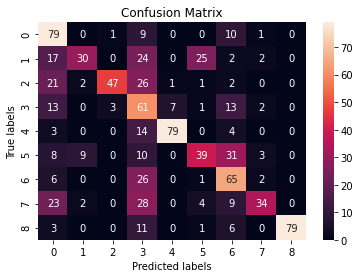

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt     
l = ["0", "1", "2", "3", "4", "5", "6", "7", "8"]
ax= plt.subplot()
sns.heatmap(confusion_matrix, annot=True, ax = ax, ); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(l); ax.yaxis.set_ticklabels(l);

### Evaluating on Custom Inputs 

In [0]:
%time
results = []

sent = "Mumbai man is suing his parents because they brought him into the world without his permission."
test = [InputExample(guid=8, text_a=sent, text_b=None, label='0')]
test_features = convert_examples_to_features(test, label_list, max_seq_length, tokenizer)

all_input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long).to(device)
all_input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long).to(device)
all_segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long).to(device)

model.eval()


with torch.no_grad():
    logits = model(all_input_ids, all_segment_ids, all_input_mask)

logits = logits.detach().cpu().numpy()
results.append(logits)

soft = torch.nn.Softmax()
r = np.argmax(soft(torch.from_numpy(results[0])).numpy())
print ('\n\nLabel: ', id_to_label[r])

04/26/2020 19:47:55 - INFO - __main__ -   *** Example ***
04/26/2020 19:47:55 - INFO - __main__ -   guid: 8
04/26/2020 19:47:55 - INFO - __main__ -   tokens: [CLS] mumbai man is sui ##ng his parents because they brought him into the world without his permission . [SEP]
04/26/2020 19:47:55 - INFO - __main__ -   input_ids: 101 8955 2158 2003 24086 3070 2010 3008 2138 2027 2716 2032 2046 1996 2088 2302 2010 6656 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
04/26/2020 19:47:55 - INFO - __main__ -   input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs


Label:  Non-Political


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
